# Очистка

In [1]:
import gc
import torch

torch.cuda.empty_cache()
gc.collect()

0

# Начало работы

## Импортирование библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tqdm import tqdm
import jiwer
import mlflow
import random
import pickle
from trdg.generators import GeneratorFromStrings

from sklearn.model_selection import train_test_split

import os
import ast

from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from torchvision.transforms import v2
import torchvision.transforms.functional as F
import torch
import torch.nn as nn
import torch.optim as optim

from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

import gc

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("mlflow").setLevel(logging.ERROR)

Missing modules for handwritten text generation.


## Объявление основных переменных

In [2]:
img_dataset_path = 'img-text'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

SEED = 42

In [3]:
BUCKET = "test-bucket-fluke8"
client = mlflow.tracking.MlflowClient()

In [4]:
class GaussianNoise(object):
    def __init__(self, mean=0.0, sigma=(0.1, 0.3), p=0.5):
        self.mean = mean
        self.sigma = sigma
        self.p = p

    def __call__(self, tensor):
        if random.random()>self.p:
            noise = torch.randn(tensor.size()) * random.uniform(*self.sigma) + self.mean
            return tensor + noise
        else:
            return tensor
        
    def __str__(self) -> str:
        return (f"GaussianNoise {self.mean, self.sigma, self.p}")

class AddRandomStripes:
    def __init__(self, stripes_num_range, stripes_size_range):
        self.stripes_num_range = stripes_num_range
        self.stripes_size_range = stripes_size_range

    def __call__(self, tensor):
        # Предполагается, что на вход подается тензор формы [C, H, W]
        num_channels, height, width = tensor.shape
        
        num_stripes = random.randint(*self.stripes_num_range)  # Количество полос

        for _ in range(num_stripes):
            if random.random()>0.5:
                stripe_height = random.randint(*self.stripes_size_range)  # Высота полосы
                y_start = random.randint(0, height - stripe_height)
                color = torch.tensor([random.randint(0, 255) / 255.0] * num_channels).view(num_channels, 1, 1)  # Нормируем цвет в диапазон [0, 1]

                # Добавление полосы к изображению
                tensor[:, y_start:y_start + stripe_height, :] = color
            else:
                stripe_width = random.randint(*self.stripes_size_range)  # Высота полосы
                x_start = random.randint(0, width - stripe_width)
                color = torch.tensor([random.randint(0, 255) / 255.0] * num_channels).view(num_channels, 1, 1)  # Нормируем цвет в диапазон [0, 1]

                # Добавление полосы к изображению
                tensor[:, :, x_start:x_start + stripe_width] = color

        return tensor
    
    def __str__(self) -> str:
        return (f"AddRandomStripes {self.stripes_num_range, self.stripes_size_range}")

class RandomVerticalCompression:
    def __init__(self, compression_coef_range=(0.8, 0.9), p=0.5):
        self.compression_coef_range = compression_coef_range
        self.p = p

    def __call__(self, img):
        # Поскольку img имеет форму [C, H, W]
        original_size = img.shape[1:]  # (H, W)
        num_channels = img.shape[0]
        
        compression_scale = random.uniform(*self.compression_coef_range)
        
        target_height, target_width = int(original_size[0]*compression_scale), original_size[1]

        resize_transform = transforms.Resize((target_height, target_width))

        resized_img = resize_transform(img)

        # Новые размеры после изменения
        new_height, width = resized_img.shape[1], resized_img.shape[2]

        # Рассчитываем паддинг для дополнения до оригинального размера
        padding_height = original_size[0] - new_height


        upper_padding_height = random.randint(0, padding_height)
        lower_padding_height = padding_height - upper_padding_height

        upper_padding = torch.zeros(num_channels, upper_padding_height, width)
        lower_padding = torch.zeros(num_channels, lower_padding_height, width)     

        padded_img = torch.cat((upper_padding, resized_img, lower_padding), dim=1)

        return padded_img
    
    def __str__(self) -> str:
        return (f"RandomVerticalCompression {self.compression_coef_range,self.p}")
    

class ResizePadding:
    def __init__(self, target_size, mode='width', centered=False):
        self.target_size = target_size
        self.mode = mode  # 'width' или 'height'
        self.centered = centered

    def __call__(self, img):
        channels, height, width = img.shape
        
        if self.mode == 'width' and width < self.target_size:
            padding_width = self.target_size - width
            
            if self.centered:
                left_padding_width = right_padding_width = padding_width // 2
            else:
                left_padding_width = random.randint(0, padding_width)
                right_padding_width = padding_width - left_padding_width
            
            left_padding = torch.zeros(channels, height, left_padding_width)
            right_padding = torch.zeros(channels, height, right_padding_width)
            padded_img = torch.cat((left_padding, img, right_padding), dim=2)

        elif self.mode == 'height' and height < self.target_size:
            padding_height = self.target_size - height
            
            if self.centered:
                upper_padding_height = lower_padding_height = padding_height // 2
            else:
                upper_padding_height = random.randint(0, padding_height)
                lower_padding_height = padding_height - upper_padding_height
            
            upper_padding = torch.zeros(channels, upper_padding_height, width)
            lower_padding = torch.zeros(channels, lower_padding_height, width)
            padded_img = torch.cat((upper_padding, img, lower_padding), dim=1)

        else:
            padded_img = img

        return padded_img

    def __str__(self) -> str:
        return f"ResizePadding {self.target_size}, mode={self.mode}, centered={self.centered}"

    
class RotateTransform:
    def __init__(self, angle=-90, expand=True):
        self.angle = angle
        self.expand = expand

    def __call__(self, x):
        return transforms.functional.rotate(x, self.angle, expand=self.expand)

    def __str__(self) -> str:
        return (f"RotateTransform {self.angle, self.expand}")

        

## Объявление основных функций и классов

Создать эксперимент

In [5]:
def set_experiment(exp_name):
    existing_experiment = mlflow.get_experiment_by_name(exp_name)

    if existing_experiment is not None:
        experiment_id = existing_experiment.experiment_id
        print(f"Experiment '{exp_name}' already exists with ID: {experiment_id}")
    else:
        experiment_id = mlflow.create_experiment(exp_name, artifact_location=f"s3://{BUCKET}/{exp_name}")
        print(f"Created new experiment '{exp_name}' with ID: {experiment_id}")

    mlflow.set_experiment(exp_name)

    return experiment_id

Вывод обрезанных слов на экран

In [77]:
def show_cropped_words(df, count, random_display=False):
    if random_display:
        df = df.sample(n=count)  
    else:
        df = df.head(count) 

    imgs = []
    targets = []

    for index, (row_index, row) in enumerate(df.iterrows(), start=1):
        print(row)
        target = row['utf8_string']
        img = cv2.imread(row['filepath'], 0)
        # _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        # img = cv2.GaussianBlur(img, (5, 5), 0)

        x1, y1, width, height = map(int, row['bbox'])
        y2 = y1 + height
        x2 = x1 + width
        img = img[y1:y2, x1:x2]

        imgs.append(img)
        targets.append(target)

        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()

        if index>=count:
            return imgs, targets

    

Прочитать изображение

In [7]:
def read_image(path, channels):
    if channels==1:
        img = cv2.imread(path, 0)
    else:
        img = cv2.imread(path)
    
    if img is None:
        raise FileNotFoundError(f"Изображение не найдено по пути: {path}")
    
    return img

Изменить размер изображения

In [8]:
def resize_image(img, width=None, height=None):
    original_height, original_width = img.shape[:2]
    # print(f"resize_image height: {height}")
    # print(f"resize_image width: {width}")

    if width is None and height is None:
        return img 
    if width is not None and height is None:
        aspect_ratio = original_height / original_width
        new_height = int(width * aspect_ratio)
        new_size = (width, new_height)
    elif height is not None and width is None:
        aspect_ratio = original_width / original_height
        new_width = int(height * aspect_ratio)
        new_size = (new_width, height)
    else:
        new_size = (width, height)

    resized_image = cv2.resize(img, new_size, interpolation=cv2.INTER_LINEAR)
    return resized_image

Масштабировать изображение

In [9]:
def crop_image(img, bbox):
    x1, y1, width, height = map(int, bbox)
    x2 = x1 + width
    y2 = y1 + height
    img = img[y1:y2, x1:x2]
    return img

Закодировать символьную последовательность

In [10]:
def encode_sequence_with_blank(sequence, symbols, blank_symbol, **kwargs):
    encoded = []
    for char in sequence:
        if char in symbols:
            encoded.append(symbols.index(char))
            encoded.append(blank_symbol) 

    if encoded and encoded[-1] == blank_symbol:
        encoded.pop()
    return encoded

Декодирование последовательности

In [11]:
def decode_sequence_with_blank(encoded, symbols, blank_symbol, **kwargs):
    decoded = []
    for index, code in enumerate(encoded):
        if code == blank_symbol or (index>0 and code==encoded[index-1]):
            continue
        decoded.append(symbols[code])
    
    return ''.join(decoded)

Обработать изображение

In [12]:
def process_image(img, bbox, text, max_seq_length, width, height, channels, threshold=None, blur=None,  **kwargs):
    if bbox[0] >= img.shape[1] or bbox[1] >= img.shape[0]:
        raise ValueError("Координаты кропирования выходят за рамки изображения")

    img = crop_image(img, bbox)

    if img is None or img.size == 0:
        raise ValueError("Входное изображение пустое")
    
    seq_length = len(text)
    letters_coef = seq_length / max_seq_length 
    adapted_width = round(width * letters_coef)

    img = resize_image(img, height=height, width=adapted_width)

    if threshold:
        if channels!=1:  
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        _, img = cv2.threshold(img, threshold[0], threshold[1], cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    if blur:
        img = cv2.GaussianBlur(img, (5, 5), 0)

    return img

Подготовить и загрузить данные

In [13]:
def prepare_and_load_data(image_paths, bboxes, texts, transform, image_params, **kwargs):
    channels = image_params['channels']

    max_seq_length = kwargs['filter_params']['string_length_range'][1]
    
    def process_image_and_text(path, text, bbox, channels, max_seq_length, image_params):
        img = read_image(path, channels)
        img = process_image(img, bbox, text, max_seq_length, **image_params)

        if transform:
            img = transform(img)
        # else:
        #     transform = transforms.Compose([
        #                 transforms.ToTensor(),
        #             ])
        #     img = transform(img)

        # return {'img': torch.tensor(img), 'text': text}
        return {'img': img, 'text': text}

    desc = "Подготовка датасета"

    loaded_data = []

    with ThreadPoolExecutor() as executor:
        futures = []
        for path, bbox, text in zip(image_paths, bboxes, texts):
            futures.append(executor.submit(process_image_and_text, path, 
                                           text, bbox, channels, max_seq_length, image_params))

        for future in tqdm(as_completed(futures), desc=desc, total=len(futures), ncols=70):
            loaded_data.append(future.result())

    return loaded_data

Датасет с обрезанными словами

In [14]:
class CroppedWordsDataset(Dataset):
    def __init__(self, df, check_params, transform=None, prepare_transform=False, **params):
        data_columns = params['data_columns']

        image_paths = df[data_columns['image_paths']].tolist()
        bboxes = df[data_columns['bboxes']].tolist()
        texts = df[data_columns['texts']].tolist()

        self.symbols = params['text_params']['symbols']
        self.blank_symbol = params['text_params']['blank_symbol']

        self.transform = transform
        self.prepare_transform = prepare_transform

        if self.prepare_transform:
            self.loaded_data = prepare_and_load_data(image_paths, bboxes, texts, transform=self.transform, **params)  
        else:
            self.loaded_data = prepare_and_load_data(image_paths, bboxes, texts, transform=None, **params)  


        self.length = len(self.loaded_data)

        self.check_params = check_params

    def __len__(self):
        return self.length

    def __getstate__(self):
        state = self.__dict__.copy()
        # del state['transform']
        return state

    def __setstate__(self, state):
        self.__dict__.update(state)

    def __eq__(self, other):
        return self.check_params == other.check_params
    
    def __getitem__(self, index):
        text = encode_sequence_with_blank(self.loaded_data[index]['text'], 
                                        symbols=self.symbols,
                                        blank_symbol=self.blank_symbol)

        if not self.prepare_transform: 
            img = self.transform(self.loaded_data[index]['img'])
        else:
            img = self.loaded_data[index]['img']

        return img, torch.tensor(text, dtype=torch.long)


Синтезировать слова и изображения

In [15]:
def synthes_images_and_texts(symbols, transform, **params):
    count_words = params['trdg_params']['count_words']
    text_length_range = params['trdg_params']['text_length_range']
    
    def synthes_image_and_text(generator_params):
        generator = GeneratorFromStrings(**generator_params)

        zipped_data = []
        for img, text in generator:
            text = ''.join(text)
            if transform:
                img = transform(img)
            zipped_data.append({'img': img, 'text': text})

        return zipped_data


    desc = "Синтез фото"
    synthesed_data = []
    

    texts = np.array([[random.choice(symbols) for _ in range(random.randint(*text_length_range))] for _ in range(count_words)])    

    with ThreadPoolExecutor() as executor:
        futures = []
        for text in np.array_split(texts, 8):
            img_text_generation_params = {
                'strings':text,
                'count':params['trdg_params']['count']//8,
                'width':params['trdg_params']['width'],
                'blur':params['trdg_params']['blur'],
            }

            futures.append(executor.submit(synthes_image_and_text, img_text_generation_params))

        for future in tqdm(as_completed(futures), desc=desc, total=len(futures), ncols=70):
            synthesed_data.extend(future.result())

    # img_text_generator = GeneratorFromStrings(
    #     texts,
    #     count=params['trdg_params']['count'],
    #     width=params['trdg_params']['width'],
    #     blur=params['trdg_params']['blur'],
    # )
    
    # for img, text in tqdm(img_text_generator, desc=desc, total=params['trdg_params']['count'], ncols=70):
    #     text = ''.join(text)
    #     if transform:
    #         img = transform(img)
        
    #     synthesed_data.append({'img': img, 'text': text})
    print(len(synthesed_data))
    return synthesed_data

Датасет синтезированных слов

In [16]:
class SynthesizedDataset(Dataset):
    def __init__(self, texts, transform, string_length_range, random_sequence_prob=0.5, **params):
        self.texts = texts
        self.random_sequence_prob = random_sequence_prob
        self.string_length_range = string_length_range

        self.symbols = params['text_params']['symbols']
        self.blank_symbol = params['text_params']['blank_symbol'] 
        
        self.transform = transform

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):

        if random.random() > self.random_sequence_prob:
            seq = self.texts[index]
        else:
            seq = ''.join([random.choice(self.symbols) for _ in range(random.randint(*self.string_length_range))])

        img_generator = GeneratorFromStrings(
                                [seq],
                                blur=random.randint(1,3),
                                background_type=random.randint(0,2),
                                random_blur=True, 
                                character_spacing=random.randint(0,7),
                                count=1,
                                margins=(random.randint(0,7), random.randint(0,7), random.randint(0,7), random.randint(0,7)),
                            )
        
        for input, _ in img_generator:
            array = np.array(input)
            img = cv2.cvtColor(array, cv2.COLOR_BGR2GRAY)
            img = self.transform(img)

        seq = encode_sequence_with_blank(seq, 
                                            symbols=self.symbols,
                                            blank_symbol=self.blank_symbol)
        

        return img, torch.tensor(seq, dtype=torch.long)


Создать тензоры

In [17]:
def collate_fn(batch, blank_symbol, **kwargs):
    min_height = min(map(lambda x: x[0].shape[1], batch))
    min_width = min(map(lambda x: x[0].shape[2], batch))

    aligned_images = []
    for tensor, _ in batch:
        aligned_tensor = tensor[:min_width, :min_height]
             
        aligned_images.append(aligned_tensor)
    
    max_len_seq = max(map(len, map(lambda x: x[1], batch)))
    padded_sequences = []
    seq_lengths = []
    for _, seq in batch:
        seq_lengths.append(len(seq))
        if len(seq) < max_len_seq:
            padding = torch.full((max_len_seq - len(seq),), blank_symbol)
            padded_seq = torch.cat((seq, padding))
        else:
            padded_seq = seq 
        padded_sequences.append(padded_seq)



    return torch.stack(aligned_images), torch.stack(padded_sequences), torch.tensor(seq_lengths, dtype=torch.long)
        

In [18]:
def collate_with_transform_fn(batch, blank_symbol, transform, **kwargs):
    # min_height = min(map(lambda x: x[0].shape[1], batch))
    # min_width = min(map(lambda x: x[0].shape[2], batch))

    # transformed_images = []

    tensors = [tensor for tensor, _ in batch]

    # with ThreadPoolExecutor() as executor:
    #     transformed_images = list(executor.map(transform, tensors))

    transformed_images = list(map(transform, tensors))

    
    max_len_seq = max(map(len, map(lambda x: x[1], batch)))
    padded_sequences = []
    seq_lengths = []
    for _, seq in batch:
        seq_lengths.append(len(seq))
        if len(seq) < max_len_seq:
            padding = torch.full((max_len_seq - len(seq),), blank_symbol)
            padded_seq = torch.cat((seq, padding))
        else:
            padded_seq = seq 
        padded_sequences.append(padded_seq)



    return torch.stack(transformed_images), torch.stack(padded_sequences), torch.tensor(seq_lengths, dtype=torch.long)
        

Фильтрация датафрейма

In [20]:
def filter_dataframe(df, symbols, string_length_range, height_width_ratio_max, area_min, crop_sizes_min, coordinates_min, **kwargs):
    df = df[df['utf8_string'].apply(lambda x: isinstance(x, str) and all(char in set(symbols) for char in x))]
    df = df[(df['string_length'] >= string_length_range[0]) & (df['string_length'] <= string_length_range[1])]
    df = df[(df['height/width-ratio'] < height_width_ratio_max)]
    df = df[(df['area'] > area_min)]
    df = df[(df['crop_width'] > crop_sizes_min) & (df['crop_height'] > crop_sizes_min)]
    df = df[(df['x1'] >= coordinates_min) & (df['y1'] >= coordinates_min)]
    return df

Сохранить/прочитать файл

In [21]:
def save_obj(obj, filepath):
    directory = os.path.dirname(filepath)
    if directory and not os.path.exists(directory):
        os.makedirs(directory)
    try:
        with open(f'{filepath}.pkl', 'wb') as file:
            pickle.dump(obj, file)
        return True
    except Exception as e:
        print(f"Ошибка при сохранении файла: {e}")
        return False

def read_obj(filepath):
    try:
        with open(filepath, 'rb') as file:
            return pickle.load(file)
    except Exception as e:
        print(f"Ошибка при загрузке файла: {e}")
        return False   

Найти датасет

In [22]:
def find_same_dataset(dir, split_name, finding_filename, check_params):
    if os.path.exists(dir):
        for filename in tqdm(os.listdir(dir), desc="Поиск датасета", ncols=90):
            if finding_filename in filename:
                if split_name in filename and 'pkl' in filename:
                    filepath = os.path.join(dir, filename)
                    file = read_obj(filepath)
                    if type(file)==CroppedWordsDataset and file.check_params == check_params:
                        print('Найден такой же датасет')
                        return file
                    else:
                        if file.check_params != check_params:
                            print("отличаются проверяемые параметры")
                            print("параметры найденного файла", file.check_params)
                            print("искомые параметры", check_params)
            
        print("Нет такого датасета")
        return False
    else:
        print("Такой папки нет")
        return False

Даталоадеры

In [23]:
def get_dataloaders(df, batch_size, dataset_path, use_synthesed_data, **kwargs):
    df = df.copy()

    df = filter_dataframe(df, **kwargs['filter_params'])

    if kwargs['text_params']['uppercase']:
        df['utf8_string'] = df['utf8_string'].apply(str.upper)


    image_params = kwargs['image_params']
    blank_symbol = kwargs['text_params']['blank_symbol']
    
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED)

    # if kwargs['debug']:
    for _ in range(kwargs['debug']):
        train_df, val_df = train_test_split(val_df, test_size=0.2, random_state=SEED)

    
    train_dataset_filename = str(list({**kwargs['filter_params'], 
                        **kwargs['text_params'], 
                        **kwargs['image_params'],
                        'length': len(train_df)}.values()))
    
    val_dataset_filename = str(list({**kwargs['filter_params'], 
                        **kwargs['text_params'], 
                        **kwargs['image_params'],
                        'length': len(val_df)}.values()))
    

    if kwargs['prepare_transform']:
        train_check_params = train_dataset_filename+str(kwargs['transform_train'])
        val_check_params = val_dataset_filename+str(kwargs['transform_val'])
    else:
        train_check_params = train_dataset_filename#+str(kwargs['transform_train'])
        val_check_params = val_dataset_filename#+str(kwargs['transform_val'])
    

    if kwargs['find_dataset']:
        train_dataset = find_same_dataset(dataset_path, 'train', train_dataset_filename, train_check_params) 
        val_dataset = find_same_dataset(dataset_path, 'val', val_dataset_filename, val_check_params) 

    if not kwargs['find_dataset'] or not (train_dataset and val_dataset):
        train_dataset = CroppedWordsDataset(train_df,train_check_params,kwargs['transform_train'],**kwargs)

        val_dataset = CroppedWordsDataset(val_df,val_check_params,kwargs['transform_val'],**kwargs)

        # train_dataset = CroppedWordsDataset(train_df,train_check_params,**kwargs)
        # val_dataset = CroppedWordsDataset(val_df,val_check_params,**kwargs)

        if kwargs['save_dataset']:
            save_obj(train_dataset, os.path.join(dataset_path, f'train_dataset_{train_dataset_filename}'))
            save_obj(val_dataset, os.path.join(dataset_path, f'val_dataset_{val_dataset_filename}'))

    if use_synthesed_data:
        train_synthesed_dataset = SynthesizedDataset(texts=train_df['utf8_string'].values, 
                                                    transform=kwargs['transform_train'],
                                                    random_sequence_prob=0.5,
                                                    string_length_range=kwargs['filter_params']['string_length_range'],
                                                    **kwargs)
        

        train_dataset = ConcatDataset([train_dataset, train_synthesed_dataset])

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, collate_fn=lambda x: collate_fn(x,
                                                                                                            blank_symbol,), 
                                                                                                            shuffle=kwargs['train_shuffle'])
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=lambda x: collate_fn(x,
                                                                                                        blank_symbol,))

    # train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, collate_fn=lambda x: collate_with_transform_fn(x,
    #                                                                                                         blank_symbol, 
    #                                                                                                         kwargs['transform_train']), 
    #                                                                                                         shuffle=kwargs['train_shuffle'])
    # val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=lambda x: collate_with_transform_fn(x,
    #                                                                                                     blank_symbol,
    #                                                                                                     kwargs['transform_val']))

    return train_loader, val_loader


Модель

In [24]:
class CRNN(nn.Module):  
    def __init__(self, num_classes, channels):
        super(CRNN, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=(5, 5), padding=(2, 2), stride=(1, 1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(kernel_size=(1, 2), padding=(0, 0), stride=(1, 2)),


            nn.Conv2d(64, 128, kernel_size=(5, 5), padding=(2, 2), stride=(1, 1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(kernel_size=(1, 2), padding=(0, 0), stride=(1, 2)),


            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1), stride=(1, 1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01),

            nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1), stride=(1, 1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(kernel_size=(2, 2), padding=(0, 0), stride=(2, 2)),


            nn.Conv2d(256, 512, kernel_size=(3, 3), padding=(1, 1), stride=(1, 1)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(kernel_size=(2, 2), padding=(0, 0), stride=(2, 2)),


            nn.Conv2d(512, 1024, kernel_size=(3, 3), padding=(1, 1), stride=(1, 1)),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(kernel_size=(2, 2), padding=(0, 0), stride=(2, 2)),

            nn.Conv2d(1024, 1024, kernel_size=(3, 3), padding=(1, 1), stride=(1, 1)),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(kernel_size=(1, 2), padding=(0, 0), stride=(1, 2)),
        )   

        self.rnns = nn.Sequential(
            nn.LSTM(1024, 512, batch_first=True, bidirectional=True),
            nn.LSTM(1024, 512, batch_first=True, bidirectional=True),
            # nn.LSTM(256, 128, batch_first=True, bidirectional=True),
        )
        
        self.classifier = nn.Sequential(
        #    nn.Linear(256, 512),
           nn.Linear(1024, num_classes),
        )
        

    def forward(self, x):
        x = self.convs(x)
        
        x = x.squeeze(3) 
        x = x.permute(0, 2, 1)  

        for lstm in self.rnns:
            x, _ = lstm(x)

        x = self.classifier(x)

        x = x.log_softmax(dim=2)
        return x

Рассчет метрик

In [25]:
def calculate_metrics(model, val_loader, verbose, **kwargs):
    model.eval()
    total_preds = []
    total_targets = []

    with torch.no_grad():
        for inputs, targets, _ in tqdm(val_loader, desc="Calculating Metrics", ncols=70):
            inputs, targets = inputs.to(device), targets.to(device)
            # inputs = inputs.squeeze(1)

            outputs = model(inputs)

            predicted_classes = torch.argmax(outputs, dim=2)
        
            total_preds.extend(predicted_classes)
            total_targets.extend(targets)

    total_preds = [decode_sequence_with_blank(pred.cpu().numpy().tolist(), **kwargs) for pred in total_preds]
    total_targets = [decode_sequence_with_blank(target.cpu().numpy().tolist(), **kwargs) for target in total_targets]
    
    sample_preds = total_preds[:30]
    sample_targets = total_targets[:30]

    if verbose:
        print(f"Предсказание модели:{sample_preds}")
        print(f"Правильные ответы:{sample_targets}")

    sample_predictions_and_targets = pd.DataFrame([sample_preds, sample_targets])

    cer = jiwer.cer(total_targets, total_preds) 
    wer = jiwer.wer(total_targets, total_preds) 
    metrics = {
        "cer": cer,
        "wer": wer
        }
    print(metrics)

    return metrics, sample_predictions_and_targets

Ранняя остановка

In [26]:
class EarlyStopping:
    def __init__(self, best_score,
                 patience=7, 
                 verbose=False, 
                 delta=0, 
                 metric_direction='max', 
                 metric_name=None):
        
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = best_score
        self.early_stop = False
        self.metric_direction = metric_direction
        self.metric_name = metric_name

    def __call__(self, val_score):
        score = val_score

        if self.metric_direction == 'max':
            if score < self.best_score + self.delta:
                self.counter += 1
                if self.verbose:
                    print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                if self.verbose:
                    print(f'Validation {self.metric_name} Score increased ({self.best_score:.6f} --> {score:.6f}). ')
                self.best_score = score
                self.counter = 0
        else:  
            if score > self.best_score - self.delta:
                self.counter += 1
                if self.verbose:
                    print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                if self.verbose:
                    print(f'Validation {self.metric_name} Score decreased ({self.best_score:.6f} --> {score:.6f}). ')
                self.best_score = score
                self.counter = 0



Обучение

In [27]:
def is_run_active(run_id):
    try:
        run = mlflow.get_run(run_id)
        # Проверяем, активен ли ран
        return run.info.status == "RUNNING"
    except Exception as e:
        # Обработка случая, когда рана не найдена или другая ошибка
        print(f"Ошибка при получении рана: {e}")
        return False

In [28]:
def log_model_async(model, desc, run_id):
    # Логирование в фоновом потоке
    if is_run_active(run_id):
        mlflow.pytorch.log_model(model, desc)
    else:
        try:
            with mlflow.start_run(run_id=run_id):
                mlflow.pytorch.log_model(model, desc)
        finally:
            mlflow.end_run() 

In [29]:
def train_model(train_loader, val_loader, model, **kwargs):
    torch.cuda.empty_cache()
    gc.collect()

    if type(model)==str:
        model = mlflow.pytorch.load_model(model).to(device)
        # print(model)
        
    model_name = kwargs['model_name']
    learning_rate = kwargs['learning_rate']
    run_id = kwargs['run_id']
    main_metric_name = kwargs['main_metric_name']
    metric_history = client.get_metric_history(run_id, f'train_{main_metric_name}')
    start_epoch = metric_history[-1].step if metric_history else 0
    num_epochs = kwargs['num_epochs'] + start_epoch
    train_metric_interval = kwargs['train_metric_interval']
    log_interval = kwargs['log_interval']
    early_stop_patience = kwargs['early_stop_patience']
    metric_direction = kwargs['metric_direction']
    blank_symbol = kwargs['text_params']['blank_symbol']

    criterion = nn.CTCLoss(blank=blank_symbol, reduction='mean', zero_infinity=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)


    if run_id:
        run_info = client.get_run(run_id)
        metrics = run_info.data.metrics
    else:
        metrics = {}

    start_score = float('-inf') if metric_direction=="max" else float('inf')
    main_metric_score = metrics.get(f'best_val_{main_metric_name}', start_score)

    if early_stop_patience:
        early_stopping = EarlyStopping(best_score=main_metric_score,
                                       patience=early_stop_patience, 
                                       verbose=True,
                                       metric_direction=metric_direction,
                                       metric_name=main_metric_name)

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets, target_lengths in tqdm(train_loader, f"Epoch [{epoch + 1}/{num_epochs}]", ncols=70):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            outputs = outputs.permute(1, 0, 2)

            assert outputs.size(0) >= targets.size(1), "Output size must be >= target size"

            input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long, device=device)

            loss = criterion(outputs, targets,input_lengths=input_lengths, target_lengths=target_lengths)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)


        average_loss = running_loss / len(train_loader.dataset)
        print("training_loss", average_loss)
        mlflow.log_metrics({'training_loss': average_loss}, step=epoch + 1)

        if epoch % train_metric_interval == 0:
            print("Метрики на обучающем датасете:")
            train_metrics, train_samples = calculate_metrics(model, train_loader, **kwargs, **kwargs['text_params'])
            mlflow.log_metrics({'train_wer': train_metrics['wer'], 'train_cer': train_metrics['cer']}, step=epoch + 1)
            mlflow.log_text(str(train_samples), 'train_samples.txt')

        print("Метрики на валидационном датасете:")
        val_metrics, val_samples = calculate_metrics(model, val_loader, **kwargs, **kwargs['text_params'])
        mlflow.log_metrics({'val_wer': val_metrics['wer'], 'val_cer': val_metrics['cer']}, step=epoch + 1)

        if val_metrics[main_metric_name] < main_metric_score:
            main_metric_score = val_metrics[main_metric_name]
            mlflow.log_metric(f'best_val_{main_metric_name}', main_metric_score)
            mlflow.log_text(str(val_samples), 'best_epoch_val_samples.txt')
            threading.Thread(target=log_model_async, args=(model, f"best_epoch_{model_name}", run_id)).start()

        if epoch % log_interval == 0:
            threading.Thread(target=log_model_async, args=(model, f"last_epoch_{model_name}", run_id)).start()

        if early_stop_patience:
            early_stopping(val_metrics[main_metric_name])
            if early_stopping.early_stop:
                print("Early stopping")
                break

        assert average_loss!=0
        

    return model


Логирование инфы

In [30]:
def draw_horizontal_lines(ax, num_lines, image_height, color='black'):
    """Рисует горизонтальные линии на заданной оси ax с автоматическим определением расстояния."""
    spacing = image_height / (num_lines + 1)  # Промежуток между линиями

    for i in range(num_lines):
        # Вычисляем положение линии
        y_position = spacing * (i + 1)
        # Рисуем линию
        ax.hlines(y=y_position, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color=color, linewidth=1)

In [31]:
def log_data(df, train_loader, train_args, data_args, **kwargs):
    df = df.copy()
    
    df['bbox'] = df['bbox'].astype(str)

    mlflow.log_text("{\n" + ",\n".join(f"    {repr(key)}: {repr(value)}" for key, value in train_args.items()) + "\n}", "train_args.txt")
    mlflow.log_text("{\n" + ",\n".join(f"    {repr(key)}: {repr(value)}" for key, value in data_args.items()) + "\n}", "data_args.txt")

    num_images = 10
    num_lines = (data_args['filter_params']['string_length_range'][1]-1)*2-1   # Количество линий, которые хотите нарисовать
    # num_lines = (data_args['filter_params']['string_length_range'][1])-1  # Количество линий, которые хотите нарисовать
    fig, axes = plt.subplots(5, 2, figsize=(6, 20))


    for i, (inputs, targets, _) in enumerate(train_loader):          
        images = inputs.numpy()[:num_images]
        targets = targets.numpy()[:num_images]

        if images.ndim == 4: 
            images = images.transpose(0, 2, 3, 1)

        break

    for ax, image, target in zip(axes.flatten(), images, targets):
        ax.imshow(image) 
        ax.axis('off')
        ax.set_title(f'Target: {decode_sequence_with_blank(target, **data_args['text_params'])}')
        
        image_height = image.shape[0]  # Высота изображения
        draw_horizontal_lines(ax, num_lines, image_height)  # Рисуем линии для каждого изображения

    plt.tight_layout()
    plt.savefig("dataset_samples.png")
    plt.close()
    mlflow.log_artifact("dataset_samples.png")


## Загрузка данных

In [32]:
# annot_df = pd.read_csv(os.path.join(img_dataset_path, 'annot.csv'), index_col=0)
# img_df = pd.read_csv(os.path.join(img_dataset_path, 'img.csv'), index_col=0)

In [33]:
# df = annot_df.merge(img_df, left_on='image_id', right_on='id', suffixes=('', '_temp')).drop(['id_temp', 'set', 'points'], axis=1).dropna()
# df['filepath'] = df['image_id'].apply(lambda x: os.path.join(img_dataset_path, 'images', (x+'.jpg')))
# df['bbox'] = df['bbox'].apply(lambda x: ast.literal_eval(x))
# df['x1'] = df['bbox'].apply(lambda x: x[0])
# df['y1'] = df['bbox'].apply(lambda x: x[1])
# df['crop_width'] = df['bbox'].apply(lambda x: x[2])
# df['crop_height'] = df['bbox'].apply(lambda x: x[3])
# df['height/width-ratio'] = df['crop_height']/df['crop_width']
# df['string_length'] = df['utf8_string'].apply(len)

# df

In [34]:
# df.to_csv(os.path.join(img_dataset_path, 'df.csv'), index=False)

In [35]:
df = pd.read_csv(os.path.join(img_dataset_path, 'df.csv'), index_col=False)

In [36]:
df['bbox'] = df['bbox'].apply(lambda x: ast.literal_eval(x))
df

id          image_id  \
0         a4ea732cd3d5948a_1  a4ea732cd3d5948a   
1         a4ea732cd3d5948a_2  a4ea732cd3d5948a   
2         a4ea732cd3d5948a_3  a4ea732cd3d5948a   
3         a4ea732cd3d5948a_4  a4ea732cd3d5948a   
4         a4ea732cd3d5948a_5  a4ea732cd3d5948a   
...                      ...               ...   
1052273  0ebbecdc46b78d42_15  0ebbecdc46b78d42   
1052274   a37e1fb026b80a6d_1  a37e1fb026b80a6d   
1052275   a37e1fb026b80a6d_2  a37e1fb026b80a6d   
1052276   a37e1fb026b80a6d_3  a37e1fb026b80a6d   
1052277   a37e1fb026b80a6d_4  a37e1fb026b80a6d   

                                     bbox  utf8_string      area  width  \
0            [525.83, 3.4, 197.64, 33.94]  Performance   6707.90    840   
1           [534.67, 64.68, 91.22, 38.19]        Sport   3483.69    840   
2           [626.95, 63.62, 96.52, 31.82]        Watch   3071.27    840   
3           [577.4, 141.87, 147.13, 43.1]   ...period.   6341.30    840   
4           [391.03, 163.9, 60.82, 38.65]            .   2350.69    840   
...                                   ...          ...       ...    ...   
1052273     [267.47, -0.14, 28.18, 27.47]            .    774.10   1024   
1052274  [331.69, 462.84, 417.31, 201.08]          RÖR  83912.69   1024   
1052275    [876.75, 285.63, 36.98, 10.28]      Moderna    380.15   1024   
1052276    [913.53, 282.86, 32.23, 11.27]       Museet    363.23   1024   
1052277    [883.47, 302.44, 68.42, 10.88]            .    744.41   1024   

         height                   file_name  \
0          1024  train/a4ea732cd3d5948a.jpg   
1          1024  train/a4ea732cd3d5948a.jpg   
2          1024  train/a4ea732cd3d5948a.jpg   
3          1024  train/a4ea732cd3d5948a.jpg   
4          1024  train/a4ea732cd3d5948a.jpg   
...         ...                         ...   
1052273     681  train/0ebbecdc46b78d42.jpg   
1052274     683  train/a37e1fb026b80a6d.jpg   
1052275     683  train/a37e1fb026b80a6d.jpg   
1052276     683  train/a37e1fb026b80a6d.jpg   
1052277     683  train/a37e1fb026b80a6d.jpg   

                                     filepath      x1      y1  crop_width  \
0        img-text/images/a4ea732cd3d5948a.jpg  525.83    3.40      197.64   
1        img-text/images/a4ea732cd3d5948a.jpg  534.67   64.68       91.22   
2        img-text/images/a4ea732cd3d5948a.jpg  626.95   63.62       96.52   
3        img-text/images/a4ea732cd3d5948a.jpg  577.40  141.87      147.13   
4        img-text/images/a4ea732cd3d5948a.jpg  391.03  163.90       60.82   
...                                       ...     ...     ...         ...   
1052273  img-text/images/0ebbecdc46b78d42.jpg  267.47   -0.14       28.18   
1052274  img-text/images/a37e1fb026b80a6d.jpg  331.69  462.84      417.31   
1052275  img-text/images/a37e1fb026b80a6d.jpg  876.75  285.63       36.98   
1052276  img-text/images/a37e1fb026b80a6d.jpg  913.53  282.86       32.23   
1052277  img-text/images/a37e1fb026b80a6d.jpg  883.47  302.44       68.42   

         crop_height  height/width-ratio  string_length  
0              33.94            0.171726             11  
1              38.19            0.418658              5  
2              31.82            0.329673              5  
3              43.10            0.292938             10  
4              38.65            0.635482              1  
...              ...                 ...            ...  
1052273        27.47            0.974805              1  
1052274       201.08            0.481848              3  
1052275        10.28            0.277988              7  
1052276        11.27            0.349674              6  
1052277        10.88            0.159018              1  

[1052278 rows x 15 columns]

## типа еда

In [37]:
# correlation = df['height/width-ratio'].corr(df['string_length'])

# print("Корреляция между column1 и column2:", correlation)

In [38]:
# sns.histplot(df['string_length'], bins=10, kde=True)


In [39]:
# sns.histplot(df['string_length'], bins=10, kde=True)

In [40]:
# np.exp(3)

In [41]:
# sns.histplot(np.log(df['string_length']), bins=10, kde=True)

In [42]:
# sns.histplot(df['height/width-ratio'], bins=50, kde=True)

In [43]:
# all_strings = list(''.join(df['utf8_string']))

# value_counts = pd.Series(all_strings).value_counts().reset_index()
# value_counts

In [44]:
# set(''.join(df['utf8_string']))

In [45]:
# show_cropped_words(df[df['string_length'] == 3], 10, random_display=True)

In [46]:
# df[(df['height/width-ratio'] < 0.1)]

In [47]:
# show_cropped_words(df[(df['height/width-ratio'] < 0.1)], 100)

In [48]:
# df[df['utf8_string'].str.contains(' ')]

In [49]:
# df[df['utf8_string'].str.contains('-')].shape


In [50]:
# df[df['utf8_string'].str.contains('=')].shape


In [51]:
# df[df['utf8_string'].str.contains('#')].shape


Рассчет среднего и стандартного отклонения

In [52]:
def get_dataset_mean_std(image_dir, channels):
    means = []
    stds = []

    def calculate_image_mean_std(filename):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(os.path.join(image_dir, filename))
            if channels == 1:  # Преобразование в черно-белое
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = img / 255.0
                return {'mean': np.mean(img), 'std': np.std(img)}
            else: 
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img / 255.0
                return {'mean': np.mean(img, axis=(0, 1)), 'std': np.std(img, axis=(0, 1))}
        
        return None  

    with ThreadPoolExecutor() as executor:
        futures = []
        for filename in os.listdir(image_dir):
            futures.append(executor.submit(calculate_image_mean_std, filename))

        for future in tqdm(as_completed(futures), desc='Рассчет mean и std', total=len(futures), ncols=70):
            result = future.result()
            if result:
                means.append(result['mean'])
                stds.append(result['std'])

    overall_mean = np.mean(means, axis=0)
    overall_std = np.mean(stds, axis=0)

    return overall_mean, overall_std

In [53]:
# mean, std = get_dataset_mean_std(os.path.join(img_dataset_path, 'images'), channels=3)
# print(f'Mean: {mean}')
# print(f'STD: {std}')

# transforms.Normalize(mean=[0.47986215, 0.44358668, 0.40762689], std=[0.2493363,  0.24328684, 0.24221595])

In [54]:
# mean, std = get_dataset_mean_std(os.path.join(img_dataset_path, 'images'), channels=1)
# print(f'Mean: {mean}')
# print(f'STD: {std}')

# transforms.Normalize(mean=0.4503373607770565, std=0.23709322707483374)

## Обработка данных

In [55]:
# df = df[df['utf8_string'].apply(lambda x: isinstance(x, str) and all(char in set(symbols) for char in x))]
# df

In [56]:
# df = df[(df['string_length'] >= 3) & (df['string_length'] <= 9)] 
# df = df[(df['height/width-ratio'] < 0.45)]
# df = df[(df['area'] > 5000)]
# df = df[(df['crop_width'] > 5) & (df['crop_height'] > 5)]
# df = df[(df['x1'] >= 0) & (df['y1'] >= 0)]

# df

In [57]:
# for path in df['file_name'].drop_duplicates():
#     img = cv2.imread(path)
#     if img is None:
#         print(f"Warning: Image not found at path: {path}")
#         continue  # Переход к следующему файлу

id                                      572e6271daf518c0_5
image_id                                  572e6271daf518c0
bbox                        [403.33, 25.35, 134.51, 39.21]
utf8_string                                       CURATIVE
area                                               5274.14
width                                                 1024
height                                                 768
file_name                       train/572e6271daf518c0.jpg
filepath              img-text/images/572e6271daf518c0.jpg
x1                                                  403.33
y1                                                   25.35
crop_width                                          134.51
crop_height                                          39.21
height/width-ratio                                0.291502
string_length                                            8
Name: 235632, dtype: object


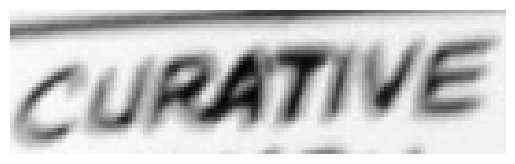

id                                     4091e5a6cdacb729_76
image_id                                  4091e5a6cdacb729
bbox                        [612.7, 487.75, 228.43, 57.11]
utf8_string                                    PRISMACALAR
area                                              13045.64
width                                                 1024
height                                                 683
file_name                       train/4091e5a6cdacb729.jpg
filepath              img-text/images/4091e5a6cdacb729.jpg
x1                                                   612.7
y1                                                  487.75
crop_width                                          228.43
crop_height                                          57.11
height/width-ratio                                0.250011
string_length                                           11
Name: 916626, dtype: object


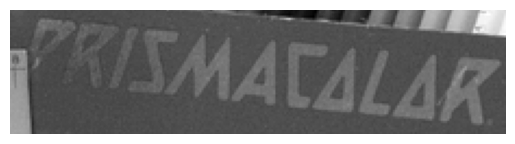

id                                     61e19dbd3c3e5eb8_11
image_id                                  61e19dbd3c3e5eb8
bbox                          [31.66, 689.1, 270.7, 92.16]
utf8_string                                          BUILD
area                                              24947.71
width                                                  834
height                                                1024
file_name                       train/61e19dbd3c3e5eb8.jpg
filepath              img-text/images/61e19dbd3c3e5eb8.jpg
x1                                                   31.66
y1                                                   689.1
crop_width                                           270.7
crop_height                                          92.16
height/width-ratio                                0.340451
string_length                                            5
Name: 87178, dtype: object


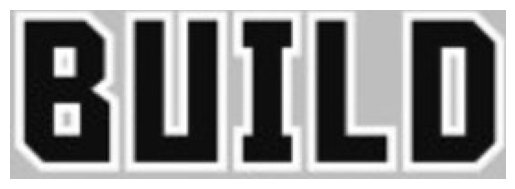

id                                     db03400681da6190_22
image_id                                  db03400681da6190
bbox                        [669.63, 55.79, 198.61, 60.71]
utf8_string                                        AmigaOS
area                                              12057.61
width                                                 1024
height                                                 680
file_name                       train/db03400681da6190.jpg
filepath              img-text/images/db03400681da6190.jpg
x1                                                  669.63
y1                                                   55.79
crop_width                                          198.61
crop_height                                          60.71
height/width-ratio                                0.305674
string_length                                            7
Name: 739168, dtype: object


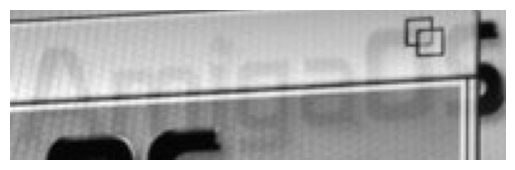

In [160]:
df_filtred = filter_dataframe(df, **data_args['filter_params'])
imgs, targets = show_cropped_words(df_filtred, count=4, random_display=True)

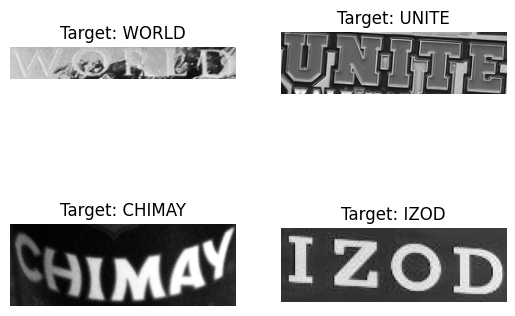

In [85]:
fig, axs = plt.subplots(2, 2)

for ax, img, target in zip(axs.flatten(), imgs, targets):
    ax.imshow(img, cmap='grey')
    ax.set_title(f"Target: {target}")
    ax.axis('off')
plt.show()

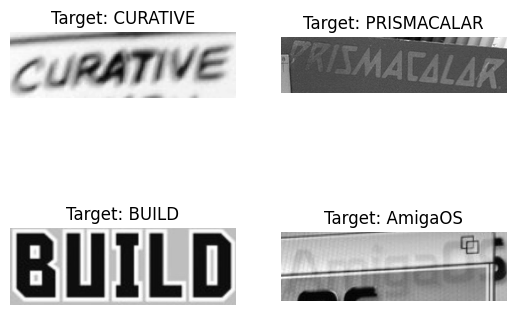

In [161]:
fig, axs = plt.subplots(2, 2)

for ax, img, target in zip(axs.flatten(), imgs, targets):
    ax.imshow(img, cmap='grey')
    ax.set_title(f"Target: {target}")
    ax.axis('off')
plt.show()

# Обучение

Тест

In [153]:
symbols = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz!?"\',.-='
# symbols = sorted(list(set(str.upper(all_symbols))))
blank_symbol = len(symbols)
num_classes = len(symbols) + 1

height = 64
width = 256

test_data_args = {  # ТЕЕЕЕЕЕЕЕЕЕСТ    
    'data_columns': {
        'image_paths': 'filepath',
        'texts': 'utf8_string',
        'bboxes': 'bbox',
    },
    'filter_params': {
        'symbols': symbols,
        'string_length_range': (3, 15), 
        'height_width_ratio_max': 0.45,   
        'area_min': 5000,                    
        'crop_sizes_min': 5,            
        'coordinates_min': 0,   
    },
    'text_params': {
        'uppercase': False,
        'symbols': symbols,
        'blank_symbol': blank_symbol,
    },
    'image_params': {
        'height': height,
        'width': width,
        'threshold': False,
        'blur': False,
        'channels': 1,
    },


    'transform_train': transforms.Compose([
                            transforms.ToTensor(), 
                            # transforms.Normalize(mean=0.4503, std=0.2371),
                            ResizePadding(width, mode='width'),


                            transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=transforms.InterpolationMode.BILINEAR),
                            transforms.ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1)), 
                            RandomVerticalCompression(compression_coef_range=(0.8, 0.9), p=0.9),
                            transforms.RandomInvert(p=0.9),
                            AddRandomStripes(stripes_num_range=(0,2), stripes_size_range=(1,4)),
                            GaussianNoise(mean=0.0, sigma=(0.01, 0.05), p=0.5),

                            RotateTransform(angle=-90, expand=True),
                            transforms.Normalize(mean=0.5, std=0.5),
                            transforms.Resize((width, height))
                        ]),

    'transform_val': transforms.Compose([
                        transforms.ToTensor(),
                        # transforms.Normalize(mean=0.4503, std=0.2371),
                        ResizePadding(width, centered=True),

                        RotateTransform(angle=-90, expand=True),
                        transforms.Resize((width, height))  
                    ]),



    'verbose': True,   
    'batch_size': 50,
    'debug': 3,

    'train_shuffle': False,
    'prepare_transform': False,

    'find_dataset': False,
    'save_dataset': True,
}

test_train_loader, test_val_loader = get_dataloaders(df, dataset_path='datasets', **test_data_args)

Подготовка датасета: 100%|███████████| 40/40 [00:00<00:00, 210.88it/s]


9Ds9WcXMmdA
torch.Size([50, 1, 256, 64])


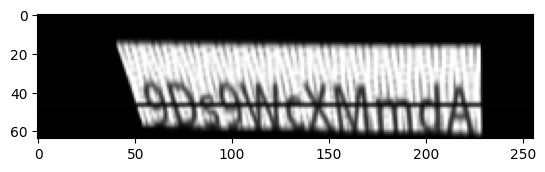

FARMER
torch.Size([40, 1, 256, 64])


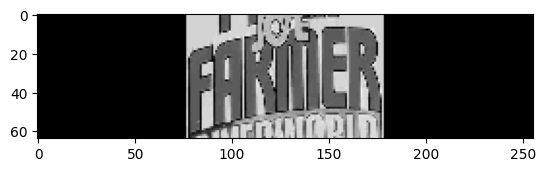

In [219]:
for inputs, targets, _ in test_train_loader:
    for input, target in zip(inputs, targets):
        print(decode_sequence_with_blank(target, **test_data_args['text_params']))
        print(inputs.shape)
        plt.imshow(np.rot90(input.permute(1, 2, 0)), cmap='gray')
        # plt.imshow(input.permute(1, 2, 0), cmap='gray')
        plt.show()
        break   

    break

for inputs, targets, _ in test_val_loader:
    for input, target in zip(inputs, targets):
        print(decode_sequence_with_blank(target, **test_data_args['text_params']))
        print(inputs.shape)
        plt.imshow(np.rot90(input.permute(1, 2, 0)), cmap='gray')
        # plt.imshow(input.permute(1, 2, 0), cmap='gray')
        plt.show()
        break   

    break

In [ ]:
model = CRNN(num_classes, test_data_args['image_params']['channels']).to(device)
print(f"Количество настраиваемых параметров: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

test_train_args = {
    'model': model,
    'model_name': 'CRNN',
    'run_name': 'TEEEEEEEST',
    'description': '',
    'experiment_id': set_experiment(exp_name = "text-recognition-(fixed-targets)"),
    'verbose': True,
    'num_epochs': 200, 
    'learning_rate': 0.001, 
    'train_metric_interval': 5,
    'log_interval': 5,
    'main_metric_name': 'cer',
    'metric_direction': 'min',
    'early_stop_patience': 0,
}
if 'verbose' in test_data_args:
    del test_data_args['verbose']

if type(test_train_args['model'])==str:
    run_id = test_train_args['model'].split('/')[1]
else:
    run_id = None
mlflow.end_run()

with mlflow.start_run(run_id=run_id, 
                      run_name=test_train_args['run_name'], 
                      experiment_id=test_train_args['experiment_id'], 
                      description=test_train_args['description']) as run:
    log_data(train_loader=test_train_loader, df=df, train_args=test_train_args, data_args=test_data_args)
    model = train_model(test_train_loader, test_val_loader, run_id=run.info.run_id, **test_train_args, **test_data_args)

Основная работа

In [58]:
symbols = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz!?"\',.-='
# symbols = sorted(list(set(str.upper(all_symbols))))
blank_symbol = len(symbols)
num_classes = len(symbols) + 1

height = 64
width = 256

data_args = {  
    'data_columns': {
        'image_paths': 'filepath',
        'texts': 'utf8_string',
        'bboxes': 'bbox',
    },
    'filter_params': {
        'symbols': symbols,
        'string_length_range': (3, 15), 
        'height_width_ratio_max': 0.45,   
        'area_min': 5000,                    
        'crop_sizes_min': 5,            
        'coordinates_min': 0,   
    },
    'text_params': {
        'uppercase': False,
        'symbols': symbols,
        'blank_symbol': blank_symbol,
    },
    'image_params': {
        'height': height,
        'width': width,
        'threshold': False,
        'blur': False,
        'channels': 1,
    },

    'transform_train': transforms.Compose([
                            transforms.ToTensor(), 
                            # transforms.Normalize(mean=0.4503, std=0.2371),
                            ResizePadding(width, mode='width'),


                            transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=transforms.InterpolationMode.BILINEAR),
                            transforms.ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1)), 
                            RandomVerticalCompression(compression_coef_range=(0.8, 0.9), p=0.5),
                            transforms.RandomInvert(p=0.5),
                            AddRandomStripes(stripes_num_range=(0,2), stripes_size_range=(1,4)),
                            GaussianNoise(mean=0.0, sigma=(0.01, 0.05), p=0.5),

                            RotateTransform(angle=-90, expand=True),
                            transforms.Normalize(mean=0.5, std=0.5),
                            transforms.Resize((width, height))
                        ]),

    'transform_val': transforms.Compose([
                        transforms.ToTensor(),
                        # transforms.Normalize(mean=0.4503, std=0.2371),
                        ResizePadding(width, centered=True, mode='width'),

                        RotateTransform(angle=-90, expand=True),
                        transforms.Normalize(mean=0.5, std=0.5),
                        transforms.Resize((width, height))  
                    ]),


    'verbose': True,   
    'batch_size': 20,
    'debug': False,
    'train_shuffle': True,
    'prepare_transform': False,
    'use_synthesed_data': False,

    'find_dataset': False,
    'save_dataset': True,
}

train_loader, val_loader = get_dataloaders(df, dataset_path='datasets', **data_args)

Подготовка датасета: 100%|███████| 4971/4971 [00:27<00:00, 183.47it/s]


-yu!BW8y=Q22K
torch.Size([1, 256, 64])


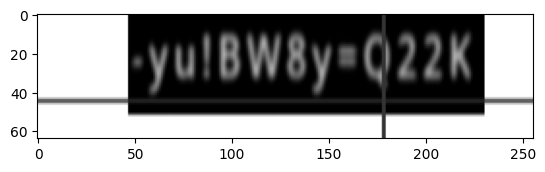

MENDO
torch.Size([1, 256, 64])


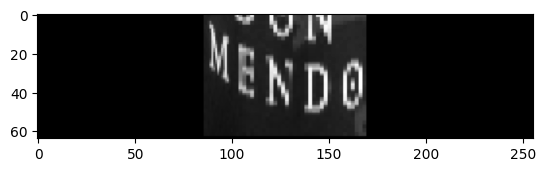

In [223]:
for inputs, targets, _ in train_loader:
    print(decode_sequence_with_blank(targets[2], **data_args['text_params']))
    print(inputs[2].shape)
    plt.imshow(np.rot90(inputs[2].permute(1, 2, 0)), cmap='gray')
    plt.show()
    break
for inputs, targets, _ in val_loader:
    print(decode_sequence_with_blank(targets[2], **data_args['text_params']))
    print(inputs[2].shape)
    plt.imshow(np.rot90(inputs[2].permute(1, 2, 0)), cmap='gray')
    plt.show()
    break

In [107]:
model = CRNN(num_classes, data_args['image_params']['channels']).to(device)
print(f"Количество настраиваемых параметров: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

train_args = {
    'model': model,
    'model_name': 'CRNN',
    'run_name': 'CRNN_infinite_aug_BIGIMAGE_15letters_normalize0.5',
    'description': '',
    'experiment_id': set_experiment(exp_name = "text-recognition-(fixed-targets)"),
    'verbose': True,
    'num_epochs': 200, 
    'learning_rate': 0.001, 
    'train_metric_interval': 5,
    'log_interval': 5,
    'main_metric_name': 'cer',
    'metric_direction': 'min',
    'early_stop_patience': 0,
}
if 'verbose' in data_args:
    del data_args['verbose']

if type(train_args['model'])==str:
    run_id = train_args['model'].split('/')[1]
else:
    run_id = None
mlflow.end_run()

with mlflow.start_run(run_id=run_id, 
                      run_name=train_args['run_name'], 
                      experiment_id=train_args['experiment_id'], 
                      description=train_args['description']) as run:
    log_data(train_loader=train_loader, df=df, train_args=train_args, data_args=data_args)
    model = train_model(train_loader, val_loader, run_id=run.info.run_id, **train_args, **data_args)

Количество настраиваемых параметров: 29108423
Experiment 'text-recognition-(fixed-targets)' already exists with ID: 49


Epoch [1/200]: 100%|████████████████| 994/994 [04:45<00:00,  3.48it/s]


training_loss 1.2253437008656247
Метрики на обучающем датасете:


Calculating Metrics: 100%|██████████| 994/994 [00:57<00:00, 17.44it/s]


Предсказание модели:['CE', 'SE', 'CE', 'CE', 'CAE', 'CE', 'SE', 'CAeiE', 'SE', 'CAAAEE', 'CAAE', 'SE', 'SE', 'SE', 'SE', 'CE', 'CAeIE', 'SE', 'CAeIE', 'CAAEE', 'CE', 'CAE', 'SE', 'SE', 'CAE', 'SE', 'CE', 'SE', 'CAIE', 'CE']
Правильные ответы:['RESOLVE', 'Queues', 'Reserve', 'Gadget', 'Aircalin', 'CIRCUITS', 'LUCU', 'STIMULATION', 'come', 'BIBLIOTHEKS', 'HUNGARIAN', 'Higher', 'SILVER', 'NIKE', 'NEAL', 'EXTANT', 'HARTSPRING', 'CENT', 'Restaurant', 'DAREDEVIL', 'YAHOO!', 'insolven', 'watch', '"LOKET"', 'WARFRONT', 'Heath', 'Edwards', 'BRIAN', 'Economist', 'STARSHIP']
{'cer': 0.9117921844377165, 'wer': 1.0}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 20.37it/s]


Предсказание модели:['SE', 'SE', 'CAEE', 'CAAAE', 'CAE', 'CAAE', 'SE', 'SE', 'CE', 'CAEE', 'CAAiiIE', 'SE', 'CE', 'CAAE', 'SE', 'SE', 'CAAAE', 'CEE', 'CE', 'SE', 'SE', 'CAeeiIE', 'CAAeiEE', 'CE', 'SE', 'SE', 'SE', 'CIiIEE', 'CE', 'CE']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.9124538303211436, 'wer': 1.0}


Epoch [2/200]: 100%|████████████████| 994/994 [04:47<00:00,  3.46it/s]


training_loss 1.0114465729451516
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 20.57it/s]


Предсказание модели:['SAAAE', 'SE', 'CAAIES', 'CAEIIES', 'CAEAINS', 'CAEIIES', 'SAAAE', 'SE', 'SAAAE', 'CAEAINS', 'CAEAINS', 'SAAE', 'SAAAE', 'CAEIIES', 'SAE', 'SE', 'CAEAINS', 'CAEAINS', 'SAAAE', 'SAE', 'SAAAE', 'CEAaeeaaEs', 'CEAEeeIIES', 'SAAAE', 'SAE', 'SAAAE', 'SE', 'CEAEeeIES', 'SAAAE', 'SAAE']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.8986099754701553, 'wer': 1.0}


Epoch [3/200]: 100%|████████████████| 994/994 [05:02<00:00,  3.29it/s]


training_loss 0.9720579885860804
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 20.93it/s]


Предсказание модели:['SOAEEE', 'SOEE', 'CANEIES', 'CANIIES', 'CEENIIES', 'CANIIES', 'SAAEEE', 'SOEE', 'SAEIES', 'CANEIES', 'CEEAIIES', 'SAAEE', 'SANEIES', 'CANIIES', 'SOEE', 'SOEE', 'CEENIIES', 'CANIIES', 'SAEIES', 'SOEE', 'SAAEES', 'CEAaaaaaaEe', 'CEAAIaIIES', 'SAEIES', 'SOEE', 'SAAEEE', 'SOEE', 'CEAAIAIIES', 'SAEIES', 'SOEE']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.9003580793413596, 'wer': 1.0}


Epoch [4/200]: 100%|████████████████| 994/994 [04:54<00:00,  3.37it/s]


training_loss 0.9481171881648857
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.74it/s]


Предсказание модели:['SOEES', 'SOEE', 'CENEEES', 'CRENEEES', 'CRENIiES', 'CRENEEES', 'SOEES', 'SOEE', 'SEEEES', 'CENEEES', 'CRENEiES', 'SOES', 'SENEEES', 'CRENEEES', 'SOEE', 'SOEE', 'CRENIEES', 'CEENEEES', 'SEEEEES', 'TEE', 'SOEES', 'CeeteitiiiES', 'CeEtetiiES', 'SEEEEES', 'SOEE', 'SOEES', 'TEE', 'CeEtetiiES', 'SEEEES', 'SOES']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.9055741957312431, 'wer': 1.0}


Epoch [5/200]: 100%|████████████████| 994/994 [04:53<00:00,  3.39it/s]


training_loss 0.9305691972105076
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 20.20it/s]


Предсказание модели:['SAEIEE', 'SOEE', 'CAEIINS', 'COEEIINS', 'COEEIIeS', 'COEEIINS', 'SAEIEE', 'SOEE', 'SAEIIE', 'COEEIINS', 'COEEIIeS', 'SAIEE', 'SAEIIE', 'COEEIINS', 'SOEE', 'SOEE', 'COEEIIeS', 'COEEIINS', 'SAEIIE', 'TOE', 'SAEIEE', 'COeteitiiiIes', 'COEtetiiies', 'SAEIEE', 'SOEE', 'SAEIEE', 'BOEE', 'COetetiiies', 'SAEIEE', 'SAIEE']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.8986099754701553, 'wer': 1.0}


Epoch [6/200]: 100%|████████████████| 994/994 [05:05<00:00,  3.25it/s]


training_loss 0.9249592230953201
Метрики на обучающем датасете:


Calculating Metrics: 100%|██████████| 994/994 [01:03<00:00, 15.69it/s]


Предсказание модели:['SARIIS', 'TOE', 'SEARIIeS', 'SAIES', 'SARIINS', 'SAAAINS', 'SARIES', 'SARIINS', 'SAAIIS', 'CEARIINS', 'SAEE', 'SAEE', 'SARIES', 'SAIES', 'SAIES', 'CERRIIeS', 'SARIINS', 'CEAAIIINS', 'SEARIINS', 'SARIES', 'SARIINS', 'SAAES', 'SANEE', 'CEAAIIINS', 'SARIINS', 'SARIES', 'SAIES', 'SARIINS', 'SAAIINS', 'SAIES']
Правильные ответы:['twitter', 'SEA', "SCRIBNER'S", 'KARLOFF', 'MANGONS', 'CONGRESS', 'LAWSON', 'Pavilion', 'MICHAEL', 'Quesadillas', '1969', 'ealth', 'OORLOG', 'LAURIN', 'PARIS', 'LITERATURE', 'Grinders,', 'MERENGONES', 'Brooklyn', 'SIMPLE.', 'MULTISOM', 'SINCE', 'GINGE', 'TANGDSAION', 'Microsoft', 'LONDON', 'TUNNEL', 'PANERAI', 'STREET,', 'Denon,']
{'cer': 0.8965207190373498, 'wer': 1.0}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 20.21it/s]


Предсказание модели:['SAAES', 'SAAEE', 'SARIINS', 'SEARIIES', 'SEARIIES', 'SEARIIES', 'SAAES', 'SAEE', 'SARIINS', 'SARIINS', 'CEARIINS', 'SAAES', 'SARIINS', 'SEARIIES', 'SAEE', 'SAEE', 'SEARIIES', 'SEARIINS', 'SARIINS', 'TOE', 'SAAES', 'CEeiIIIIInS', 'CEARIIIiIeS', 'SARIINS', 'SAEE', 'SAAES', 'SAEE', 'CEeeIIIIInS', 'SARIINS', 'SAAES']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.9030648208193532, 'wer': 1.0}


Epoch [7/200]: 100%|████████████████| 994/994 [05:02<00:00,  3.28it/s]


training_loss 0.9054167324028745
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.67it/s]


Предсказание модели:['SOIES', 'SOEEE', 'CAENRIee', 'CAEEEIES', 'CEEEIEIIES', 'CAEEEIES', 'SOEEe', 'SOEE', 'SENEEES', 'SAENEIES', 'Caeeeaies', 'SOEEe', 'SENEEES', 'CAENEies', 'SOEEE', 'SOEEE', 'CEEEIEIIES', 'Ceeneiee', 'SeaEEeS', 'TOE', 'SOEES', 'CAEEINEINIns', 'CeeEEEIIIes', 'SENEEeS', 'SOREE', 'SOEES', 'SOEE', 'CeetetIiIes', 'SENEEES', 'SOEES']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.8935630304226464, 'wer': 1.0}


Epoch [8/200]: 100%|████████████████| 994/994 [04:59<00:00,  3.32it/s]


training_loss 0.841901541505781
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 20.03it/s]


Предсказание модели:['SOIES', 'SOee', 'COORRIES', 'CAORRIES', 'CAREIIIIES', 'CAORRIES', 'SOOES', 'SOee', 'SORIIES', 'CeeeRIES', 'Ceeeertes', 'Seeee', 'SORIIES', 'CAORRIES', 'SOES', 'SOOES', 'CAREIIIIES', 'Caeeries', 'SORRIES', 'SOE', 'Seeee', 'CeRTR-R-AiI.', 'COOEEIAIIE.', 'SORRIeS', 'SOES', 'SOIES', 'SOEE', 'CAOEIIIIIE.', 'SORIIES', 'SOIES']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.8756026729072095, 'wer': 1.0}


Epoch [9/200]: 100%|████████████████| 994/994 [05:07<00:00,  3.23it/s]


training_loss 0.8001135283672594
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 19.63it/s]


Предсказание модели:['SARIES', 'SOee', 'Sateies', 'CAATIIES', 'CAAEEIIIES', 'CoAERIES', 'SARRES', 'SOES', 'SARRIES', 'CAARIIES', 'Conneaties', 'Saiee', 'SARIEES', 'CAAERIES', 'SAAES', 'SAAES', 'CAREEIIIES', 'Coataiee', 'SARRIES', 'SOOE', 'Saaiie', 'Contitaatian,', 'Conteeaaie.', 'SAnRIeS', 'SOES', 'SARIES', 'BOEE', 'CARTEIIIIES', 'SARIIES', 'SARIES']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.866439225195252, 'wer': 1.0}


Epoch [10/200]: 100%|███████████████| 994/994 [05:05<00:00,  3.25it/s]


training_loss 0.7761304845032797
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 20.97it/s]


Предсказание модели:['SARIES', 'SAIEE', 'Moenenns', 'CORRRINS', 'CERNIIINS', 'CORRRINS', 'SAeES', 'SAEE', 'SARIINS', 'SOARIINS', 'Coenains', 'Moiee', 'SARIINS', 'Coeeiins', 'SAIEE', 'SAEEE', 'CERREIIINS', 'Connannns', 'SERIINS', 'SEAE', 'Seiiee', 'Cortiiiiii,', 'CorEEitin.', 'SeniIns', 'Soee', 'SARIES', 'SOEE', 'COREEEIINS', 'SANIINS', 'SARIES']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.8653678066935461, 'wer': 1.0}


Epoch [11/200]: 100%|███████████████| 994/994 [05:07<00:00,  3.23it/s]


training_loss 0.7547852470421456
Метрики на обучающем датасете:


Calculating Metrics: 100%|██████████| 994/994 [01:04<00:00, 15.37it/s]


Предсказание модели:['SANAES', 'SONRIES', 'SOOE', 'CAAAENS', 'SANIES', 'SAERNNS', 'Careiiies', 'Ciliiiies', 'SOREEES', 'SORES', 'SAAES', 'CAAERNES', 'SONRNNS', 'SAAES', 'Maaee', 'CAEAIES', 'partiiiies', 'Ceriiee', 'Careiies', 'SAAEE', 'CAAEAEON', 'SOREEES', 'CAAEEEAIOS', 'Ciliiiies', 'SONOES', 'CAERNES', 'TOE', 'Caeerine', 'Sereee', 'SAEE']
Правильные ответы:['PIETRO', 'Fragmin', 'PULL', 'MAGICAL', 'EXTREME', 'AMERICA', 'necessary', "Webster's", 'senses?', 'CLOSED', 'FLOYD', 'FIREHAWK', 'MONTHLY', 'GUZZI', 'Beer', "STONE'S", 'condensate', 'Journey', 'gunpowder', 'ONLY', 'PASSAGES', 'ABSOLUT', '030000334876', 'Trappistes', 'MIFUNE', "STEWIE'S", 'ARE', 'families', 'Granat', 'VOGT']
{'cer': 0.8576957929711921, 'wer': 1.0}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:13<00:00, 18.96it/s]


Предсказание модели:['SONRES', 'SOEEE', 'COOERNEN', 'CAAEAIAS', 'CAAEEAAINS', 'CAAEAIOS', 'SAEees', 'SOOES', 'SOERES', 'COONRIES', 'CORERIOS', 'Meriee', 'SAEOEES', 'COOeRIOS', 'SOOES', 'SOOES', 'CORNERNINN', 'Careanne', 'SONREES', 'SOAE', 'Meriee', 'CORTEAEAAIOS', 'Careeatie.', 'SAieens', 'Soee', 'SOREES', 'SOEE', 'COREERAIOS', 'SAEIES', 'SAARES']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.8538359601883441, 'wer': 1.0}


Epoch [12/200]: 100%|███████████████| 994/994 [05:09<00:00,  3.21it/s]


training_loss 0.7311400455728143
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 20.88it/s]


Предсказание модели:['SORRES', 'SAEE', 'Coemenns', 'CRRERIES', 'COREIATES', 'CAeiaanS', 'SeEeee', 'Seee', 'SORIES', 'SOORIAES', 'Coeeerans', 'Seeiee', 'SORRES', 'Coeeains', 'SOREE', 'SOREE', 'CORNRRIEN', 'Coeeennn', 'SOREEE', 'SESAE', 'Seeiee', 'wonteeiitin,', 'Coeeeesains', 'Seieens', 'meee', 'SOEEES', 'SOEE', 'CoeTenRtins', 'SALIES', 'SAEIES']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.8472100826120055, 'wer': 1.0}


Epoch [13/200]: 100%|███████████████| 994/994 [05:19<00:00,  3.11it/s]


training_loss 0.7096714321636338
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:14<00:00, 17.44it/s]


Предсказание модели:['SORRES', 'SAEES', 'SOOORINS', 'CORAERIES', 'CRREEIAINS', 'CAAERINS', 'SAAEES', 'SORES', 'SORRINS', 'SORNIANS', 'CORRRRANNE', 'Seeiee', 'SANRAAS', 'CORRRINS', 'SONNS', 'SOEES', 'CORNRRINNN', 'Coatennn', 'SORIEAS', 'SAAE', 'Saeaee', 'IORTONIAA.N.', 'CARERRAAINS', 'SOERIES', 'Soeee', 'SOREES', 'WOLE', 'IORERNRAINN', 'SAAIINS', 'SAARES']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.8446443172526574, 'wer': 1.0}


Epoch [14/200]: 100%|███████████████| 994/994 [04:57<00:00,  3.35it/s]


training_loss 0.6879831283565019
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 20.61it/s]


Предсказание модели:['COEOES', 'SOEES', 'COOOOeeS', 'COLLEIES', 'COREEIALES', 'CAAERIOS', 'CAiaES', 'SAOES', 'COIOION', 'COOORAES', 'Coreeaanes', 'Moaiee', 'COIOEAS', 'Coreaies', 'SOOOE', 'SOEES', 'COONOOOOON', 'Conioonn', 'COEEEAS', 'MAAE', 'Moaiee', 'Conn-nn----nn', 'COREOETIES', 'COEEEES', 'Coees', 'SORIES', 'WoLE', 'COOLOO-IOS', 'AALIINS', 'SALIEE']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.8317027095610003, 'wer': 1.0}


Epoch [15/200]: 100%|███████████████| 994/994 [04:12<00:00,  3.94it/s]


training_loss 0.6627342014365513
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 20.55it/s]


Предсказание модели:['SOTOEE', 'SEOT', 'SOOeeees', 'Caliiant', 'SAAAIEAAAE', 'AAAAAION', 'SAAIes', 'SEOe', 'SAIIIIA', 'SOONIEEE', 'Seneennet', 'Saaiee', 'SAIIAAE', 'Caneiine', 'SAUNE', 'SEEES', 'COOTOIIINN', 'Santaone', 'SEEEEES', 'SEE', 'Seatee', 'IOOATIIIIEEON', 'SAETEETIES', 'SEEeees', 'Soed', 'SEIAEE', 'SoLk', 'POOLOILIIN', 'SALIINS', 'SALIEE']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.8100769729607804, 'wer': 1.0}


Epoch [16/200]: 100%|███████████████| 994/994 [03:18<00:00,  5.00it/s]


training_loss 0.6182668094393953
Метрики на обучающем датасете:


Calculating Metrics: 100%|██████████| 994/994 [01:05<00:00, 15.10it/s]


Предсказание модели:['SOOEE', 'DOONNENS', 'CETIINN', 'COMNINN', 'CARAEESEES', 'SOREENN', 'TEEE', 'Aoe', 'coleeeaatien', 'TOLLET', 'SEARAEES', 'MANNT', 'DOLE.', 'MANE', 'Mileeetiinn', 'Ceseninn', 'Meeien', 'MAEE', 'SASIEE', 'SAAAAAE', 'SOOOT', 'SAEE', 'CAENeEt', 'SAAEN', 'CIEEAIES', 'SEEEES', 'AAALE', 'SAAET', 'Meeeioees', 'MAAEAANES']
Правильные ответы:['BUNNY', 'DERNIERS', 'VERDUGO', 'WARFRONT', 'ACCESSORIES', 'AKWAABA', 'RISK', 'Ans', 'Collaboration', 'OUTLET', 'SEPARATE', 'TERRY', 'KISSFM', 'ANNE', 'MicrosoftOEM', 'medellin', 'Angkor', 'ANNE', 'STATIC', 'COMPASS', 'WOMEN', 'STAR', 'LLBEING', 'WIZARD', 'DROP-OFF', 'PEPPER', 'TIME', 'MEDINA', 'Wordpress', 'APPEARANCE']
{'cer': 0.7994338177961041, 'wer': 0.9990442655935614}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 20.19it/s]


Предсказание модели:['CEEOES', 'WAAOT', 'Moureees', 'CAAEETOON', 'CONNNAAAAN', 'MAANAINN', 'SAAAES', 'SAOe', 'SONTOON', 'SOOANEES', 'COOOIrNON', 'Soniee', 'AANIAAE', 'COONNINN', 'AOOON', 'WIEEE', 'COOROOOOON', 'Condoone', 'AENLEES', 'SESEE', 'Seeton', 'CONNAONIIE.NN', 'CAATEIAIeS', 'SAAeeee', 'Donet', 'SORRES', 'SOLE', 'COLLIOILLENN', 'SAAAINS', 'SALIOT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.7843629289198409, 'wer': 0.99979883323275}


Epoch [17/200]: 100%|███████████████| 994/994 [04:44<00:00,  3.50it/s]


training_loss 0.5539921285131088
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.76it/s]


Предсказание модели:['CEEIES', 'WEAER', 'Miieaees', 'PEEEEETON', 'WOLAIAAAAS', 'MAANAION', 'SAAIeS', 'Siine', 'AONeeON', 'SAAAIEES', 'Carneaiiet', 'Soniee', 'AINTLAE', 'COniiaNN', 'AAUON', 'DIEL.', 'MRREENIION', 'Somdaane', 'AEEELES', 'COSOOEY', 'Ceeten', 'POw.LIIIEL.IS', 'PARTEaties', 'SAEiiNs', 'Moaed', 'SONENS', 'WOLE', 'IOLLIIIL.AIN', 'SALAINS', 'SALAET']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.7543632108720782, 'wer': 0.9971836652584993}


Epoch [18/200]: 100%|███████████████| 994/994 [04:03<00:00,  4.08it/s]


training_loss 0.4819829866544941
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 24.11it/s]


Предсказание модели:['TESUeS', 'REAES', 'Siiorees', 'PEEETTTY', 'RORNNEILAS', 'MAARRiON', 'SAAOES', 'Siior', 'LUNSON', 'SERMIEES', 'SeererIel', 'Bonbee', 'AITTINS', 'Rorision', 'AEUOT', 'WOEL.', 'NORRERREY', 'Soptrone', 'AIREEES', 'TEET', 'Teeten', 'www..niiet..o.', 'SERTEaRTieS', 'SARRINS', 'Maeet', 'SAEIS', 'Nelk', 'RER-N0--..00', 'SALAINS', 'SLLTOT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.707643725152959, 'wer': 0.9917521625427479}


Epoch [19/200]: 100%|███████████████| 994/994 [04:12<00:00,  3.93it/s]


training_loss 0.4129049610758811
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 20.64it/s]


Предсказание модели:['TesUeR', 'WENOO', 'Siiorees', 'DEEESTTOY', 'DRRAIRTLAD', 'DAAEERNON', 'SAAORE', 'Ciinr', 'LOnsOOY', 'BEANTEER', 'Rrrreraied', 'Conbee', 'AIIOIAS', 'Conrsaon', 'AEUOT', 'DIELD', 'WOORCNOON', 'Sonpomne', 'AIEEEES', 'TEET', 'Peeten', 'www.Aninet.oom', 'CEAEETTOon', 'BEAONNN', 'hoeed', 'CANRNS', 'Ne1k', 'WRRLN0-L.90m', 'CLLMONS', 'BLTOY']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.6712436913186907, 'wer': 0.9903439951719976}


Epoch [20/200]: 100%|███████████████| 994/994 [04:13<00:00,  3.93it/s]


training_loss 0.32651685493500127
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 22.03it/s]


Предсказание модели:['LEEIER', 'HEUOO', 'Shorress', 'PEEETETT', 'DOANTETLED', 'CAAEANOE', 'SANURE', 'Lonne', 'LOASET', 'RRANOEER', 'Aearerrrd', 'Boitrs', 'AUTTLLS', 'Corrseoy', 'AROOT', 'TIELD', 'NOORCNOON', 'sortoone', 'AIGELES', 'TOET', 'Desten', 'MwU.LnIIET.TIT', 'AEREERTENS', 'SENOEES', 'Maeet', 'CINTIO', 'NOLE', 'WORLIORL..Om', 'SLAAOS', 'ELLTIT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.6203513124876646, 'wer': 0.9853148259907464}


Epoch [21/200]: 100%|███████████████| 994/994 [04:18<00:00,  3.85it/s]


training_loss 0.21603638273379222
Метрики на обучающем датасете:


Calculating Metrics: 100%|██████████| 994/994 [00:53<00:00, 18.49it/s]


Предсказание модели:['STSTRN', 'TITE', 'PROCORTTY', 'DOOLONNG', 'LIRRARY', 'Hhlooien', 'OHESA', 'SUUTOOY', 'CHAAAATO', 'SONE', '200R', 'STOD', 'yerls', 'BLREK', 'Cannaden', 'RECEEAANNT', 'SOaoonm', '2OOA', 'HACOOY', 'BOEESEAR', 'TOOO', 'MEEEIINS', 'ROOR', 'PORNORE.', 'AAEA', 'BRRE', "SENON'S", 'TNNRNNRE', 'Steenmonds', 'WART']
Правильные ответы:['SYSTEM', 'ELLE', 'PROSPERITY', 'BUILDING', 'LIBRARY', 'Ethiopian', 'OMEGA', 'SUNTORY', 'GYMNASIO', 'SOME', '2008', 'SEO2', 'years', 'BLACK', 'Canadian', 'DIFFERENT', 'SagoSom', 'CORA', 'CACIQUE', 'PIZZERIA', 'VODKA', 'PRESDENT', 'HOOD', 'PORTUGAL', 'AREA', 'FREE', 'SENIORS', 'INNOCENCE', 'Steamworks', 'PRET']
{'cer': 0.6095450171048842, 'wer': 0.9768108651911469}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.68it/s]


Предсказание модели:['LEEDCR', 'HENDR', 'Shooeees', 'PREEOEAY', 'DRAAIAALER', 'CARRAOOE', 'SAAOCE', 'Hane', 'LORsOON', 'RRNNOEER', 'Haarrruund', 'Ronhee', "AIIIA'S", 'Fanrsaon', 'AROOT', 'DIELD', 'WOOOHORRN', 'sundoone', 'MIGEEES', 'CEOT', 'Desten', 'www.-MiN--.oUN', 'PARREAAAES', 'RANOEES', 'waeed', 'PAAOee', 'NOLR', 'WOw-D09-.900', 'SLLANS', 'FLLORT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.5605774381819719, 'wer': 0.9666063166364917}


Epoch [22/200]: 100%|███████████████| 994/994 [03:48<00:00,  4.36it/s]


training_loss 0.10097963594351576
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.03it/s]


Предсказание модели:['TEEDnR', 'HENDG', 'Shooraes', 'PREEOEAT', 'TEANEALEY', 'CARCNONE', 'SRNDeE', 'Taiar', 'Lalaarr', 'RRNNDEER', 'Fiavrund', 'Forhes', 'ATTIAAS', 'Levrsaan', 'AROUT', 'UIELD', 'WORONOTH', 'Smmioone', 'ACCELES', 'CEEET', 'Desten', 'wwu.Aninat.oiy', 'SeEeeEAIES', 'SETOEAS', 'wneet', 'PHNUIO', 'YOLE', 'wwwLnO-.com', 'SLLNNDS', 'FLLGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.4894126934897228, 'wer': 0.935827801247234}


Epoch [23/200]: 100%|███████████████| 994/994 [04:44<00:00,  3.49it/s]


training_loss -0.009688229616036895
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 20.95it/s]


Предсказание модели:['EEEDeR', 'YEDG', 'Shoorass', 'PRASDENT', 'ORAALAALLES', 'BAREENONE', 'SRADGE', 'Fiiar', 'Lalsan', 'RRANDEER', 'Frrvrouad', 'Forhes', 'ATTIAAS', 'Horrsaam', 'ABUUT', 'DIELD', 'WOROSHOTH', 'smnirone', 'ANGELES', 'CeET', 'Desien', 'www..aimks.olr', 'CeAeeAoiES', 'BAROEES', 'wweed', 'PIAAID', 'WOLC', 'www-noB.com', 'SLANDS', 'FLLGRT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.43180985141117095, 'wer': 0.903842285254476}


Epoch [24/200]: 100%|███████████████| 994/994 [04:43<00:00,  3.50it/s]


training_loss -0.1123063367558936
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 19.93it/s]


Предсказание модели:['EEEDER', 'HENDO', 'Shooense', 'PRESDENT', 'ORMNLVALES', 'GAPENONE', 'SRIDDE', 'Taior', 'LOASOOT', 'RAAIDEER', 'Flovrrund', 'Forhes', 'ANTIONS', 'CovNERan', 'ABOUT', 'DTELD', 'WORDSNOOTH', 'Snndrone', 'ANGELES', 'CEEET', 'Destsn', 'www.tninkS.oIr', 'Peononnaies', 'SETOIES', 'wweet', 'PIILRR', 'VOLP', 'WHw-mOB.cOm', 'SLANDDS', 'FLLGRT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.396678602644712, 'wer': 0.8617984308992155}


Epoch [25/200]: 100%|███████████████| 994/994 [03:48<00:00,  4.35it/s]


training_loss -0.1852197205906423
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 24.17it/s]


Предсказание модели:['EEEMGR', 'HENDO', 'Shooease', 'PRESIDENT', 'CRMMEALSS', 'BARGENONE', 'SRIDGE', 'FARS', 'Caasann', 'RANNDEER', 'Plavrround', 'Forhes', 'ANTIGAS', 'HevvFaan', 'ABOUT', 'DTELS', 'WORDSWOTH', 'Snndrone', 'ANCELES', 'COEOL', 'Desssn', 'www.nninss.olr', 'TERRERREIAE', 'RECOEEE', 'wweed', 'PIRRIR', 'WOLF', 'WwW.-mOe.com', 'SLANNDS', 'FLLGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.3518763921391716, 'wer': 0.8062764031382016}


Epoch [26/200]: 100%|███████████████| 994/994 [03:09<00:00,  5.26it/s]


training_loss -0.2609576796239122
Метрики на обучающем датасете:


Calculating Metrics: 100%|██████████| 994/994 [00:57<00:00, 17.27it/s]


Предсказание модели:['TeOonN', 'HORSE', 'ierrdured', 'DAMML', 'absslutely', 'DODSSCEWAR', 'ANNMAL', 'areaday', 'WAMN', 'FOR', 'DART', 'Champgnet', 'FRANCFYRTE', 'WANGHSIIT', 'CODE', 'ALLLRBRN', 'WOST', 'CORAAGE', 'Frand', 'INNIDENTE', 'Voang', 'JULLO', '1.00', 'SANTT', 'FORtom', '1NE', 'pertect', 'MOMECR.NNr', 'Tr1-', 'BrosIL']
Правильные ответы:['PGOPLE', 'HORSE', 'introduced', 'DALMA', 'absolutely', 'DOODSGEVAAR', 'ANIMAL', 'already', 'HAIR', 'FOR', 'n.y.', 'Champagne,', 'FRANCOFVRTI', 'MANCHESTER', 'CODE', 'COLUMBIA', 'MOST', 'COURAGE', 'Frank', 'INVIDENTE', '!bang', 'JULIO', '1,200', 'power', 'FOLLOW', 'TIME', 'perfect', 'MEMBERSHIP', 'Tri-', 'BRASiL']
{'cer': 0.3878137358893486, 'wer': 0.8436619718309859}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.33it/s]


Предсказание модели:['TuEMeR', 'WENDD', 'Shooease', 'PRESIDENT', 'CRAMLVALLSY', 'BARGMONE', 'SRIDGE', 'Tinr', 'LAASRn', 'RAINDEER', 'Plavground', 'Forhes', 'ANTIGAS', 'Vevitian', 'ABUT', 'DTELD', 'WOROSWOOTH', 'Snndrrome', 'ANCELES', 'COEL', 'Desien', 'www.wiin..com', 'TernonnoinS', 'PEFORNL', 'wweet', 'PITAP', 'WOLF', 'WWW-mOe.com', 'SLANDDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.33729946147122675, 'wer': 0.7950110641721988}


Epoch [27/200]: 100%|███████████████| 994/994 [03:19<00:00,  4.99it/s]


training_loss -0.3140301438366106
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.81it/s]


Предсказание модели:['TEEmER', 'WENDE', 'Shooease', 'PRSSIDENT', 'CRIMINALSS', 'BAREEMONE', 'SRIDGE', 'THRrr', 'CHAERn', 'RANNDEER', 'Plavgrund', 'Forhes', 'ANTIGAS', 'VeVvERAn', 'ABOUT', 'OIELD', 'WORDWOOTH', 'Snndrome', 'ANGELES', 'EAET', 'Desisn', 'www..m...om', 'TETMOREaIOS', 'REOORNS', 'Aweet', 'PHILRP', 'WOLF', 'wWW.-mo8.com', 'SSLNDDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.30247836016578794, 'wer': 0.7312411989539328}


Epoch [28/200]: 100%|███████████████| 994/994 [04:14<00:00,  3.90it/s]


training_loss -0.3663470955010857
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:13<00:00, 18.43it/s]


Предсказание модели:['LEEmnR', 'HENDD', 'Showease', 'PRESIDENT', 'CRIMLVALSS', 'BAREEMONE', 'SRIDGE', 'Tiinr', 'Ciaaaan', 'RANNDEER', 'Plavground', 'Forhes', 'ANIIGAS', 'Hevitian', 'ABOUT', 'DIELT', 'WORDSWORTH', 'Snndrrome', 'ANGELES', 'EREIOT', 'Desisn', 'www.mimnst.iom', 'EErManEates', 'REEOEER', 'Aweet', 'PIILAP', 'NOLT', 'www.-moet.com', 'SLLNNDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.27834324865367804, 'wer': 0.6849728424864212}


Epoch [29/200]: 100%|███████████████| 994/994 [04:48<00:00,  3.45it/s]


training_loss -0.4109493345753018
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.37it/s]


Предсказание модели:['-usmeR', 'HENDE', 'Shooease', 'PRESIDENT', 'CRIMLWALLS.', 'BAREEMONE', 'SRIDGE', 'Tais', 'CiASRan', 'RRINDGER', 'Playground', 'Forhes', 'ANTIGAS', 'Leveatian', 'ABOUT', 'DIELD', 'WORDSWOOTH', 'Syndrrome', 'ANGELES', 'EEEN', 'Design', 'www.miinR..oOm', 'TEEmenEaION', 'REEOEEY', 'Aweet', 'PIILAP', 'WOLF', 'www-moet.com', 'SLLNDDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.2615388953111343, 'wer': 0.6543954938644136}


Epoch [30/200]: 100%|███████████████| 994/994 [04:02<00:00,  4.10it/s]


training_loss -0.445101132241623
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.58it/s]


Предсказание модели:['ZwEmeR', 'MENDD', 'Showease', 'PRESIDENT', 'GRINLVALSS', 'BAREEMONE', 'BRIDGE', 'Tair', 'Caasaon', 'RRINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Vevafian', 'ABOUT', 'Oieto', 'WORDSWOTH', 'Snndrrome', 'ANGELES', 'EEEE', 'Design', 'wwmmmimt.com', 'vermentates', 'REEORIE', 'Aweet', 'PAROAP', 'WOLF', 'www..moet.com', 'ISAANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.26881326303324216, 'wer': 0.652383826191913}


Epoch [31/200]: 100%|███████████████| 994/994 [05:00<00:00,  3.30it/s]


training_loss -0.4754867514232792
Метрики на обучающем датасете:


Calculating Metrics: 100%|██████████| 994/994 [01:00<00:00, 16.56it/s]


Предсказание модели:['FECHSHOP', 'PHAAS', 'SURFACE', 'FASHION', 'WAMOUUA', 'Cocecel.', 'CLTTB', 'CUILTY', 'Ranger', 'iada', 'ATTERNOON,', 'Oiatenicdh', 'BONONTAR,', 'GOFFEE', 'HRRPSICHORD', 'FREE', 'Laberintno', 'RIGHT', 'Nerrttenty', 'Luney', 'uppto-date', 'WHRTLE', 'ippowesr', 'CRIEE?', 'Peuuuainns', 'Crribie', 'MAAGGUX', 'WiLEE', 'NEOIVELLD', 'CLARK']
Правильные ответы:['TECHSHOP', 'Wild"', 'SURFACE', 'FASHION', 'PINTURA', 'CocaCola.', 'CLIMB', 'GUILTY', 'Ranger', 'Indu', 'AFTERNOON,', 'Stakeholder', 'BONONIAE,', 'COFFEE', 'HARPSICHORD', 'FREE', 'Laberintho', 'RIGHT', 'Neurotoxicity', 'Library', 'up-to-date', 'MYRTLE', 'gunpowder', 'CRIME?', 'populations', 'terrible', 'MARGAUX', 'EAGLE', 'REDWELD"', 'CLARK']
{'cer': 0.2789746903910591, 'wer': 0.6920020120724346}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 20.85it/s]


Предсказание модели:['ZuEmer', 'MENDO', 'Showease', 'PRESIDENT', 'CRINLNALLSS', 'BAREMONE', 'SRIDGE', 'Tiirr', 'CiAAE0n', 'RAINDEER', 'Plavground', 'Forhes', 'ANTIGAS', 'Leviatzan', 'ABOUT', 'DIELO', 'WORDSWOOTH', 'Snndrrome', 'ANGELES', 'EOEET', 'Design', 'www.nnind.oom', 'COrmentECTES', 'REFOETE', 'Aweet', 'PHTLPP', 'WOLF', 'www.moet.com', 'ISLNDDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.2435221473482392, 'wer': 0.6226111446389057}


Epoch [32/200]: 100%|███████████████| 994/994 [03:52<00:00,  4.28it/s]


training_loss -0.5049505157984598
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.75it/s]


Предсказание модели:['ZEEmeR', 'MENDG', 'Shooease', 'PRESIDENT', 'GRIMVALLSE', 'BARGEMONE', 'SRIDGE', 'Tiicr', 'Liisaon', 'RAINDEER', 'Plavground', 'Forhes', 'ANTIGAS', 'Levifian', 'ABOUT', 'DIELO', 'WORDSWOTH', 'Syndrrome', 'ANGELES', 'EIEY', 'Design', 'wwNNimint.oor', 'rarmannatoe', 'REEORTT', 'sweet', 'PIIEIP', 'WoLr', 'www.moet.com', 'SSLNNDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.23114444413116417, 'wer': 0.5896197948098975}


Epoch [33/200]: 100%|███████████████| 994/994 [04:24<00:00,  3.76it/s]


training_loss -0.521464582713006
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.71it/s]


Предсказание модели:['ZAEmER', 'MENDO', 'Showcase', 'PRESIDENT', 'CRINNALLS.', 'BARREMONE', 'SRIDGE', 'Tiiar', 'CAAAAOn', 'RANNDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviatian', 'ABOUT', 'DIELL', 'WORDSWOOTH', 'Syndrome', 'ANGELES', 'NREE', 'Design', 'wuwNmminkt.com', 'POrMenatER', 'REEOETE', 'Aweet', 'PHILAP', 'HOLF', 'www..moet..om', 'SLANDDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.22750726027011026, 'wer': 0.5870046268356468}


Epoch [34/200]: 100%|███████████████| 994/994 [04:30<00:00,  3.68it/s]


training_loss -0.5531792908333527
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.17it/s]


Предсказание модели:['ZusmeR', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMLVALLS.', 'BARGEMONE', 'SRIDGE', 'TAann', 'CiaaRn', 'RANNDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Levaatian', 'ABOUT', 'OTEL7', 'WORDWORTH', 'Snndrrome', 'ANGELES', 'EINN', 'Design', 'www.mminki.com', 'rarmentaties', 'REEORTA', 'Aweet', 'PHOLAP', 'WOLF', 'wwwmmoet.com', 'SLANDDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.22090957791750077, 'wer': 0.5676926171796419}


Epoch [35/200]: 100%|███████████████| 994/994 [04:26<00:00,  3.73it/s]


training_loss -0.5718541401878778
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:13<00:00, 18.77it/s]


Предсказание модели:['ZEEmeR', 'MENDE', 'Showease', 'PRESIDENT', 'CRINLYALLS.', 'BAREEMONE', 'SRIDGE', 'Taire', 'LiAMRnn', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviatran', 'ABOUT', 'OTELD', 'WORDSWORTH', 'Syndrrome', 'ANGELES', 'EEEc', 'Design', 'www..iinss.com', 'EeEmEnatNS', 'REEOETA', 'Aweet', 'PHOLEP', 'WOLF', 'www.moet.ccom', 'ISLNNDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.21473482392082782, 'wer': 0.5620599476966405}


Epoch [36/200]: 100%|███████████████| 994/994 [04:49<00:00,  3.44it/s]


training_loss -0.5928385109983579
Метрики на обучающем датасете:


Calculating Metrics: 100%|██████████| 994/994 [01:04<00:00, 15.44it/s]


Предсказание модели:['IRAG', 'INCHES', 'Chrisste', 'KOPHOUSE', 'Rochefrrt', 'Nurturesshock', 'PADINGTON', 'PREMIUM', 'oiglnal', 'SUTTIEEA', 'CEPRAAND', 'MONTIKS', 'POTLETA', 'Dooaiss', 'INURRIEETA', 'ENSEMBLE', 'BELLO', 'HONE', 'FUURRGUS', 'STATES', 'SwettateR', 'NACHRRUHE', 'NINNERAEF', 'Sang', 'GREENGATE', 'Miee', 'FOtiWW', 'FELLA.....', 'BERINGER', 'NNEGAN']
Правильные ответы:['IRAQ', 'INCHES', 'Christie', 'HOP-HOUSE', 'Rochefort', 'NurtureShock', 'PADDINGTON', 'PREMIUM', 'original', 'SUTILBZA', 'C.D.RAND', "MONTH'S", 'TUVWXYZ', 'Discuss', 'INURRIETA', 'ENSEMBLE', 'BELLO', 'HOME', 'PLURIBUS', 'STATES', 'Sketchbook', 'NACHTRUHE', 'MINIMARKET', 'Sang', 'GREENGATE', 'Mrs.', 'FOLLOW', 'FELLA....', 'BERINGER', 'VINEGIA,']
{'cer': 0.22342420815274275, 'wer': 0.5921529175050302}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 19.26it/s]


Предсказание модели:['ZuEmeR', 'MENDE', 'Showcase', 'PRESIDENT', 'CRIMLNALLSE', 'BAREEMONE', 'SRIDGE', 'THMRr', 'Caaaann', 'RAINDEER', 'Playground', 'Forhes', 'ATTIGAS', 'Leviatran', 'ABOUT', 'OIELO', 'WORDSWORTH', 'Syndrrome', 'ANGELES', 'EEEEI', 'Design', 'www.miinst.oom', 'CErmEEEatER', 'REEGETE', 'Aweet', 'PHLLEP', 'WOLF', 'www.moet.com', "SLANN'S", 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.21027997857162997, 'wer': 0.5495876081271374}


Epoch [37/200]: 100%|███████████████| 994/994 [03:50<00:00,  4.31it/s]


training_loss -0.6068732175953552
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.65it/s]


Предсказание модели:['ZuEmeR', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'SRIDGE', 'THine', 'Ciasapn', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviatran', 'ABUT', 'OTELO', 'WORDSWORTH', 'Syndrrome', 'ANGELES', 'EOEA', 'Design', 'www.miinst.com', '-OT.EnECTLOS', 'ALECETE', 'sweet', 'PHHLLP', 'YOLF', 'www..moet.com', 'SSLNNDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.20159584966306707, 'wer': 0.5256487628243814}


Epoch [38/200]: 100%|███████████████| 994/994 [03:51<00:00,  4.30it/s]


training_loss -0.6194837368159017
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 20.53it/s]


Предсказание модели:['ZuEmeR', 'HENDE', 'Shooease', 'PRESIDENT', 'CRIMINALSE', 'BAREEMONE', 'SRIDGE', 'Waiie', 'CA8E80n', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviatran', 'ABUT', 'OTELO', 'WORDSHORTH', 'Syndrrome', 'ANGELES', 'ERoNY', 'Design', 'Ww..miinkt.oom', '.orm-nnaatee', 'REEORTA', 'Eweet', 'PHOLAP', 'HOLF', 'www..moet..om', 'SLANDDS', 'FLIIGT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.20607889023599402, 'wer': 0.548179440756387}


Epoch [39/200]: 100%|███████████████| 994/994 [03:27<00:00,  4.78it/s]


training_loss -0.6193694220526145
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 19.67it/s]


Предсказание модели:['ZuEmeR', 'MENDS', 'Showease', 'PRESIDENT', 'CRIMLVALSI', 'BAREEMONE', 'SRIDGE', 'TAAOT', 'LAASAOn', 'RAINDEER', 'Faavground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'DTELO', 'WORDSMOTH', 'Snndrome', 'ANGELES', 'EON', 'Design', 'WIWmmins..com', 'EEEmEntaton', 'REEORTE', 'Nweet', 'PHTTIP', 'HOLr', 'www.moet.com', 'SLANDDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.22057123523275157, 'wer': 0.5775497887748944}


Epoch [40/200]: 100%|███████████████| 994/994 [03:54<00:00,  4.24it/s]


training_loss -0.6331422453824903
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 20.13it/s]


Предсказание модели:['ZuAmeR', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMWALS,', 'BARGEMONE', 'SRIDGE', 'THiiE', 'Caaseon', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'DTELD', 'WORDSWORTH', 'Syndrrome', 'ANGELES', 'EOENGA', 'Design', 'www.minst.com', 'COEMaton', 'REEORIE', 'Aweet', 'PHTLAP', 'NOLF', 'www.moet..om', 'SLANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.20012969802915387, 'wer': 0.5254475960571313}


Epoch [41/200]: 100%|███████████████| 994/994 [03:24<00:00,  4.87it/s]


training_loss -0.6640767329250663
Метрики на обучающем датасете:


Calculating Metrics: 100%|██████████| 994/994 [01:03<00:00, 15.62it/s]


Предсказание модели:['UITTTLLING', 'FOOETIER', 'MAAKNS', 'Vegrouraersl', 'Biimbarso', 'SRIRACAA', 'Sociedades-', 'site', 'Hamliton', 'MASEATICE', 'HTML', 'Cottradiction', 'lamia', 'TRAIITION', 'GEOGELL', 'TANGO', 'MOONSHINE', 'BLALCAN.', 'VIRGINIA', 'CONDE', 'THRRONES', '1921', 'PRACTISING', 'GRBISON', 'MINT', 'Sprinkler', 'GETSTAMPMME.COM', 'RAILROAD', 'Suamp', '4-WAY']
Правильные ответы:['DISTILLING', 'TOGETHER', 'CANYON', 'Vegeburgers!', 'Edinburgh', 'SRIRACHA', 'Sociedades-', 'site', 'Hamilton', 'JETSETINC.', 'HTML', 'Contradiction', 'landed', 'TRADITION', 'GEOCELL', 'TANGO', 'MOONSHINE', 'AFRICAN-', 'VIRGINIA', 'CONDE', 'THRONES', '1921', 'PRACTISING', 'ORBISON', 'MINT', 'Sprinkler', 'GETSTAMPME.COM', 'RAILROAD', 'Swamp', '4-WAY']
{'cer': 0.18960079237410174, 'wer': 0.5322937625754527}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 19.76it/s]


Предсказание модели:['ZaameR', 'MENDE', 'Showcase', 'PRESIDENT', 'CRIMNALLSS', 'BAREEMONE', 'SRIDGE', 'THMEH', 'Caadmen', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviatnan', 'ABOUT', 'OTELD', 'WORDSWORTH', 'Syndrrome', 'ANGELES', 'NOENA', 'Design', 'www.mtinst.com', 'Earmntation', 'REEORTA', 'Aweet', 'PHTTAP', 'MOLF', 'www..moet.com', 'SLANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.19014858882905236, 'wer': 0.5059344196338765}


Epoch [42/200]: 100%|███████████████| 994/994 [03:22<00:00,  4.91it/s]


training_loss -0.678977790627801
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.76it/s]


Предсказание модели:['ZnEmeR', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMEWALSE', 'BARCEMONE', 'SRIDCE', 'THMsn', 'CAASRRn', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrrome', 'ANGELES', 'NOKIY', 'Design', 'www.miinst.com', 'SommntateR', 'REEORTE', 'Aweet', 'PHATIP', 'HOLF', 'www..moet.com', 'SSLNDDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.19747934699861844, 'wer': 0.5165962582981292}


Epoch [43/200]: 100%|███████████████| 994/994 [03:25<00:00,  4.84it/s]


training_loss -0.6803452449005615
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.20it/s]


Предсказание модели:['ZndmER', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIIWALS!', 'BARGEMONE', 'SRIDGE', 'Miiin', 'Laas8an', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviatzan', 'ABOT', 'O7ELD', 'WORDSWORTH', 'Syndrrome', 'ANGELES', 'EOEGGY', 'Design', 'www.miinst.com', 'rormantaatiog', 'REEORTE', 'Aweet', 'PHHLAP', 'WOLF', 'www..moet.com', 'ISLANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.18772379958834973, 'wer': 0.4982900824783746}


Epoch [44/200]: 100%|███████████████| 994/994 [03:22<00:00,  4.91it/s]


training_loss -0.6689691568014607
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 20.98it/s]


Предсказание модели:['ZmEmeR', 'MENDDE', 'Showease', 'PRESIDENT', 'CRINIVALS,', 'BARGEMONE', 'SRDDE', 'Tlan', 'LasAPn', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviafian', 'ABBUT', 'DTLD', 'WORDSWOTH', 'Syndrome', 'ANGELES', 'Nooo.', 'Design', 'Www.mins..com', 'Sormentaaton', 'RsORE', 'beet', 'PUTEIP', 'WOLF', 'www..moet..om', 'SAANDDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.25680209772464546, 'wer': 0.7073023536511768}


Epoch [45/200]: 100%|███████████████| 994/994 [03:18<00:00,  5.00it/s]


training_loss -0.6459052335013334
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 20.62it/s]


Предсказание модели:['ZAAmeR', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS,', 'BARGEMONE', 'SRIDGE', 'Tann', 'LAAAaan', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviatian', 'ABOUT', 'DTELT', 'WORDSWOTH', 'Syndrome', 'ANGELES', 'PAtene', 'Design', 'www..min.com', 'rermenntatien', 'REEORTY', 'Aweet', 'PHHUIP', 'HOLF', 'www.moet..com', 'ISLANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.1839174443849212, 'wer': 0.49205391269362303}


Epoch [46/200]: 100%|███████████████| 994/994 [03:28<00:00,  4.78it/s]


training_loss -0.7044492293921275
Метрики на обучающем датасете:


Calculating Metrics: 100%|██████████| 994/994 [01:00<00:00, 16.42it/s]


Предсказание модели:['fritona', 'thomas', 'Tovcn', 'STACIATE.COM', 'Micrtcch', '"Bura', 'YIELD', 'Clearance', 'homme', 'over-heeating.', 'CRAIN', 'Please', 'LEVEL', 'COOKS', 'CODEE', 'vears', "DETECTIVE'S", 'WORDS', 'Rloerse', 'CALIFORNNIA', 'ArtLunggPhonc', 'ATTACK', 'VOLLUME', 'MOORE', 'TTITUDE', 'DROPS', 'Repeescntamie', 'imisytiata.com', 'BELIEVE', 'Outreach']
Правильные ответы:['Tritons', 'thomas', 'Touch', 'SPACEKATE.COM', 'MicroTech', '"Born', 'YIELD', 'Clearance', 'homme', 'over-heating.', 'GRAIN', 'Please', 'LEVEL', 'COOKS', 'POLICE', 'years', "DETECTIVE'S", 'WORDS', 'Reverse', 'CALIFORNIA', 'ArtLungPhone', 'ATTACK', 'VOLUME', 'MORE', 'TTITUDE', 'DROPS', 'Representante', 'EmeleXista.com', 'BELIEVE', 'Outreach']
{'cer': 0.1808832723364499, 'wer': 0.5224346076458752}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.17it/s]


Предсказание модели:['ZndmeR', 'MENDO', 'Showease', 'PRESIDENT', 'CRIMINALLS,', 'BARGEMONE', 'SRIDGE', 'Tain', 'CIAd88n', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OIELD', 'WORDSWOOTH', 'Syndrrome', 'ANGELES', 'NIIA', 'Design', 'www.mmindt.com', 'COTMOREALION', 'REEORIY', 'Aweet', 'PHOLIP', 'VOLF', 'www..moet..om', 'SLANDDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.18775199481207883, 'wer': 0.4964795815731241}


Epoch [47/200]: 100%|███████████████| 994/994 [03:22<00:00,  4.90it/s]


training_loss -0.7164069743493433
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.73it/s]


Предсказание модели:['ZnEmeR', 'MENDO', 'Showcase', 'PRESIDENT', 'CRINENALLS,', 'BAREEMONE', 'SRIDGE', 'Tiet', 'ClRSROn', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviatran', 'ABOUT', 'OTELO', 'WORDSWORTH', 'syndrome', 'ANGELES', 'NOnA', 'Design', 'www..iinst.com', 'COTMOREATIION', 'REEORTE', 'Bweet', 'PHTTIP', 'VOLF', 'www.moet..om', 'SSLNDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.1836918825950884, 'wer': 0.4912492456246228}


Epoch [48/200]: 100%|███████████████| 994/994 [03:15<00:00,  5.08it/s]


training_loss -0.7267958170751211
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 22.85it/s]


Предсказание модели:['ZunmER', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMNALS,', 'BARCEMONE', 'SRIDGE', 'Tidt', 'LIAsROn', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviatran', 'ABOUT', 'OTELD', 'WORDSWOTH', 'Syndrrome', 'ANGELES', 'SOOOoTY', 'Design', 'www.miin.com', 'CO-MOREAIIIN', 'AEFORYY', 'Aweet', 'PHOLIP', 'WOLF', 'www.moet..om', 'SSLNDDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.1848760819917106, 'wer': 0.4896399114866224}


Epoch [49/200]: 100%|███████████████| 994/994 [03:09<00:00,  5.26it/s]


training_loss -0.7293419888171871
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.91it/s]


Предсказание модели:['ZnnmER', 'MENDO', 'Showease', 'PRESIDENT', 'CRINNALSS', 'BARGEMONE', 'SRIDGB', 'Tidh', 'Caahann', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Levitran', 'ABOUT', 'IIELD', 'WORDSWOTH', 'Syndrrome', 'ANGELES', 'NoOIO', 'Design', 'www..tin.com', 'Eormentattiie', 'KEFORIE', 'Aweet', 'PHTRIP', 'VOLF', 'www..moet.com', 'ISLADDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.17878591366622495, 'wer': 0.4765640716153691}


Epoch [50/200]: 100%|███████████████| 994/994 [03:15<00:00,  5.09it/s]


training_loss -0.7430180302358249
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 22.04it/s]


Предсказание модели:['ZntmeR', 'MENDO', 'Showease', 'PRESIDENT', 'CRIMINALS,', 'BARCMONE', 'SRIDGE', 'Thit', 'CansRen', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELI', 'WORDSWORTH', 'Syndrrome', 'ANGELES', 'STIiA', 'Design', 'www.minst.coom', 'Cermntation', 'RESORYY', 'Aweet', 'PHTTIP', 'WOLF', 'www.moet..om', 'SSANDS', 'FLIIHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.17737615247976993, 'wer': 0.48119090726212027}


Epoch [51/200]: 100%|███████████████| 994/994 [03:13<00:00,  5.13it/s]


training_loss -0.7560343469832265
Метрики на обучающем датасете:


Calculating Metrics: 100%|██████████| 994/994 [00:59<00:00, 16.65it/s]


Предсказание модели:['STAFF', 'COLLEGE', 'unon-uribune', 'AMERICA', 'shouldait', 'EVOLUTO', 'Wicole', 'BOMB', 'IRADIO', 'Panasonic', 'SYSTEM', 'Horimoan', 'wiched', 'April', 'POSTEN!', 'enddstation', 'PRICE', 'YouTube,', 'dANCE', 'KELLERWEIS', "PARCO-L'AQUILA", 'panda', 'VOODOO', 'NAYY', 'BAIXAS', 'BACK', 'LONDON', 'MONDAYS', 'M.Bubbble', 'ADUUSTED']
Правильные ответы:['STAFF', 'COLLEGE', 'union-Tribune', 'AMERICA', "shouldn't", 'EVOLUTO', 'Nicole', '60MB', 'SRADIO', 'Panasonic', 'SYSTEM', 'Hoffmaan', 'wicked', 'April', 'POSTEN!', 'endstation', 'PRICE', 'YouTube,', 'dANCE', 'KELLERWEIS', "PARCO-L'AQUILA", 'panda', 'VOODOO', 'NAVY', 'BAIXAS', 'BACK', 'LONDON', 'MONDAYS', 'Mr.Bubble', 'ADJUSTED']
{'cer': 0.15104982543886145, 'wer': 0.45186116700201207}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.94it/s]


Предсказание модели:['ZrdmeR', 'MENDO', 'Showcase', 'PRESIDENT', 'CRININALS.', 'BARGEMONE', 'SRIDGE', 'Timm', 'Clainen', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviatran', 'ABOUT', 'OTELD', 'WORDSWOTH', 'Syndrrome', 'ANGELES', 'PAAgons', 'Design', 'www.minticom', 'Earmantatien', 'REFORTE', 'Aweet', 'PHOLIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.17227281698480276, 'wer': 0.45805672902836453}


Epoch [52/200]: 100%|███████████████| 994/994 [03:14<00:00,  5.10it/s]


training_loss -0.7559407578342757
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.00it/s]


Предсказание модели:['ZRMMER', 'MENDO', 'Showease', 'PRESIDENT', 'CRIMINALS,', 'BARGEMONE', 'SRIDGE', 'Tamn', 'CAAEReN', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOT', 'OIELD', 'WORDSWOTH', 'Syndrrome', 'ANGELES', 'Soloonx', 'Design', 'www.minst.com', 'SOTmeneaton', 'REFORIE', 'eweet', 'PHTTIP', 'HOLF', 'www.moet.com', 'SLAADDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.18036484619505455, 'wer': 0.46871856769261716}


Epoch [53/200]: 100%|███████████████| 994/994 [03:17<00:00,  5.04it/s]


training_loss -0.7647567327833271
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 24.36it/s]


Предсказание модели:['ZndmeR', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMNALS,', 'BARGEMONE', 'SRIDGE', 'Taast', 'Liaheen', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Peviathan', 'ABOUT', 'OIELD', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'SROOTNNNT', 'Design', 'www.minnst.oom', 'eermontattor', 'REXORY.', 'bweet', 'PHITIP', 'WOLF', 'www.moet.com', 'ISLNNDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.1767558575577297, 'wer': 0.4747535707101187}


Epoch [54/200]: 100%|███████████████| 994/994 [03:11<00:00,  5.19it/s]


training_loss -0.7743156760691158
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.22it/s]


Предсказание модели:['ZnnmeR', 'MENDE', 'Showease', 'PRESIDENT', 'CRIMINALS,', 'BAREEMONE', 'BRIDGE', 'Hadh', 'CAASROn', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviatran', 'ABOUT', 'OIELD', 'WORDSWOTH', 'Syndrrome', 'ANGELES', 'NOIIY', 'Design', 'www..minsA.com', 'ESEMBREATIOR', 'REEORTE', 'aweet', 'PHOTIP', 'WOLF', 'www.moet.com', 'ISANNDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.18098514111709477, 'wer': 0.47616173808086903}


Epoch [55/200]: 100%|███████████████| 994/994 [03:09<00:00,  5.25it/s]


training_loss -0.7852820214671148
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 24.15it/s]


Предсказание модели:['ZwtmER', 'MENDO', 'Showease', 'PRESIDENT', 'CRIMINALS,', 'BARGEMONE', 'SRIDGE', 'Filn', 'Lanhsen', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELD', 'WORDSWORTH', 'Syndrrome', 'ANGELES', 'SReeTNnN', 'Design', 'www..minss..om', '"OrMBEatIEP', 'REXORTE', 'aweet', 'PHORIP', 'VOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.17647390532043872, 'wer': 0.47817340575336953}


Epoch [56/200]: 100%|███████████████| 994/994 [03:13<00:00,  5.14it/s]


training_loss -0.7853686187708642
Метрики на обучающем датасете:


Calculating Metrics: 100%|██████████| 994/994 [00:59<00:00, 16.78it/s]


Предсказание модели:['Aesttetic', 'TURBO', 'AMSTERDAN-CS.', 'DRESSING', 'GLENLIVE.', 'RIDE', 'MISERABLES', 'SoaaRaans', 'APOLLO', 'DISPLAY', 'ADMINISTRATION', '130', "SSSenberg's", 'NORTH', 'COLA', 'LEG', 'expository', 'LEIBER', 'HARRELSOO!', 'BROTEEBIER', 'WIRELESS', 'NOUILLORC', 'Thousand', 'Coopparr', 'TTRAFRERUISER', 'MOVEMENT', 'DIBLRNS', 'LEON', 'EMOTION', 'SICEEIIOR']
Правильные ответы:['Aesthetic', 'TURBO', 'AMSTERDAM-GS.', 'DRESSING', 'GLENLIVET.', 'RIDE', 'MISERABLES', 'BlurayDisc', 'APOLLO', 'DISPLAY', 'ADMINISTRATION', '020', "Steinberg's", 'NORTH', 'COLA', 'LEG', 'expository', 'LEIBER', 'HARRELSON!', 'BROTHERHOO', 'WIRELESS', 'NOUILLORC', 'Thousand', 'Complete', 'STRATOCRUISER', 'MOVEMENT', 'MACHINA', 'LEON', 'EMOTION', 'EXCELOIOP']
{'cer': 0.13155657958512754, 'wer': 0.4063883299798793}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.01it/s]


Предсказание модели:['ZutmeR', 'MENDO', 'Showease', 'PRESIDENT', 'CRIMINALS.', 'BARGEMONE', 'SRIDGE', 'TiMh', 'LarhnOn', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELD', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'LOA', 'Design', 'www..minst.com', 'cermentaatee', 'RESORT.', 'Wweet', 'PHTLIP', 'HOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.16959427073053826, 'wer': 0.46348823174411585}


Epoch [57/200]: 100%|███████████████| 994/994 [03:44<00:00,  4.43it/s]


training_loss -0.7937499074269109
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.63it/s]


Предсказание модели:['ZotmeR', 'MENDO', 'Showease', 'PRESIDENT', 'CRIMINALS,', 'BARCEMONE', 'SRIDGE', 'Eilh', 'LIAARPn', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OIELD', 'WORDSWORTH', 'Syndrrome', 'ANGELES', 'NOA', 'Design', 'www..min..oom', '.OrMREatON', 'PEXORY.', 'Aweet', 'PHLLIP', 'VOLF', 'www.moet.com', 'ISANDDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.17137056982547155, 'wer': 0.4550392275196138}


Epoch [58/200]: 100%|███████████████| 994/994 [03:44<00:00,  4.43it/s]


training_loss -0.7978780879461069
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.59it/s]


Предсказание модели:['Zoimer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRININALS,', 'BARCEMONE', 'SRIDGE', 'Fwde', 'Casssen', 'RAINDEER', 'Playgrouund', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTEL0', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'BRAARNNS', 'Design', 'www..mins.com', 'ECTMBEatINP', 'REECRIE', 'wweet', 'PHOLIP', 'WOLF', 'www.moet.com', 'ISLNDDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.17184988862886627, 'wer': 0.4584590625628646}


Epoch [59/200]: 100%|███████████████| 994/994 [03:52<00:00,  4.28it/s]


training_loss -0.8027487670931538
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.49it/s]


Предсказание модели:['ZnnmER', 'MENDO', 'Showease', 'PRESIDENT', 'CRIMINALS.', 'BARGEMONE', 'SRIDGE', 'MMdh', 'Clasgon', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Veviathan', 'ABOUT', 'OTELD', 'WORDSWORTH', 'Syndrrome', 'ANGELES', 'Sosooioon', 'Design', 'www.,mindd.oom', 'Sormntaten', 'REEORIE', 'Aweet', 'PhTOIP', 'WOLF', 'www.moet.com', 'ISANDDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.17027095610003665, 'wer': 0.44940655803661234}


Epoch [60/200]: 100%|███████████████| 994/994 [03:38<00:00,  4.55it/s]


training_loss -0.8058202738313368
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 20.87it/s]


Предсказание модели:['ZoMmER', 'MENDS', 'Showease', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'SRIDGE', 'Mhdsh', 'Casssen', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'DTELD', 'WORDSWORTH', 'Syndrrome', 'ANGELES', 'NOIUH', 'Design', 'www.nninsf.com', 'cermetatiis', 'RESORYS', 'eweet', 'PHORIP', 'WOLF', 'www.moet.com', 'SLAADDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.16903036625595624, 'wer': 0.4516193924763629}


Epoch [61/200]: 100%|███████████████| 994/994 [03:51<00:00,  4.29it/s]


training_loss -0.8106777521985877
Метрики на обучающем датасете:


Calculating Metrics: 100%|██████████| 994/994 [00:56<00:00, 17.50it/s]


Предсказание модели:['proceedings', 'COONNECTION', 'CHARLES', 'Swaiie', 'BOHEMIA', 'CNE-DOUBLE', 'Geugeot', 'BREDDE', 'DICIEMBEE', 'OFF', 'CATSUP', 'LODGE', 'MORAN', 'Fantastic', 'McAee', 'VOLKSWAGGA', 'SOUND', 'YASHICA', 'JCCWOOD', 'VENETIA', 'MEIJER', 'SENSE', 'Admmiration', 'ERDINGER', 'doesnt', 'assos', 'SieewalksTV.com', 'Antiques', '11870.com', 'G-CCGO']
Правильные ответы:['proceedings', 'CONNECTION', 'CHARLES', 'Chaume', 'BOHEMIA', 'ONE-DOUBLE', 'Peuqeot', 'BREDDE', 'DICIEMBER,', 'OFF', 'CATSUP', 'LODGE', 'MORAN', 'Fantastic', 'McAfee', 'VOLKSWAGEN', 'SOUND', 'YASHICA', 'J.C.WOOD', 'VENEZIA', 'MEIJER', 'SENSE', 'Admiration', 'ERDINGER', "doesn't", 'assos', 'SidewalksTV.com', 'Antiques', '11870.com', 'G-ECGO']
{'cer': 0.12629515935289448, 'wer': 0.39693158953722335}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.76it/s]


Предсказание модели:['ZugmER', 'MENDE', 'Showcase', 'PRESIDENT', 'CRINENALS!', 'BAREEMONE', 'SRIDGE', 'TuMn', 'C1AA8On', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OIELD', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'SOTIY', 'Design', 'ww...minst.com', "EerMBREATtE'", 'REEORIE', 'Eweet', 'PHORIP', 'MOLF', 'www.moet.com', 'SSLNDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.16942509938816364, 'wer': 0.447998390665862}


Epoch [62/200]: 100%|███████████████| 994/994 [03:21<00:00,  4.92it/s]


training_loss -0.8189210381726144
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.48it/s]


Предсказание модели:['ZmtmeR', 'MENDO', 'Showease', 'PRESIDENT', 'CRIMNALLS,', 'BARGEMONE', 'SRIDGE', 'Rimt', 'CAasron', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviatran', 'ABOUT', 'OIELD', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'WOY', 'Design', 'www.minst.com', 'Cormantaation', 'RESORIE', 'Aweet', 'PHOLLP', 'WOLF', 'www.moet.com', 'ISLNDDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.165026644486424, 'wer': 0.447998390665862}


Epoch [63/200]: 100%|███████████████| 994/994 [03:22<00:00,  4.91it/s]


training_loss -0.8283971684799348
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.78it/s]


Предсказание модели:['ZommER', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALSS', 'BARGEMONE', 'SRIDGE', 'Midsr', 'CAAsren', 'RANNDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OIELD', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'TATgNNG', 'Design', 'www..minsF..oom', 'FormeRtaties', 'REEORTE', 'Aweet', 'PHLLIP', 'WOLF', 'wwww.moet.com', 'SLANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.18104153156455297, 'wer': 0.47535707101186886}


Epoch [64/200]: 100%|███████████████| 994/994 [04:11<00:00,  3.95it/s]


training_loss -0.8320732163471475
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 20.67it/s]


Предсказание модели:['ZrrmeR', 'MENDO', 'Showease', 'PRESIDENT', 'CRIIINALSS', 'BARCEMONE', 'SRIDGE', 'Tidh', 'Car5Ren', 'RAINDEER', 'Playgrond', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELD', 'WORDSWORTH', 'Syndrrome', 'ANGELES', 'TATToNRT', 'Design', 'www..minsf.coom', '-crmntaties', 'REEORIE', 'Wweet', 'PHTLAP', 'WOLF', 'www.moet.com', 'ISLADDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.17086305579834776, 'wer': 0.460068396700865}


Epoch [65/200]: 100%|███████████████| 994/994 [04:05<00:00,  4.05it/s]


training_loss -0.8320813180215402
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.70it/s]


Предсказание модели:['ZHEMER', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMNALSS', 'BARCEMONE', 'BRIDGE', 'Tidsh', 'CAAsgon', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELD', 'WORDSWOTH', 'Syndrome', 'ANGELES', 'SEUEGY', 'Design', 'www..minsf..om', 'CCTMEATEN', 'RESORIE', 'Wweet', 'PHOOIP', 'HOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.16807172864916683, 'wer': 0.4481995574331121}


Epoch [66/200]: 100%|███████████████| 994/994 [03:30<00:00,  4.72it/s]


training_loss -0.8463946699316592
Метрики на обучающем датасете:


Calculating Metrics: 100%|██████████| 994/994 [00:57<00:00, 17.36it/s]


Предсказание модели:['STRONG', 'AASNING', 'EMERSENCY', 'Welcomp', 'Scclons', 'When', 'RELEASE', 'DEAUTIFUL', 'HANDMADE', 'BAROE', 'Vllags,', 'KATAI', 'CHILDREN', 'SUOMI', 'Deaaline-', 'P.SHARAN', 'Kinggley', 'FRIENDS', 'HATTRAN', 'BRAIN', 'LOMANAV', 'VOLTERRA', 'HAPPY', 'Olbrrriaans', 'brree', 'CLASSS', 'PHOTOGRAPP', '2009', 'BREITLING', 'people']
Правильные ответы:['STRONG', 'WINNING', 'EMERGENCY', 'Welcome', 'factors', 'When', 'RELEASE', 'BEAUTIFUL', 'HANDMADE', 'BAROE', 'village,', 'KATARi', 'CHILDREN', 'SUOMI', 'Deadline-', 'P-SHARAN', 'Kingsley', 'FRIENDS', 'BITCOIN', 'BRAIN', 'COMANAV', 'VOLTERRA', 'HAPPY', 'Librarians', 'ebral', 'CLASS-', 'PHOTOGRAPH', '2009', 'BREITLING', 'people']
{'cer': 0.12714513511804829, 'wer': 0.38873239436619716}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.42it/s]


Предсказание модели:['ZEMMER', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMNALS,', 'BARSEMONE', 'SRIDGE', 'Hadsn', 'C4SS88N', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELD', 'WORDSWORTH', 'Syndrrome', 'ANGELES', 'STMEN', 'Design', 'ww...MinAS..Om', 'FSTMSREATIOS', 'RESORTE', 'Eweet', 'PHLLAP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.17517692502890012, 'wer': 0.4481995574331121}


Epoch [67/200]: 100%|███████████████| 994/994 [04:13<00:00,  3.93it/s]


training_loss -0.8466774501671014
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 20.01it/s]


Предсказание модели:['ZEEMER', 'MENDO', 'Showease', 'PRESIDENT', 'CRIMENALS.', 'BARGEMONE', 'BRIDGE', 'Eidh', 'C4AGRON', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTEL0', 'WORDSWORTH', 'Syndrome', 'ANGELES', '-RETEEIIA', 'Design', 'www..minst..oom', 'Formentation', 'RESORYE', 'eweet', 'PHOLLP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.17399272563227788, 'wer': 0.45423456045061356}


Epoch [68/200]: 100%|███████████████| 994/994 [03:57<00:00,  4.19it/s]


training_loss -0.8414488986764156
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 24.17it/s]


Предсказание модели:['Z--MER', 'MENDO', 'Showease', 'PRESIDENT', 'CRIMENALS,', 'BARREMONE', 'SRIDGE', 'Erin', 'CAASRn', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELD', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'PTTMMns', 'Design', 'www..minst.com', 'Cermentateg', 'REEORYE', 'Bweet', 'PHOLAP', 'MOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.16722587193729382, 'wer': 0.4492053912693623}


Epoch [69/200]: 100%|███████████████| 994/994 [04:07<00:00,  4.02it/s]


training_loss -0.8482599994186424
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.21it/s]


Предсказание модели:['ZOEmER', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS,', 'BARGEMONE', 'SRIDGE', 'MMdh', 'C4450on', 'RAINDEER', 'Playgrond', 'Forhes', 'ANTIGAS', 'Levaathan', 'ABOUT', '01EL0', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'COIA', 'Design', 'www..minsf.com', 'EOTMntatiON', 'REEORYE', 'Eweet', 'PHOLIP', 'VOLF', 'www.moet.com', 'ILLNDDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.16685933402881553, 'wer': 0.44296922148461076}


Epoch [70/200]: 100%|███████████████| 994/994 [04:52<00:00,  3.40it/s]


training_loss -0.8575637437987855
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 20.88it/s]


Предсказание модели:['ZOEmER', 'MENDO', 'Showease', 'PRESIDENT', 'CRIMINALS,', 'BARGEMONE', 'SRIDGE', 'Eidh', 'CAA988n', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Levathan', 'ABOUT', 'OIELD', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'NOEIA', 'Design', 'wwy..minef..om', 'CerMtatio.', 'REEORT,', 'Eweet', 'PHOLLP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.1648292779203203, 'wer': 0.4415610541138604}


Epoch [71/200]: 100%|███████████████| 994/994 [03:37<00:00,  4.56it/s]


training_loss -0.8543425037767326
Метрики на обучающем датасете:


Calculating Metrics: 100%|██████████| 994/994 [00:53<00:00, 18.68it/s]


Предсказание модели:['person', 'HAZE', 'Canadian', 'SKYBURST', 'NORRISTOWN', 'CAPTURED', 'EROOTC.', 'Wittece', 'client-..de', 'CHOCOLATE', 'Weird', 'MURDER', 'EXXPIRED', 'Sheffidd', 'SATURA', 'nated', 'SccialistWorker', 'ENEMA', 'SANYO', 'Doctor', 'HEAVY', 'RIGHT', 'CAST', 'ROOIBOS', 'rine.', 'WESTEN', 'SIMMONS', 'stickxy-toftee', 'Invtted', "Kellcgg's"]
Правильные ответы:['person', 'HAZE', 'Canadian', 'SKYBURST', 'NORRISTOWN', 'CAPTURED', 'EROTIC.', 'willett', 'client-side', 'CHOCOLATE', 'Weird', 'MURDER', 'EXPIRED', 'Sheffield', 'SATURA', 'naked', 'SocialistWorker', 'ENEMA', 'SANYO', 'Doctor', 'HEAVY', 'RIGHT', 'CAST', 'ROOIBOS', 'pipe.', 'WESTEN', 'SIMMONS', 'sticky-toffee', 'Invited', "Kellogg's"]
{'cer': 0.11127657930414381, 'wer': 0.3624748490945674}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.83it/s]


Предсказание модели:['ZutmER', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS.', 'BARGEMONE', 'BRIDGE', 'Muih', 'CAAgROn', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELD', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'ERENEEEGH', 'Design', 'www..minsf..om', 'COEMREATIRE', 'REEORTE', 'Eweet', 'PHOTIP', 'MOLF', 'www.moet.com', 'ILAANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.1723855978797192, 'wer': 0.451820559243613}


Epoch [72/200]: 100%|███████████████| 994/994 [03:06<00:00,  5.33it/s]


training_loss -0.8607672114727243
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 22.55it/s]


Предсказание модели:['ZEEMER', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALES', 'BARGEMONE', 'SRIDGE', 'Pudh', 'CAAsren', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Levaathan', 'ABOUT', 'OTELD', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'PETTTENs', 'Design', 'www..minss..oom', 'EormntatioP', 'RESORVY', 'eweel', 'PHALIP', 'WOLF', 'www.moet..om', 'ISLANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.16683113880508643, 'wer': 0.4498088915711125}


Epoch [73/200]: 100%|███████████████| 994/994 [04:55<00:00,  3.37it/s]


training_loss -0.8546441341609782
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.47it/s]


Предсказание модели:['ZutmeR', 'MENDO', 'Showease', 'PRESIDENT', 'CRIMINALEE', 'BARGEMONE', 'BRIDGE', 'Fude', 'Caasren', 'RAINDEER', 'playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELD', 'WORDSWORTH', 'Syndrrome', 'ANGELES', 'NOIA', 'Design', 'www..minssicoom', 'formenntatior', 'REAORIE', 'Wweet', 'PHOGAP', 'WOLF', 'www.moet.com', 'ILANDDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.1768968336763752, 'wer': 0.4663045664856166}


Epoch [74/200]: 100%|███████████████| 994/994 [04:42<00:00,  3.51it/s]


training_loss -0.8654233700852518
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 24.06it/s]


Предсказание модели:['ZotmeR', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS,', 'BARGEMONE', 'SRIDGE', 'Etdt', 'C1A4HeN', 'RRINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Levaathan', 'ABOUT', 'OIELD', 'WORDSWORTH', 'Syndrrome', 'ANGELES', 'WOfOIA', 'Design', 'www..minst.com', 'CCTmtatIDP', 'REEORTY', 'Nweet', 'PHOLIP', 'NOLF', 'www.moet.com', 'SLLNDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.16372966419488538, 'wer': 0.4317038825186079}


Epoch [75/200]: 100%|███████████████| 994/994 [04:45<00:00,  3.48it/s]


training_loss -0.8745935039081324
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 19.94it/s]


Предсказание модели:['ZotMER', 'MENDO', 'Showcase', 'PRESIDNT', 'CRIMINALS,', 'BARGEMONE', 'SRIDGE', 'Aidh', 'CAa5nen', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OIELD', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'WNUiIA', 'Design', 'www..minssicom', 'rermentaties', 'REXCRTS', 'Wweet', 'PHOTMP', 'WOLF', 'www.moet.com', 'ISAANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.16778977641187584, 'wer': 0.4467913900623617}


Epoch [76/200]: 100%|███████████████| 994/994 [04:32<00:00,  3.64it/s]


training_loss -0.8708890058564948
Метрики на обучающем датасете:


Calculating Metrics: 100%|██████████| 994/994 [01:06<00:00, 14.94it/s]


Предсказание модели:['DANCING', 'Hiab!', 'Vieln', 'remembrance', 'MARKETING', 'publicitaia', 'Barren', 'Aitthins', 'LASER', 'GREATEST', 'NEW', 'MIRILS', 'GIANTS', 'participaant', '"THHEE', 'Rutgers', 'PHUUE', 'rambem', 'CHRISTIN', 'mills', 'Duisburg', 'WSSA', 'STRINGEIFLD', 'Dandenong', 'BEYOND', 'Traffic', 'FASCINATING.', 'DENORES', 'SHUNDISH', 'THEM.']
Правильные ответы:['DANCING', 'Hijab!', 'Vielen', 'remembrance', 'MARKETING', 'publicitaria', 'Barren', 'Midtfyns', 'LASER', 'GREATEST', 'NEW', 'MIRIOS', 'GIANTS', 'participant', '"THREE', 'Rutgers', 'PLUNA', 'rambem', 'CHRISTIN', 'miles', 'Duisburg', 'WEEK', 'SPRINGFIELD', 'Dandenong', 'BEYOND', 'Traffic', 'FASCINATING,', 'DENORES', 'GUINNESS', 'THEM.']
{'cer': 0.10510196196885295, 'wer': 0.3643863179074447}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.85it/s]


Предсказание модели:['ZA.MER', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMENALS"', 'BARGEMONE', 'BRIDGE', 'Etdh', 'CARSen', 'RAINDEER', 'playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'DIELD', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'WATONIIN', 'Design', 'www..minsf..om', '-ermentating', 'REECEYE', 'Eweet', 'PHOLIP', 'HOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.17404911607973608, 'wer': 0.46469523234761617}


Epoch [77/200]: 100%|███████████████| 994/994 [03:49<00:00,  4.32it/s]


training_loss -0.8804552672314692
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 20.24it/s]


Предсказание модели:['ZotmER', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMNALS.', 'BARGEMONE', 'SRIDGE', 'EiGh', 'Cia5ken', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Levathan', 'ABOUT', 'OTELD', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'NOIIA', 'Design', 'ww...minst.copm', 'cormntatos', 'REECRTA', 'eweet', 'PHTTAP', 'VOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.16370146897115628, 'wer': 0.43975055320860995}


Epoch [78/200]: 100%|███████████████| 994/994 [04:43<00:00,  3.50it/s]


training_loss -0.8827667261813008
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 20.82it/s]


Предсказание модели:['Z-0MER', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS,', 'BARGEMONE', 'SRIDGE', 'Mudk', 'ClaMnen', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Levaathan', 'ABOUT', '01ELA', 'WORDSWORTH', 'Syndrrome', 'ANGELES', 'NoOfson', 'Design', 'www..minss.com', 'cormantarter', 'RESORTE', 'eveet', 'PHOLAP', 'WOLF', 'www.moet.com', 'ILLADDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.1645755209067584, 'wer': 0.4411587205793603}


Epoch [79/200]: 100%|███████████████| 994/994 [04:20<00:00,  3.81it/s]


training_loss -0.8829265929443736
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 24.16it/s]


Предсказание модели:['ZAtmER', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS.', 'BARGEMONE', 'ERIDGE', 'Eidh', 'CaRgeen', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Ceviathan', 'ABOUT', 'OTELD', 'WORDSWORTH', 'Syndrome', 'ANGELES', '-NTUUH', 'Design', 'www..minst.comm', 'Cormentatier', 'RESORTA', 'Aweet', 'PHTOAP', 'HOLF', 'www.moet.com', 'SLANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.1657597203033806, 'wer': 0.447998390665862}


Epoch [80/200]: 100%|███████████████| 994/994 [04:34<00:00,  3.63it/s]


training_loss -0.8809587898508644
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 20.16it/s]


Предсказание модели:['ZA.MER', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMNALS.', 'BARGEMONE', 'SRIDGE', 'Hiish', 'C1ASP8n', 'RAINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELD', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'WOsIV', 'Design', 'www..minst.com', 'formentattor', 'RESCRTA', 'Bweet', 'PHTLIP', 'HOLF', 'www.moet.com', 'ISLADDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.1664927961203372, 'wer': 0.4447797223898612}


Epoch [81/200]: 100%|███████████████| 994/994 [03:56<00:00,  4.21it/s]


training_loss -0.89169283289185
Метрики на обучающем датасете:


Calculating Metrics: 100%|██████████| 994/994 [01:10<00:00, 14.12it/s]


Предсказание модели:['julees!', 'JOYSTICK', 'taschentuch', 'ebral', 'LIQUID', 'Zwahlen', 'SKILLS', 'COM', 'SanDiigo', 'Antoneli', 'HANGMAN', 'VICTORIA', 'RESIST', 'MAN', 'ANCHESTE?', 'FREDOAM', 'diffferent', 'SLEAFORD', 'LONDON', 'NOUMEA', 'WORLD', 'HEARTLANDO', 'Talk', 'psychodggal', 'GRAPE', 'Budvar', 'UNDERWOOD', 'JOONES.', 'BEFORE', 'LINE']
Правильные ответы:["juice's2", 'JOYSTICK', 'taschenbuch', 'ebral', 'LIQUID', 'Zwahlen', 'SKILLS', 'COM', 'SanDiego', 'Antonelli', 'HANGMAN', 'VICTORIA', 'RESIST', 'MAN', 'ANCHESTER', 'FREEDOM', 'different', 'SLEAFORD', 'LONDON', 'NOUMEA', 'WORLD', 'HEARTLAND', 'Talk', 'psychological', 'GRAPE', 'Budvar', 'UNDERWOOD', "JONES'", 'BEFORE', 'LINE']
{'cer': 0.09521133488342688, 'wer': 0.336317907444668}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.91it/s]


Предсказание модели:['ZArMER', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMNALS"', 'BARGEMONE', 'BRIDGE', 'Rulf', 'CA4A8On', 'RRINDEER', 'Playground', 'Forhes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'O7EL0', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'NOUGA', 'Design', 'www..min.com', 'FOFMOREAtIOS', 'RESORYS', 'Rweet', 'PHOLIP', 'WOLF', 'www.moet.com', 'ISANDS', 'FLIGHT']
Правильные ответы:['zoomer', 'MENDO', 'Showcase', 'PRESIDENT', 'CRIMINALS!', 'BARGEMONE', 'BRIDGE', 'Witch', 'Classen', 'RAINDEER', 'Playground', 'Forbes', 'ANTIGAS', 'Leviathan', 'ABOUT', 'OTELO', 'WORDSWORTH', 'Syndrome', 'ANGELES', 'INSTITUTE', 'Design', 'www.minisf.com', 'Fermentation', 'RESORTS', 'Sweet', 'PHILIP', 'WOLF', 'www.moet.com', 'ISLANDS', 'FLIGHT']
{'cer': 0.16403981165590548, 'wer': 0.43250854958760815}


Epoch [82/200]:  88%|█████████████▏ | 870/994 [02:55<00:25,  4.94it/s]


KeyboardInterrupt: 

Дообучение на ситезированных фото

In [ ]:
symbols = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz!?"\',.-='
# symbols = sorted(list(set(str.upper(all_symbols))))
blank_symbol = len(symbols)
num_classes = len(symbols) + 1

height = 64
width = 256

data_args = {  
    'data_columns': {
        'image_paths': 'filepath',
        'texts': 'utf8_string',
        'bboxes': 'bbox',
    },
    'filter_params': {
        'symbols': symbols,
        'string_length_range': (3, 15), 
        'height_width_ratio_max': 0.45,   
        'area_min': 5000,                    
        'crop_sizes_min': 5,            
        'coordinates_min': 0,   
    },
    'text_params': {
        'uppercase': False,
        'symbols': symbols,
        'blank_symbol': blank_symbol,
    },
    'image_params': {
        'height': height,
        'width': width,
        'threshold': False,
        'blur': False,
        'channels': 1,
    },

    'transform_train': transforms.Compose([
                            transforms.ToTensor(), 
                            ResizePadding(width, mode='width'),
                            transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=transforms.InterpolationMode.BILINEAR),
                            transforms.ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1)), 
                            RandomVerticalCompression(compression_coef_range=(0.8, 0.9), p=0.5),
                            transforms.RandomInvert(p=0.5),
                            AddRandomStripes(stripes_num_range=(0,2), stripes_size_range=(1,4)),
                            GaussianNoise(mean=0.0, sigma=(0.01, 0.05), p=0.5),
                            RotateTransform(angle=-90, expand=True),
                            transforms.Normalize(mean=0.5, std=0.5),
                            transforms.Resize((width, height))
                        ]),

    'transform_val': transforms.Compose([
                        transforms.ToTensor(),
                        ResizePadding(width, centered=True, mode='width'),
                        RotateTransform(angle=-90, expand=True),
                        transforms.Resize((width, height))  
                    ]),


    'verbose': True,   
    'batch_size': 20,
    'debug': False,
    'train_shuffle': True,
    'prepare_transform': False,
    'use_synthesed_data': False,

    'find_dataset': False,
    'save_dataset': True,
}

train_loader, val_loader = get_dataloaders(df, dataset_path='datasets', **data_args)

In [228]:
model = mlflow.pytorch.load_model('runs:/cc6af380f1af429c9024090e1d0c0a33/best_epoch_CRNN').to(device)
print(f"Количество настраиваемых параметров: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

train_args = {
    'model': model,
    'model_name': 'CRNN',
    'run_name': 'CRNN_trdg',
    'description': '',
    'experiment_id': set_experiment(exp_name = "text-recognition-дообучение"),
    'verbose': True,
    'num_epochs': 200, 
    'learning_rate': 0.001, 
    'train_metric_interval': 5,
    'log_interval': 5,
    'main_metric_name': 'cer',
    'metric_direction': 'min',
    'early_stop_patience': 0,
}
if 'verbose' in data_args:
    del data_args['verbose']

if type(train_args['model'])==str:
    run_id = train_args['model'].split('/')[1]
else:
    run_id = None
mlflow.end_run()

with mlflow.start_run(run_id=run_id, 
                      run_name=train_args['run_name'], 
                      experiment_id=train_args['experiment_id'], 
                      description=train_args['description']) as run:
    log_data(train_loader=train_loader, df=df, train_args=train_args, data_args=data_args)
    model = train_model(train_loader, val_loader, run_id=run.info.run_id, **train_args, **data_args)

Количество настраиваемых параметров: 29108423
Experiment 'text-recognition-дообучение' already exists with ID: 50


Epoch [1/200]: 100%|██████████████| 1988/1988 [22:09<00:00,  1.50it/s]


training_loss -0.5344876045006528
Метрики на обучающем датасете:


Calculating Metrics: 100%|████████| 1988/1988 [17:08<00:00,  1.93it/s]


Предсказание модели:['Philharinonic', 'Nechells', 'HUNT', 'NOKIA', 'MOODDALE', 'BASEEBLL', "Ted's", 'pS43MCI6KVPLD7', 'Projectors', 'Chipso', 'TbUCUSKXuW"TIM?', 'fVbbbvRRJVM', 'Interfaces', 'BROADDAY', 'JAZEERA', 'FRANCISCO', 'Diversity', 'ARISH', 'Expedia.cq', '718mcRwDvGI6', "ORegano's", 'LAUCHENG', 'PRAIRIE', 'through', 'foursute', 'Eth', 'WizzZ', 'yeG6OpPd', '253,982.0118', 'Green']
Правильные ответы:['Philharmonic', 'Nechells', 'HUNT', 'NOKIA', 'MONDIALE', 'BASEBALL', "Ted's", 'pS43Mc!6KVPLp7', 'Projectors', 'Chipso', "TbUCUSKXuW'TfM?", 'fVbbvdRNJvM', 'Interfaces', 'BROADWAY', 'JAZEERA', 'FRANCISCO', 'Diversity', 'IRISH', 'Expedia.ca', 'Z18mcRwDkGJ6', "ORegaNO'S", 'LAUGHING', 'PRAIRIE', 'through', 'foursquare', 'Eth', 'WI-2Z', 'yqGxEOP?d', '253.982.0718', 'Green']
{'cer': 0.21320179596566072, 'wer': 0.5222334004024145}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:12<00:00, 19.44it/s]


Предсказание модели:['Leviathan', "CRIMINALS'", 'Forhes', 'BARGEMONE', 'COOMMON', 'MENDO', 'Playgrouund', 'ZHZMER', 'ANTIGAS', 'OTELD', 'WORDSWORTH', 'RAINDEER', 'TilA', 'SRIDGR', 'Syndrome', 'ABOUT', 'Showcase', 'www.minsf.col', 'Cornenaton', 'PRESIDENT', 'Design', 'ANGELES', 'Tttion', 'REAORYY', 'Wweet', 'PHLLIP', 'FLIGHT', 'THANGS', 'ISLANDS', 'WOLF']
Правильные ответы:['Leviathan', 'CRIMINALS!', 'Forbes', 'BARGEMONE', 'Classen', 'MENDO', 'Playground', 'zoomer', 'ANTIGAS', 'OTELO', 'WORDSWORTH', 'RAINDEER', 'Witch', 'BRIDGE', 'Syndrome', 'ABOUT', 'Showcase', 'www.minisf.com', 'Fermentation', 'PRESIDENT', 'Design', 'ANGELES', 'INSTITUTE', 'RESORTS', 'Sweet', 'PHILIP', 'FLIGHT', 'THANGS', 'ISLANDS', 'WOLF']
{'cer': 0.18724448078495504, 'wer': 0.46871856769261716}


Epoch [2/200]: 100%|██████████████| 1988/1988 [21:41<00:00,  1.53it/s]


training_loss -0.6184718281135358
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 24.24it/s]


Предсказание модели:['Leviathan', 'CRIMINALS,', 'Forhes', 'BARGEMONE', 'LIASMON', 'MENDO', 'Playgrouund', 'ZwEmER', 'ANTIGAS', 'OTELD', 'WORDSWORTH', 'RAINDEER', 'PAOR', 'ORIDGE', 'Syndrome', 'ABOUT', 'Showcase', 'www..minsf.cohl', 'COFMERLaLAP', 'PRESIDENT', 'Design', 'ANGELES', 'CEKIn', 'REEORYS', 'Wweet', 'PITLIP', 'FLIGHT', 'THAKES', 'ILAANS', 'WOLF']
Правильные ответы:['Leviathan', 'CRIMINALS!', 'Forbes', 'BARGEMONE', 'Classen', 'MENDO', 'Playground', 'zoomer', 'ANTIGAS', 'OTELO', 'WORDSWORTH', 'RAINDEER', 'Witch', 'BRIDGE', 'Syndrome', 'ABOUT', 'Showcase', 'www.minisf.com', 'Fermentation', 'PRESIDENT', 'Design', 'ANGELES', 'INSTITUTE', 'RESORTS', 'Sweet', 'PHILIP', 'FLIGHT', 'THANGS', 'ISLANDS', 'WOLF']
{'cer': 0.18710350466630954, 'wer': 0.4644940655803661}


Epoch [3/200]: 100%|██████████████| 1988/1988 [21:17<00:00,  1.56it/s]


training_loss -0.6647349122810502
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 24.27it/s]


Предсказание модели:['Leviathan', 'CRIMENALS!', 'Forhes', 'BARGEMONE', 'Cla.In', 'MEENDO', 'Playgrouund', 'Z-imeR', 'ANTIGS', 'OTELO', 'WORDSWORTH', 'RAINDEER', 'Pttie', 'BRIDGE', 'Syndrrome', 'ABOUT', 'Showcase', 'www.miinsS.cohl', 'rorrmertation', 'PRESIDENT', 'Design', 'ANGELES', 'Oeeeeeeeoe', 'REEORTE', 'Awweet', 'PITLLP', 'FLIGHT', 'TANGS', 'ISLANDS', 'WOLF']
Правильные ответы:['Leviathan', 'CRIMINALS!', 'Forbes', 'BARGEMONE', 'Classen', 'MENDO', 'Playground', 'zoomer', 'ANTIGAS', 'OTELO', 'WORDSWORTH', 'RAINDEER', 'Witch', 'BRIDGE', 'Syndrome', 'ABOUT', 'Showcase', 'www.minisf.com', 'Fermentation', 'PRESIDENT', 'Design', 'ANGELES', 'INSTITUTE', 'RESORTS', 'Sweet', 'PHILIP', 'FLIGHT', 'THANGS', 'ISLANDS', 'WOLF']
{'cer': 0.20675557560549243, 'wer': 0.5345001005833836}


Epoch [4/200]: 100%|██████████████| 1988/1988 [21:11<00:00,  1.56it/s]


training_loss -0.6840374411741492
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 24.18it/s]


Предсказание модели:['Leviathan', 'CRIMINALST', 'Forhes', 'BARGEMONE', 'LAASGON', 'MENDO', 'Playground', 'ZHrmeR', 'ANTIGAS', 'DTELD', 'WORDSWORTH', 'RAINDEER', 'Rain', 'BRIDGE', 'Syndrome', 'ABOUT', 'Showcase', 'www..minsf.com', 'Cormenates', 'PRESIDENT', 'Design', 'ANGELES', 'WOEUV', 'PEEORTY', 'Pweet', 'PHILLP', 'FLIGHT', 'THANGS', 'ISLNDS', 'WOLF']
Правильные ответы:['Leviathan', 'CRIMINALS!', 'Forbes', 'BARGEMONE', 'Classen', 'MENDO', 'Playground', 'zoomer', 'ANTIGAS', 'OTELO', 'WORDSWORTH', 'RAINDEER', 'Witch', 'BRIDGE', 'Syndrome', 'ABOUT', 'Showcase', 'www.minisf.com', 'Fermentation', 'PRESIDENT', 'Design', 'ANGELES', 'INSTITUTE', 'RESORTS', 'Sweet', 'PHILIP', 'FLIGHT', 'THANGS', 'ISLANDS', 'WOLF']
{'cer': 0.19184030225279838, 'wer': 0.47736873868436935}


Epoch [5/200]: 100%|██████████████| 1988/1988 [21:12<00:00,  1.56it/s]


training_loss -0.7079825494325976
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 24.22it/s]


Предсказание модели:['Leviathann', 'CRMINALST', 'Foohess', 'BARGEMONE', 'ClaseaN', 'MENDO', 'Playgrouund', 'ZrrmeR', 'ANTIGAS', 'OTTED', 'WORDSWORTH', 'RAIDEER', 'Arln', 'SRRDGE', '-yyndrome', 'ABUTT', 'Shocase', 'www.minnsf.oorm', 'eormenraaliis', 'PREESIDENT', 'Desinn', 'ANGELES', 'Ttas', 'REEEOORVA', 'Awwelt', 'PPhTLAP', 'FLLGTIT', 'TTHNGS', 'IILAANSS', 'WLE']
Правильные ответы:['Leviathan', 'CRIMINALS!', 'Forbes', 'BARGEMONE', 'Classen', 'MENDO', 'Playground', 'zoomer', 'ANTIGAS', 'OTELO', 'WORDSWORTH', 'RAINDEER', 'Witch', 'BRIDGE', 'Syndrome', 'ABOUT', 'Showcase', 'www.minisf.com', 'Fermentation', 'PRESIDENT', 'Design', 'ANGELES', 'INSTITUTE', 'RESORTS', 'Sweet', 'PHILIP', 'FLIGHT', 'THANGS', 'ISLANDS', 'WOLF']
{'cer': 0.33729946147122675, 'wer': 0.867833433916717}


Epoch [6/200]: 100%|██████████████| 1988/1988 [21:14<00:00,  1.56it/s]


training_loss -0.700532155095504
Метрики на обучающем датасете:


Calculating Metrics: 100%|████████| 1988/1988 [16:52<00:00,  1.96it/s]


Предсказание модели:['YW8.', 'lt39Bd9Eo', 't?MSo7loeL', 'MXIGc!6Kf66MGy', 'gemensamer', 'fM7', 'souvent', "'g4Y?ddEk!", 'Brooklyn', 'CHARMAN', 'oCKGVol7HiD', '1OANOS', 'A5000', 'Branche', 'YOU', 'Go61oobalLf', 'STOP', 'AHEAD', 'J1"e', 'QWJe', 'jessar.com', 'amanne', 'fihrrMjjf"m', 'INFAMOUS', 'LILLET', "TENNEEN'S", 'RITO', 'Nimbvzz!', "O'BRIEN", 'Coiekonen']
Правильные ответы:['WHEN', 'lt39Bd9Eo', 't?MSo7!oeL', 'MXlGcI6KfQ6MGy', 'gemeinsamer', 'fM7', 'souvent', "!'g4nXd3FkI", 'Brooklyn', 'CHAPMAN', 'oCKG=Vol7HiD', '10ANOS', 'A5000', 'Branche', 'YOU', 'GoGlobalLi', 'STOP', 'AHEAD', 'J1"e', 'QWJe', 'jetstar.com', 'amazing', 'fIhrM5i1"m', 'INFAMOUS', 'LILLET', "TENNENT'S", 'RITO', 'Nimbuzz!', "O'BRIEN", 'Quicksilver']
{'cer': 0.1516287504121332, 'wer': 0.44187625754527166}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.45it/s]


Предсказание модели:['Leviathan', 'CRIMINALSE', 'Forhes', 'BARGEMONE', 'Lin.GON', 'MENDO', 'Playground', 'ZHtmER', 'ANTIGS', 'OTELD', 'WORDSWORTH', 'RAINDEER', 'RHNm', 'ORIDGE', 'Syndrome', 'ABOUT', 'Showcase', 'www.minnsf.ooos', 'TormRtatO.', 'PRESIDENT', 'Design', 'ANGELES', 'WreiA', 'REEORYA', 'Awet', 'PITLIP', 'FLIGHT', 'THANGS', 'ILANDS', 'WOLF']
Правильные ответы:['Leviathan', 'CRIMINALS!', 'Forbes', 'BARGEMONE', 'Classen', 'MENDO', 'Playground', 'zoomer', 'ANTIGAS', 'OTELO', 'WORDSWORTH', 'RAINDEER', 'Witch', 'BRIDGE', 'Syndrome', 'ABOUT', 'Showcase', 'www.minisf.com', 'Fermentation', 'PRESIDENT', 'Design', 'ANGELES', 'INSTITUTE', 'RESORTS', 'Sweet', 'PHILIP', 'FLIGHT', 'THANGS', 'ISLANDS', 'WOLF']
{'cer': 0.19750754222234754, 'wer': 0.5071414202373767}


Epoch [7/200]: 100%|██████████████| 1988/1988 [21:09<00:00,  1.57it/s]


training_loss -0.7339711577520974
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 24.18it/s]


Предсказание модели:['Leviathan', 'CRIMINALSE', 'Forhes', 'BARCEMONE', 'CARSD', 'MENDO', 'Playground', 'ZrrmeR', 'ANTIGAS', 'OTELD', 'WORDSWORTH', 'RAINDEER', 'Eain', 'PRIDGE', 'Syndrome', 'ABOUT', 'Showcase', 'www.miins.coom', 'formntates', 'PRESIDENT', 'Design', 'ANGELES', 'AAes', 'REEORYA', 'Wweet', 'PHOLIP', 'FLIGHT', 'TAANGS', 'ISLANDS', 'WOLF']
Правильные ответы:['Leviathan', 'CRIMINALS!', 'Forbes', 'BARGEMONE', 'Classen', 'MENDO', 'Playground', 'zoomer', 'ANTIGAS', 'OTELO', 'WORDSWORTH', 'RAINDEER', 'Witch', 'BRIDGE', 'Syndrome', 'ABOUT', 'Showcase', 'www.minisf.com', 'Fermentation', 'PRESIDENT', 'Design', 'ANGELES', 'INSTITUTE', 'RESORTS', 'Sweet', 'PHILIP', 'FLIGHT', 'THANGS', 'ISLANDS', 'WOLF']
{'cer': 0.18025206530013815, 'wer': 0.46127539730436534}


Epoch [8/200]: 100%|██████████████| 1988/1988 [24:46<00:00,  1.34it/s]


training_loss -0.7461050764865559
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 22.08it/s]


Предсказание модели:['Levaathan', 'CRRIMINALSE', 'Forhes', 'BAARGEONE', 'COSSSN', 'MENDO', 'Playground', 'Zrrmer', 'ANTIGAS', 'OTELN', 'WORDSWORTH', 'RAINDEER', 'Radn', 'PRIDGE', 'Syyndromee', 'ABBOTT', 'Showease', 'www.miin...om', 'FOTMEELTRD', 'PRESIDENT', 'Design', 'ANGELES', 'AAAaRs', 'MESORYS', 'Wwweet', 'PTOTPP', 'FLIGHT', 'THANGS', 'ISLANDS', 'WOLF']
Правильные ответы:['Leviathan', 'CRIMINALS!', 'Forbes', 'BARGEMONE', 'Classen', 'MENDO', 'Playground', 'zoomer', 'ANTIGAS', 'OTELO', 'WORDSWORTH', 'RAINDEER', 'Witch', 'BRIDGE', 'Syndrome', 'ABOUT', 'Showcase', 'www.minisf.com', 'Fermentation', 'PRESIDENT', 'Design', 'ANGELES', 'INSTITUTE', 'RESORTS', 'Sweet', 'PHILIP', 'FLIGHT', 'THANGS', 'ISLANDS', 'WOLF']
{'cer': 0.24529844644317253, 'wer': 0.6395091530879099}


Epoch [9/200]: 100%|██████████████| 1988/1988 [22:12<00:00,  1.49it/s]


training_loss -0.748502275942107
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.84it/s]


Предсказание модели:['Leviathan', 'CRIMINALS!', 'Forhes', 'BARCEMONE', 'C4aG8n', 'MENDO', 'Playground', 'ZEimeR', 'ANTIGAS', 'OTELD', 'WORDSWORTH', 'RAINDEER', 'TAIie', 'ORIDGE', 'Syndrome', 'ABOUT', 'Showcase', 'www.mmin.f.coom', 'Pormenttatie.', 'PRESIDENT', 'Design', 'ANGELES', 'Caaeonx', 'REEORYA', 'eweet', 'PHILIP', 'FLIGHT', 'THARGS', 'ISLANDS', 'WOLF']
Правильные ответы:['Leviathan', 'CRIMINALS!', 'Forbes', 'BARGEMONE', 'Classen', 'MENDO', 'Playground', 'zoomer', 'ANTIGAS', 'OTELO', 'WORDSWORTH', 'RAINDEER', 'Witch', 'BRIDGE', 'Syndrome', 'ABOUT', 'Showcase', 'www.minisf.com', 'Fermentation', 'PRESIDENT', 'Design', 'ANGELES', 'INSTITUTE', 'RESORTS', 'Sweet', 'PHILIP', 'FLIGHT', 'THANGS', 'ISLANDS', 'WOLF']
{'cer': 0.18335353991033917, 'wer': 0.463890565278616}


Epoch [10/200]: 100%|█████████████| 1988/1988 [21:36<00:00,  1.53it/s]


training_loss -0.7566470248583457
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 24.23it/s]


Предсказание модели:['Leviathan', 'CRIMINALSE', 'Forhes', 'BARCEMONE', 'LIASOOn', 'MENDO', 'Playground', 'ZOEmer', 'ANTIGAS', 'DTELT', 'WORDSWORTH', 'RAINDEER', 'RAGn', 'SRIDGE', 'Syndrome', 'ABOUT', 'Showease', 'www..ndn.s..oom', 'POFMERESIRR', 'PRESIDENT', 'Design', 'ANGELES', 'DfTaoos', 'PESORYA', 'Aweet', 'PHTLPP', 'FLIGHT', 'THANGS', 'ISLANDS', 'WOLF']
Правильные ответы:['Leviathan', 'CRIMINALS!', 'Forbes', 'BARGEMONE', 'Classen', 'MENDO', 'Playground', 'zoomer', 'ANTIGAS', 'OTELO', 'WORDSWORTH', 'RAINDEER', 'Witch', 'BRIDGE', 'Syndrome', 'ABOUT', 'Showcase', 'www.minisf.com', 'Fermentation', 'PRESIDENT', 'Design', 'ANGELES', 'INSTITUTE', 'RESORTS', 'Sweet', 'PHILIP', 'FLIGHT', 'THANGS', 'ISLANDS', 'WOLF']
{'cer': 0.20024247892407027, 'wer': 0.5413397706698854}


Epoch [11/200]: 100%|█████████████| 1988/1988 [21:19<00:00,  1.55it/s]


training_loss -0.7616293786517091
Метрики на обучающем датасете:


Calculating Metrics: 100%|████████| 1988/1988 [16:55<00:00,  1.96it/s]


Предсказание модели:['GEORSIA', 'sanaVita', 'EMPIRE', '"cX', 'RENAMO,', 'Broadway', 'expanding', 'Corona', 'MidAmerica', 'KATAR', '0pY5w8ff6h', 'COMMUNITY', 'California', 'nominiert', 'ENERGY', 'LAUGHING', 'Arfltgem', '1Cri4=K2m', 'commented', '2014', 'M.N471TsS.AA!', '?dTY,b', 'CHILDREN', "ROCKN'ON", 'Baja', 'ALSTARE', 'Play!', 'ALEX', 'g?eW?zc19CCPO', '.PUUE']
Правильные ответы:['GEOBGIA', 'sanaVita', 'EMPIRE', '"cX', 'RENAMO,', 'Broadway', 'expanding', 'Corona', 'MidAmerica', 'KATARi', '0pYSw8ff6h', 'COMMUNITY', 'California', 'nominiert', 'ENERGY', 'LAUGHING', 'Affligem', '1Cri4=K2m', 'commented', '2014', 'M.N47fTs5.A!', '?dTY,b', 'CHILDREN', "ROCK'N'ON", 'Baja', 'ALLSTARS', 'Play!', 'ALEX', "g7epW7c19'C,TPO", '-PUIz']
{'cer': 0.1251621849155648, 'wer': 0.3964285714285714}
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:10<00:00, 23.73it/s]


Предсказание модели:['Leviathan', 'CRIMINALS!', 'Forhes', 'BARGEMONE', 'CI6S8ON', 'MENDO', 'Playround', 'ZHEMER', 'ANTIGAS', 'OTELT', 'WORDSWORTH', 'RAINDEER', 'Ruin', 'ORIDGE', 'Syndrome', 'ABOUT', 'Sowcase', 'www..min.f.oohm', 'EormESatos', 'PRESIDENT', 'Design', 'ANGELES', 'Traaooos', 'REEORYS', 'Aweet', 'PHILIP', 'FLIGHT', 'THANGS', 'ISLANDS', 'WOLF']
Правильные ответы:['Leviathan', 'CRIMINALS!', 'Forbes', 'BARGEMONE', 'Classen', 'MENDO', 'Playground', 'zoomer', 'ANTIGAS', 'OTELO', 'WORDSWORTH', 'RAINDEER', 'Witch', 'BRIDGE', 'Syndrome', 'ABOUT', 'Showcase', 'www.minisf.com', 'Fermentation', 'PRESIDENT', 'Design', 'ANGELES', 'INSTITUTE', 'RESORTS', 'Sweet', 'PHILIP', 'FLIGHT', 'THANGS', 'ISLANDS', 'WOLF']
{'cer': 0.19043054106634336, 'wer': 0.5027157513578757}


Epoch [12/200]: 100%|█████████████| 1988/1988 [21:46<00:00,  1.52it/s]


training_loss -0.7363364679225434
Метрики на валидационном датасете:


Calculating Metrics: 100%|██████████| 249/249 [00:11<00:00, 21.68it/s]


Предсказание модели:['Leviathan', 'CRIMINALSS', 'Forhes', 'BARCEMONE', 'CA3GRn', 'MENDO', 'Playground', 'Z-EMER', 'ANTIGAS', 'OTELD', 'WORDSWORTH', 'RAINDEER', '"AGn', 'DRIDGE', 'Syndrome', 'ABOUT', 'Showease', 'www..min.f.coom', 'torrmen-sses', 'PRESIDENT', 'Design', 'ANGELES', 'SriGnn', 'PESORYA', 'Wweeet', 'PHTLIP', 'FLIGHT', 'THAKGS', 'ISLANDS', 'WOLLF']
Правильные ответы:['Leviathan', 'CRIMINALS!', 'Forbes', 'BARGEMONE', 'Classen', 'MENDO', 'Playground', 'zoomer', 'ANTIGAS', 'OTELO', 'WORDSWORTH', 'RAINDEER', 'Witch', 'BRIDGE', 'Syndrome', 'ABOUT', 'Showcase', 'www.minisf.com', 'Fermentation', 'PRESIDENT', 'Design', 'ANGELES', 'INSTITUTE', 'RESORTS', 'Sweet', 'PHILIP', 'FLIGHT', 'THANGS', 'ISLANDS', 'WOLF']
{'cer': 0.1934756252290862, 'wer': 0.49386441359887345}


Epoch [13/200]:  45%|██████▎       | 903/1988 [10:14<12:18,  1.47it/s]


KeyboardInterrupt: 

# Тестирование модели

In [163]:
pretrained_model = mlflow.pytorch.load_model('runs:/71f9a7a37c9742b49e2e5fc51d0b6d9d/last_epoch_CRNN').to(device)


CAT
модель CAT


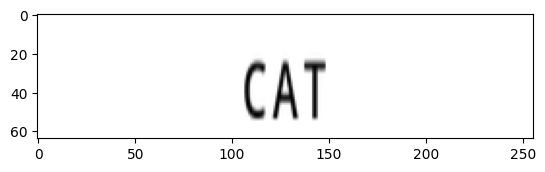

DOG
модель DOG


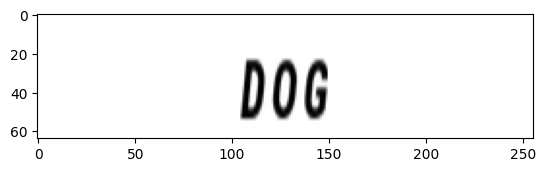

HOUSE
модель HOUSE


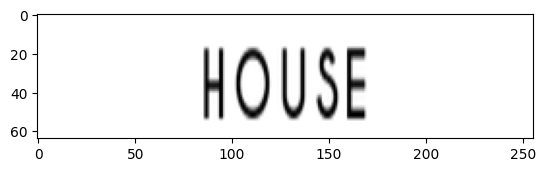

BICYCLE
модель BICYCLE


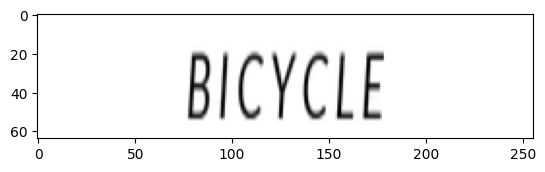

COMPUTER
модель COMPUTER


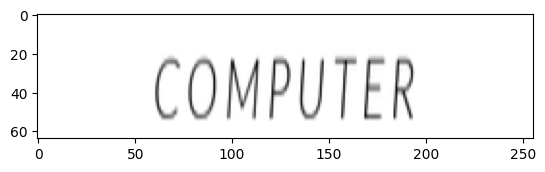

TECHNOLOGY
модель TECHNOLOGY


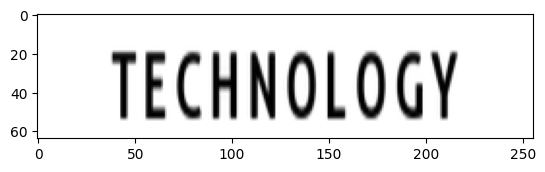

INTERNET
модель INTERNET


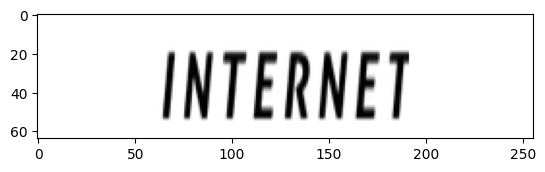

BANANA
модель BANANA


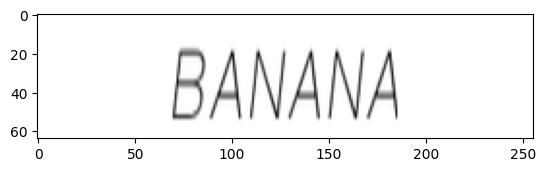

CHERRY
модель CHERRY


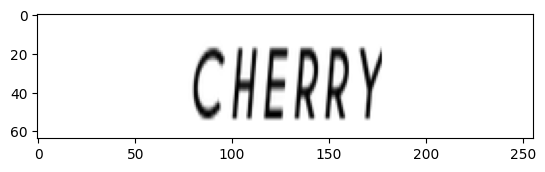

STRAWBERRY
модель STRAWBERRY


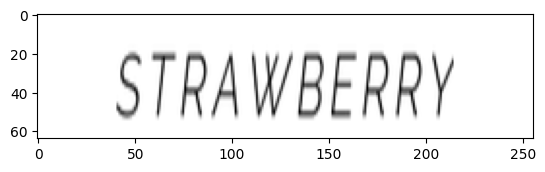

ORANGE
модель ORANGE


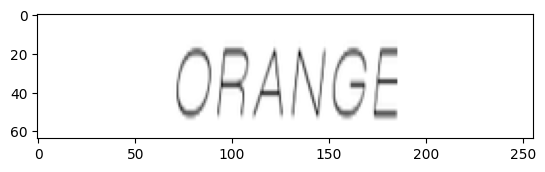

GRAPE
модель GRAPE


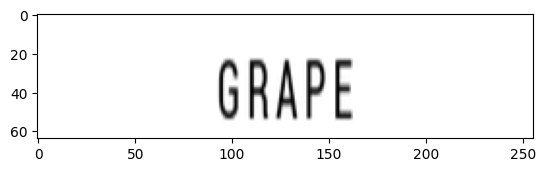

KIWI
модель KIWI


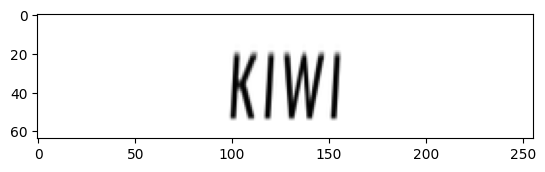

MELON
модель MELON


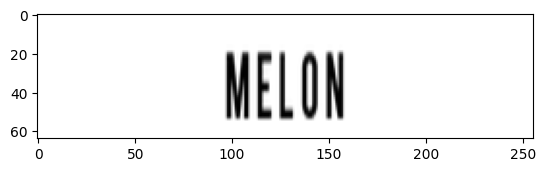

PEACH
модель PEACH


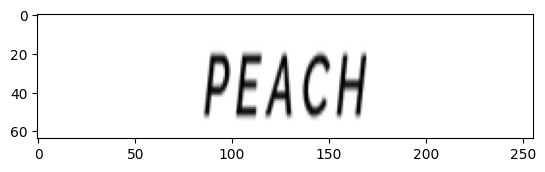

PEAR
модель PEAR


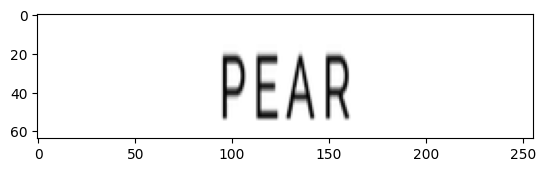

MANGO
модель MANGO


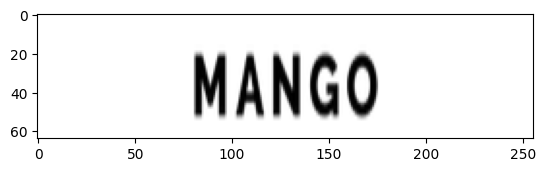

APRICOT
модель APRICOT


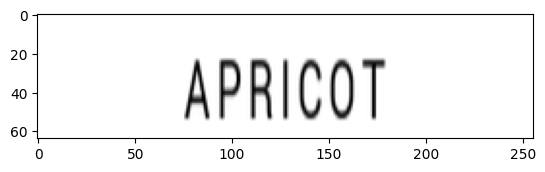

WATERMELON
модель WATERMELON


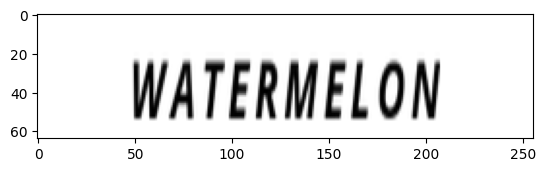

CANTALOUPE
модель CANTALOUPE


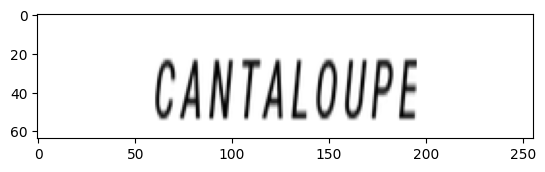

DRAGONFRUIT
модель DRAGONFRUIT


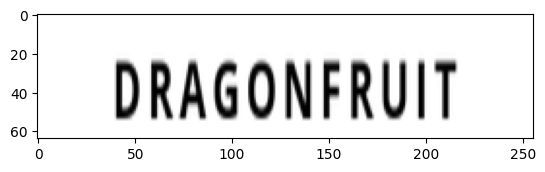

POMEGRANATE
модель POMEGRANATE


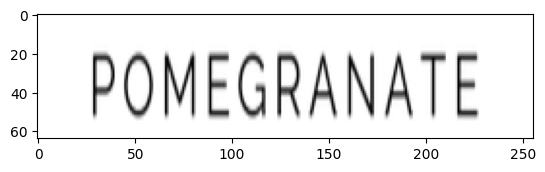

BLACKBERRY
модель BLACKBERRY


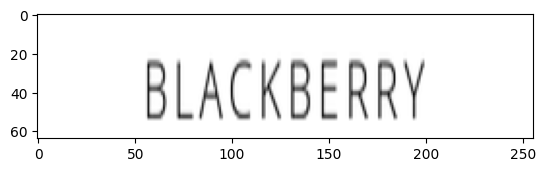

BLUEBERRY
модель BLUEBERRY


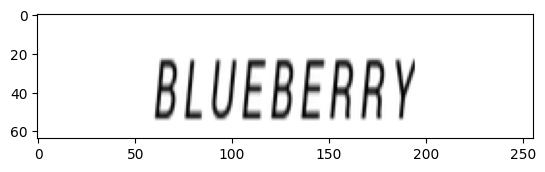

RASPBERRY
модель RASPBERRY


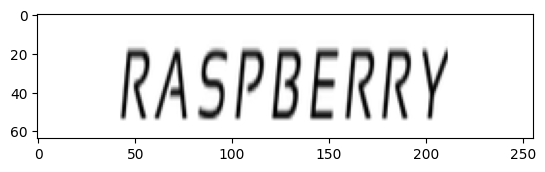

CURRANT
модель CURRANT


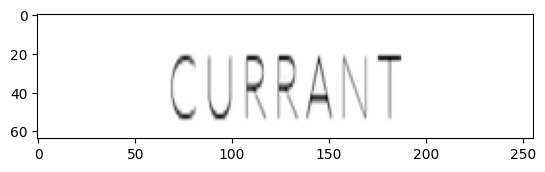

FIG
модель FIG


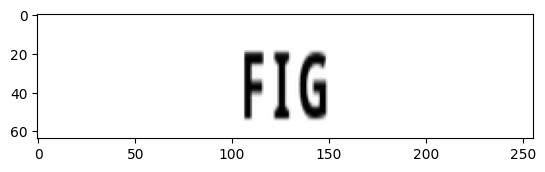

LIME
модель LIME


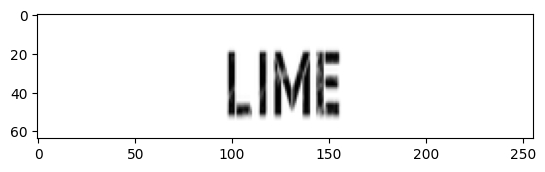

LEMON
модель LEMON


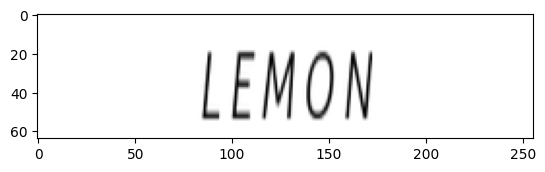

DATE
модель DATE


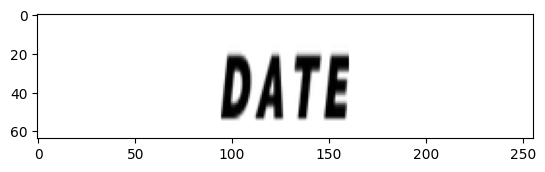

SOUR
модель SOUR


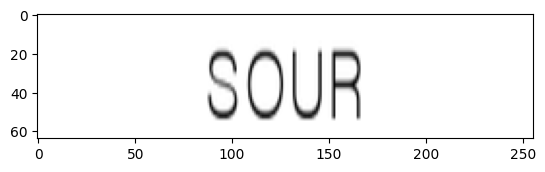

SOURSOP
модель SOURSOP


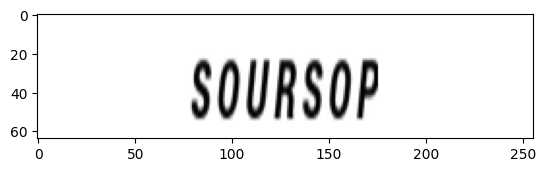

STARFRUIT
модель STARERUIT


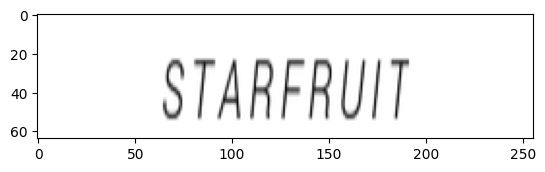

JACKFRUIT
модель JACKFRUIT


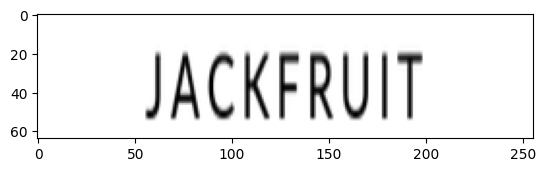

QUINCE
модель QUINCE


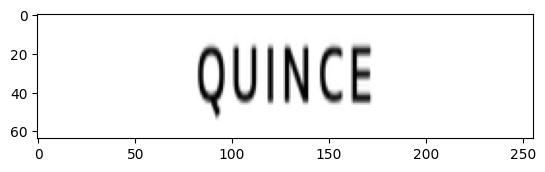

RHUBARB
модель RHUBARB


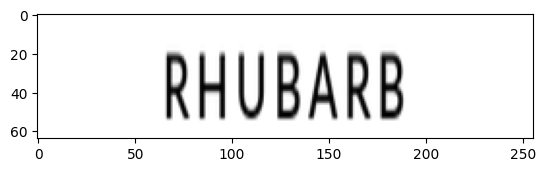

BLOODORANGE
модель BLOODORANGE


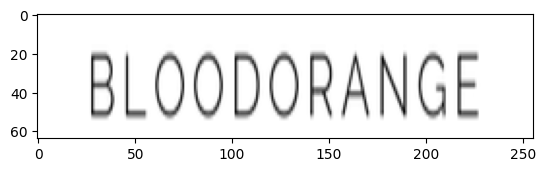

TAMARIND
модель TAMARIND


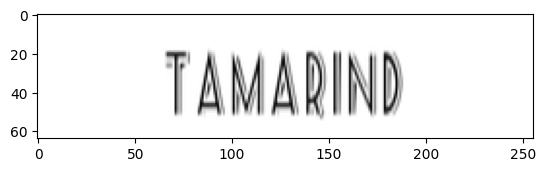

NECTARINE
модель NECTARINE


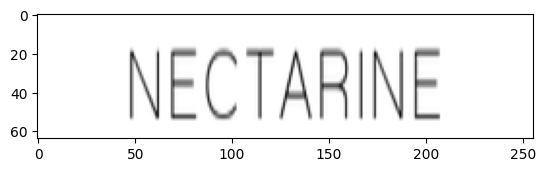

PERSIMMON
модель PERSIMMON


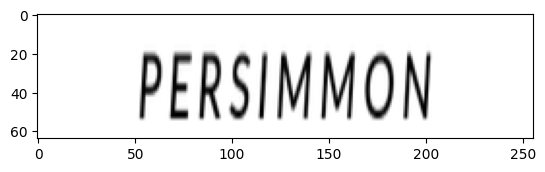

AVOCADO
модель AVVOCADO


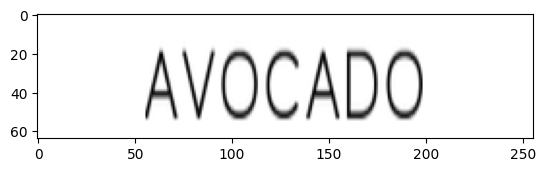

PAPAYA
модель PAPAYA


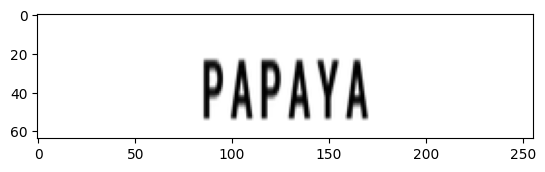

CLOUDBERRY
модель CLOUDBERRY


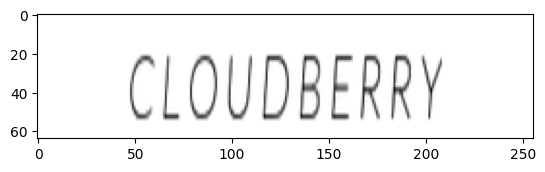

MULBERRY
модель MULBERRY


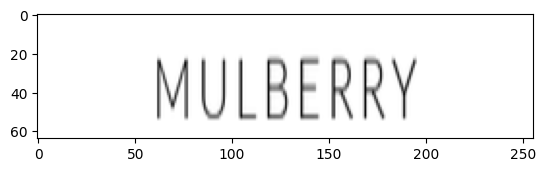

PINEAPPLE
модель PINEAPPILE


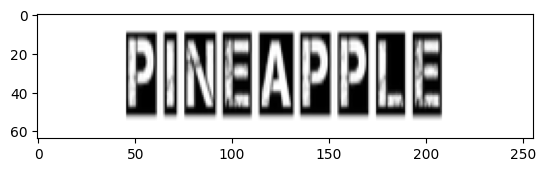

COCONUT
модель COCONUT


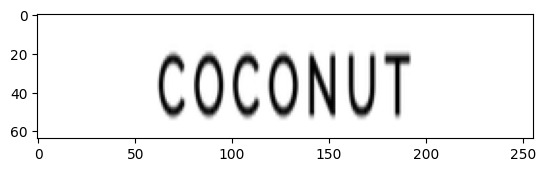

ZUCCHINI
модель ZUCCHINI


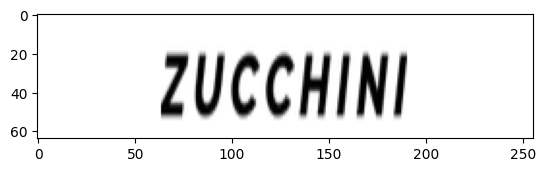

CARROT
модель CARROT


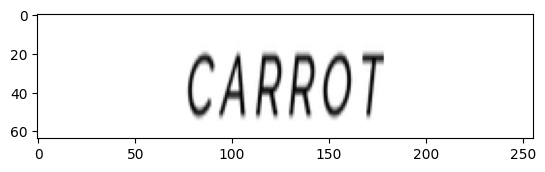

SPINACH
модель SPINACH


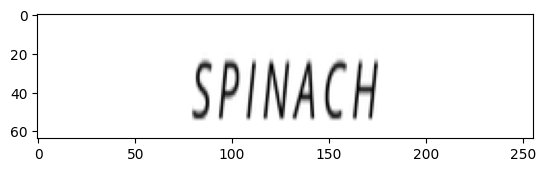

BROCCOLI
модель BROCCOLI


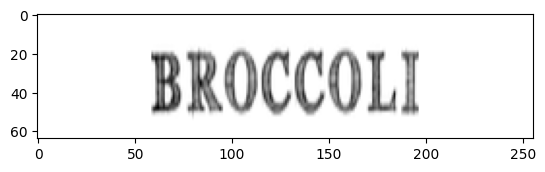

LETTUCE
модель LETTUCE


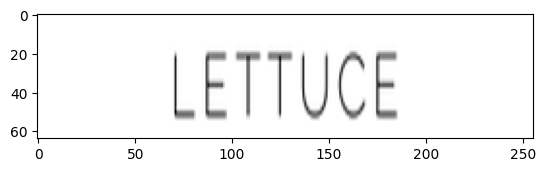

CUCUMBER
модель CUCUMBER


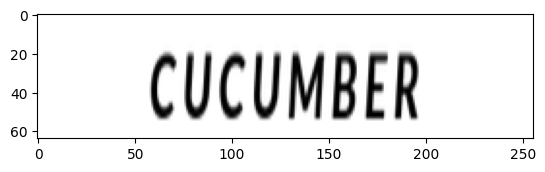

TOMATO
модель TOMATO


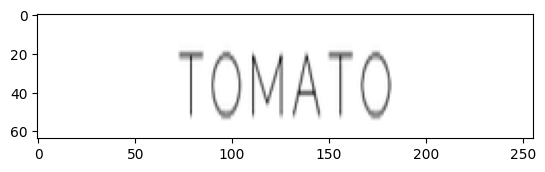

ONION
модель ONION


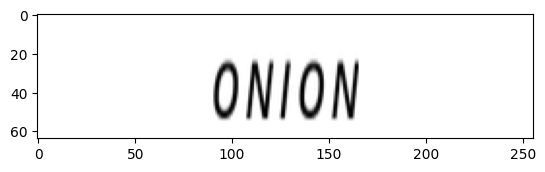

PEPPER
модель PEPPER


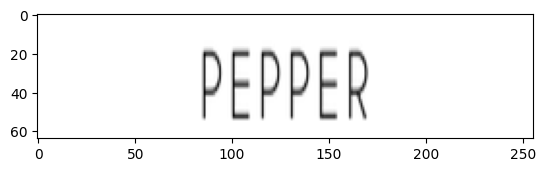

CELERY
модель CELERY


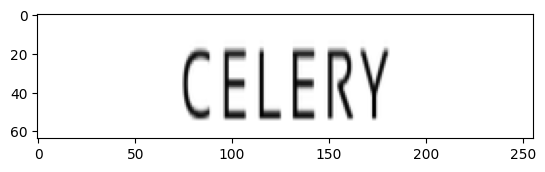

RADISH
модель RADISH


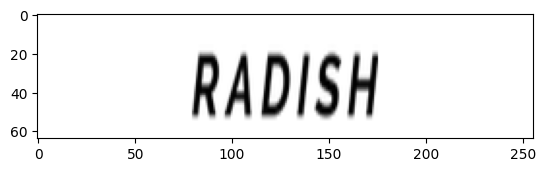

HERB
модель HERB


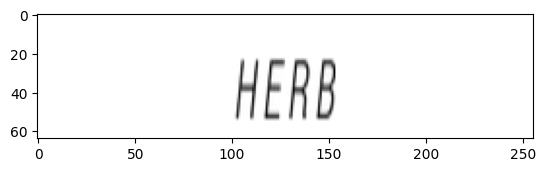

BASIL
модель BASIL


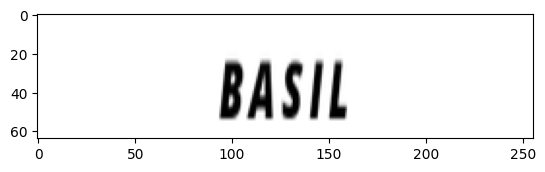

PARSLEY
модель PARSLEY


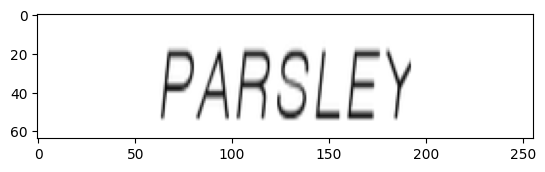

CILANTRO
модель CILANTRO


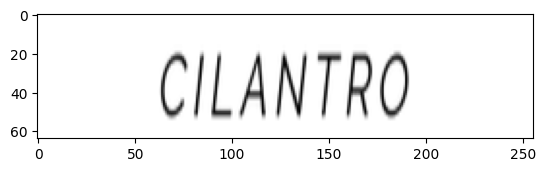

GARLIC
модель GARLIC


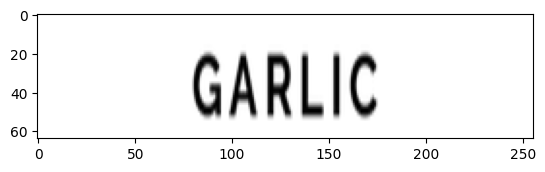

GINGER
модель GINGER


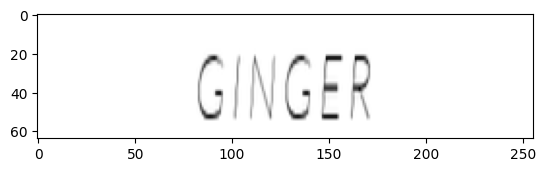

MUSTARD
модель MUSTARD


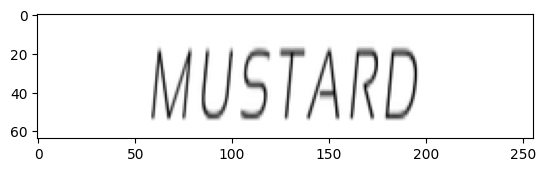

CHILI
модель CHILL


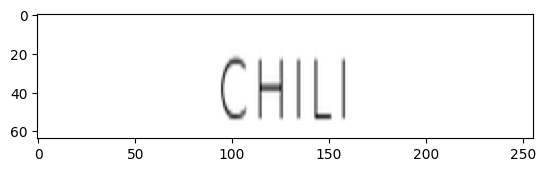

SQUASH
модель SQUASH


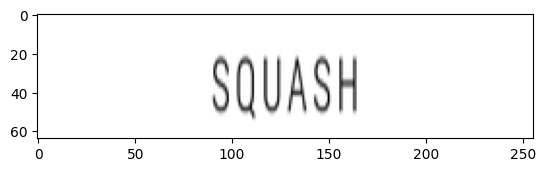

EGGPLANT
модель EGGPLANT


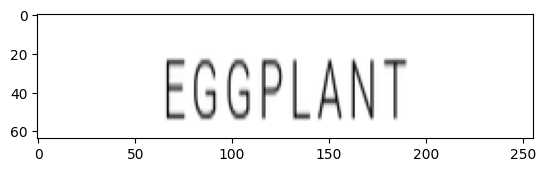

BAKING
модель BAKING


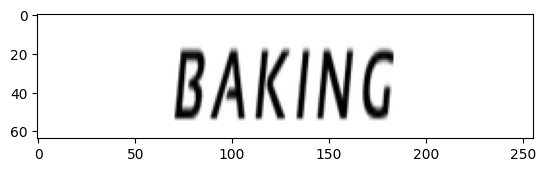

PASTA
модель PASTA


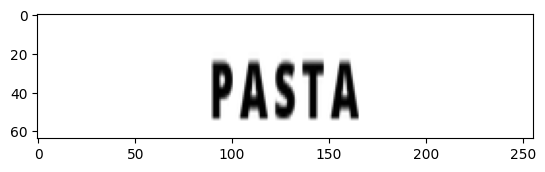

DOUGHNUT
модель DOUGHNUT


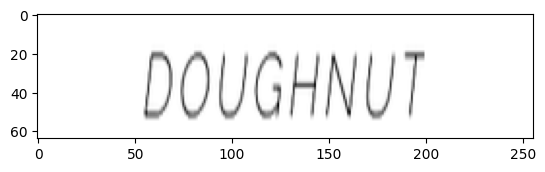

COOKIES
модель COIES


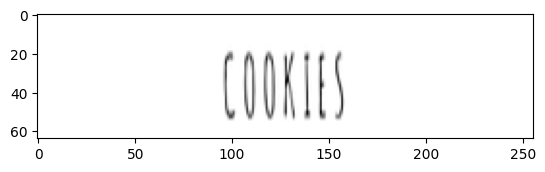

WAFFLES
модель WAFFLES


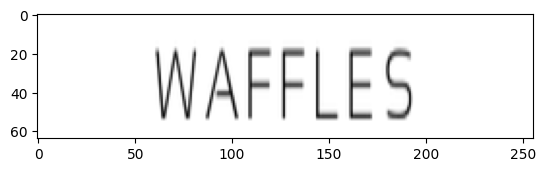

CUPCAKE
модель CURCKKE


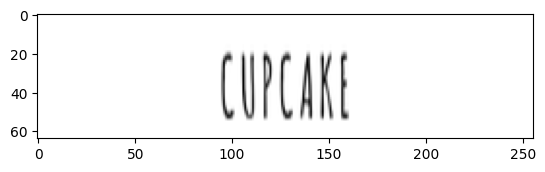

BROWNIE
модель BROWNIE


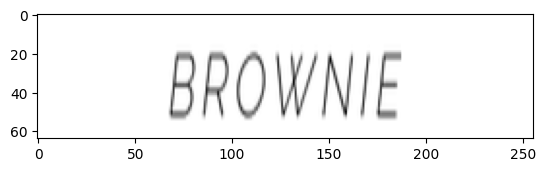

CHEESECAKE
модель CHEESECAKE


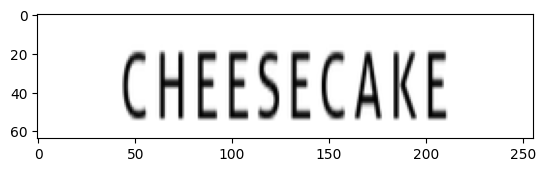

TIRAMISU
модель TIRAMISU


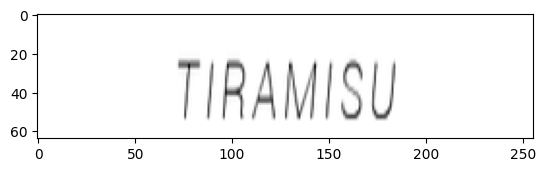

PUDDING
модель PUDDING


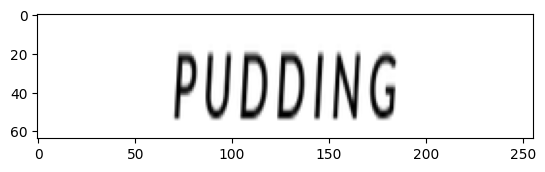

SALSA
модель SALSA


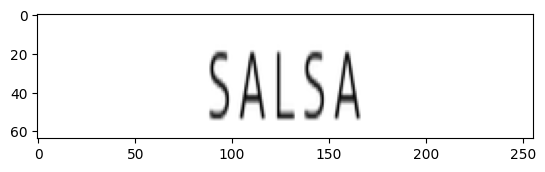

GUACAMOLE
модель GUACAMOLE


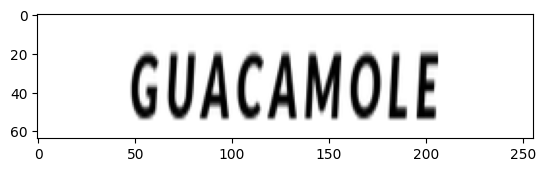

SAUCE
модель SAUCE


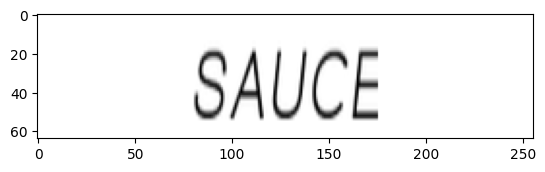

SYRUP
модель SYRUG


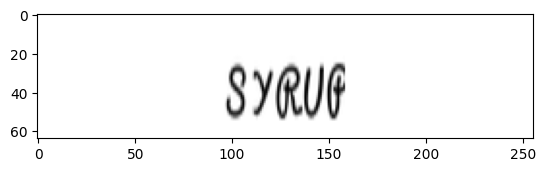

CARAMEL
модель CARAMEL


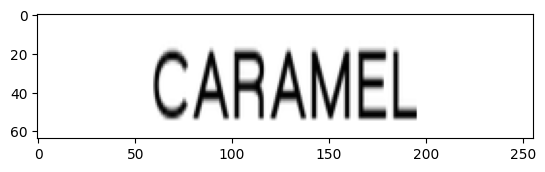

CHOCOLATE
модель CHOCOLATE


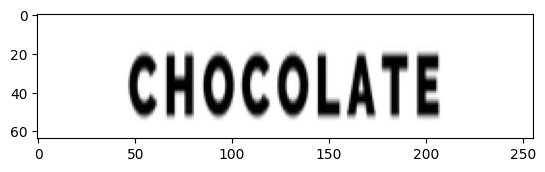

VANILLA
модель VANILLA


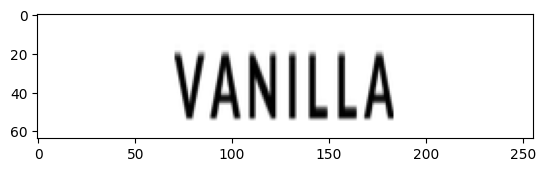

PEANUT
модель PEANUT


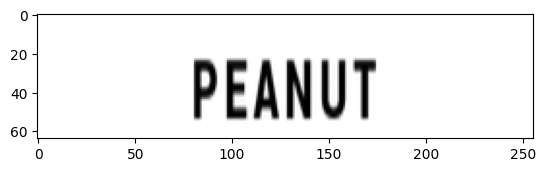

BUTTER
модель BUTTER


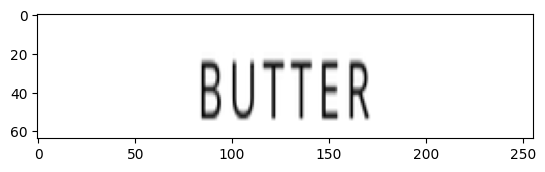

JELLY
модель JELLY


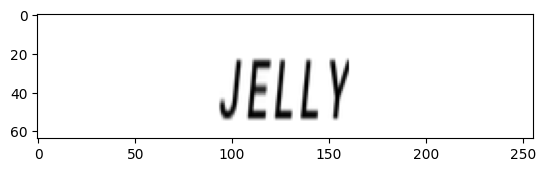

SANDWICH
модель SANDWICH


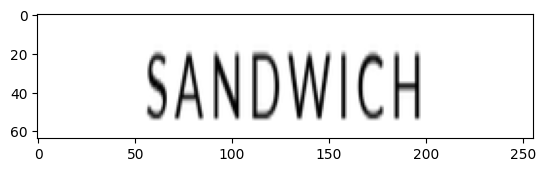

PANCAKE
модель PANCAKE


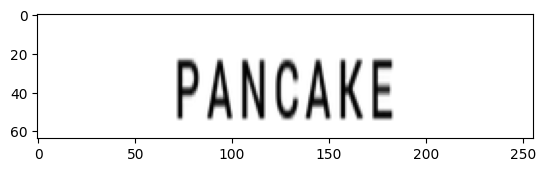

OMELETTE
модель OMELETTE


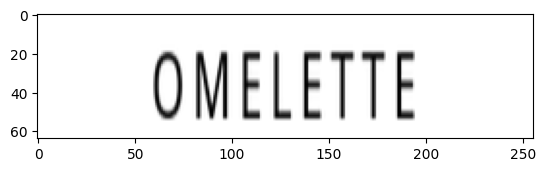

HASHBROWN
модель HASHBROWN


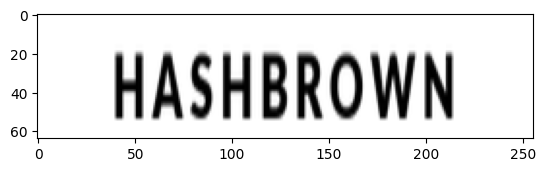

SMOOTHIE
модель SMOOTHIE


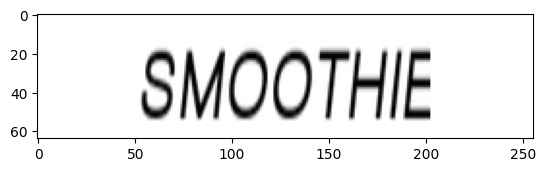

GELATO
модель GELATO


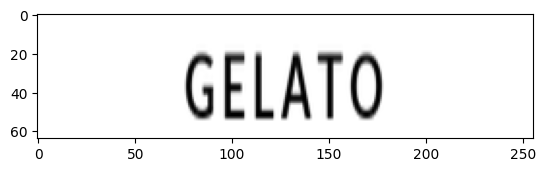

FROZEN
модель FROZEN


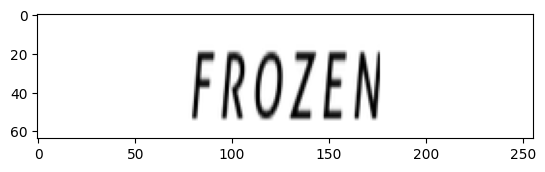

SUNDAE
модель SUNDAE


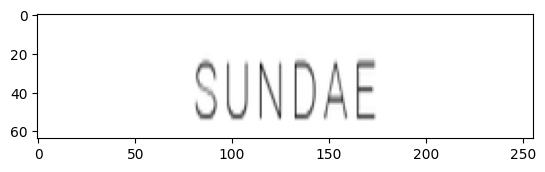

WHIPPED
модель WHIPPED


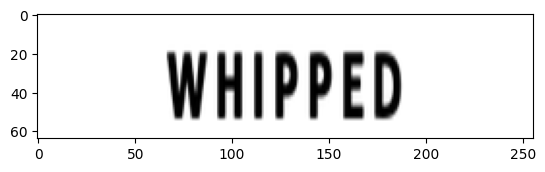

CREAM
модель CREAM


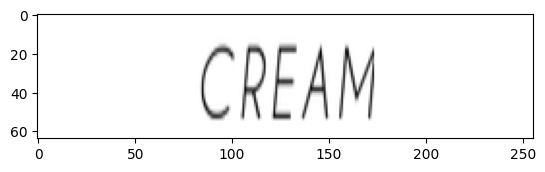

MILKSHAKE
модель MILKSHAKE


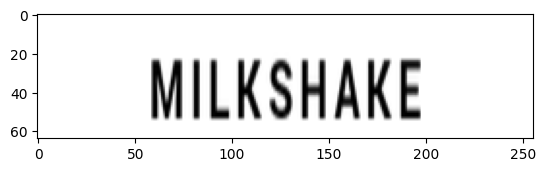

CEREAL
модель CEREAL


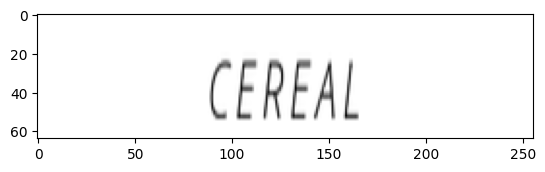

OATMEAL
модель OATMEAL


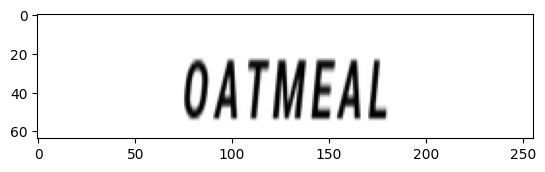

GRANOLA
модель GRANOLA


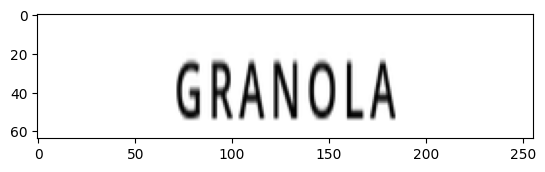

BUSINESS
модель BUSINESS


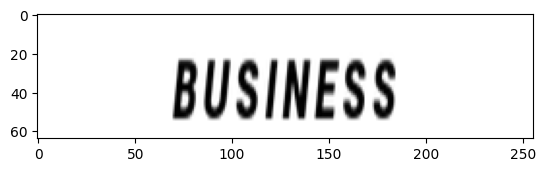

MARKETING
модель MARKETING


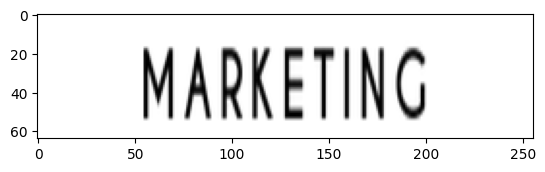

FINANCE
модель FINANCE


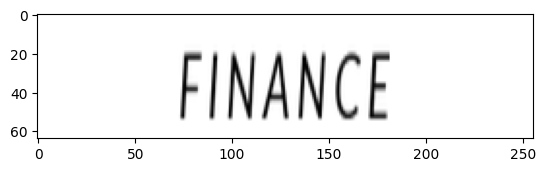

ECONOMY
модель ECONOMY


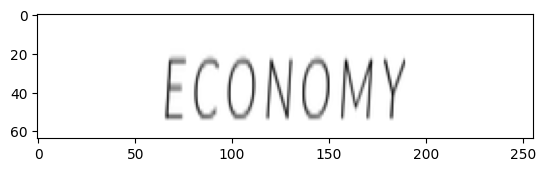

EDUCATION
модель EDUCATION


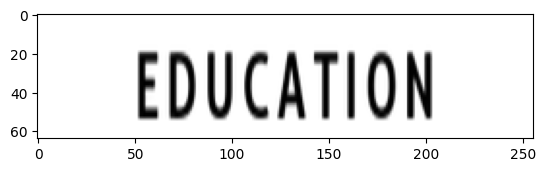

TECHNOLOGY
модель TECHNOLOGY


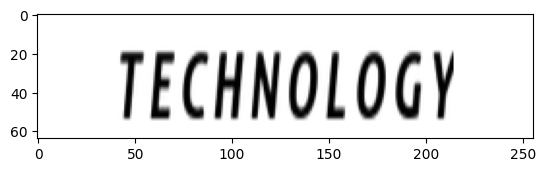

INNOVATION
модель INNOVATION


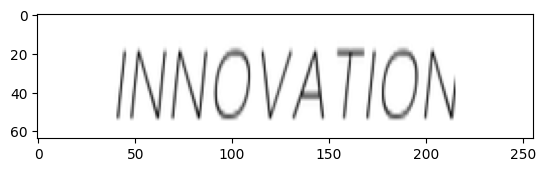

SOFTWARE
модель SOFTWARE


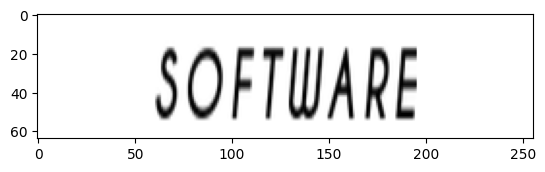

HARDWARE
модель HARDWARE


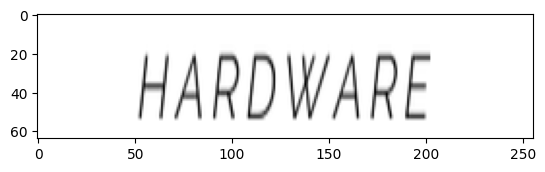

NETWORKING
модель NETWORKING


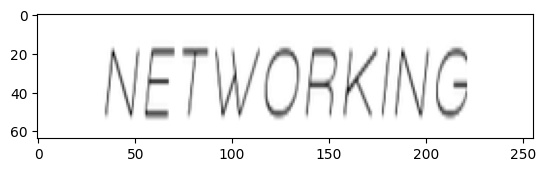

PROGRAMMING
модель PROGRAMMING


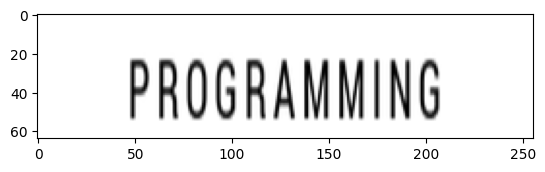

DEVELOPER
модель DEVELOPER


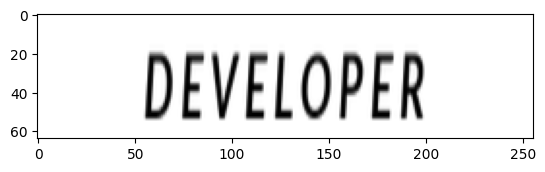

DATABASE
модель DATABASE


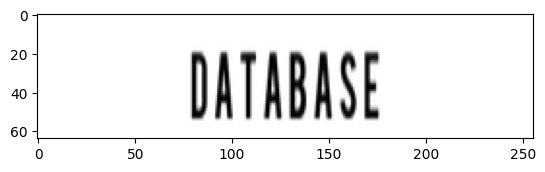

SECURITY
модель SECURITY


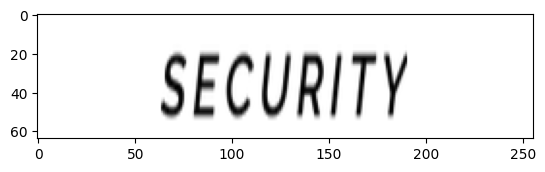

CRYPTOGRAPHY
модель CRYPTOGRAPHY


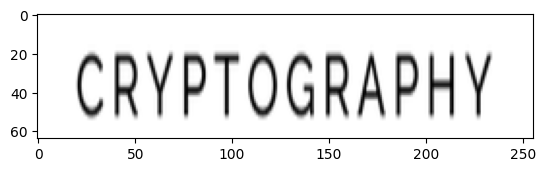

ALGORITHM
модель ALGORITHM


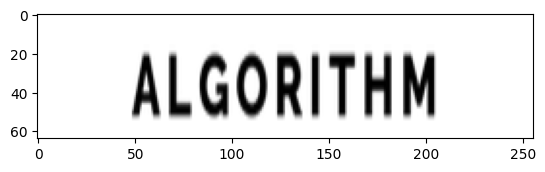

ROBOTICS
модель ROBOTICS


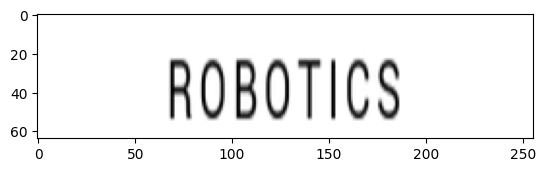

SIMULATION
модель SIMULATION


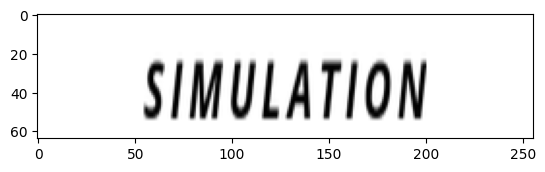

INTERFACE
модель INTERFACE


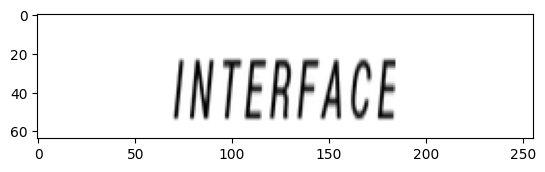

NETWORK
модель NETWORK


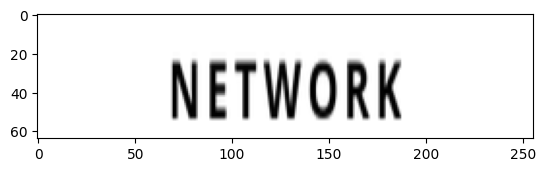

APPLICATION
модель APPLICATION


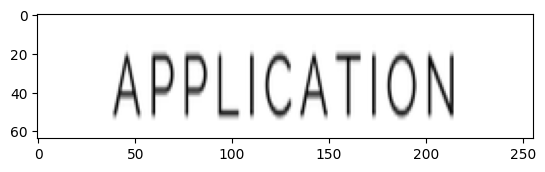

FRAMEWORK
модель FRAMEWORK


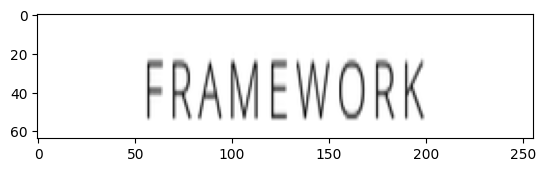

PERFORMANCE
модель PERFORMANCE


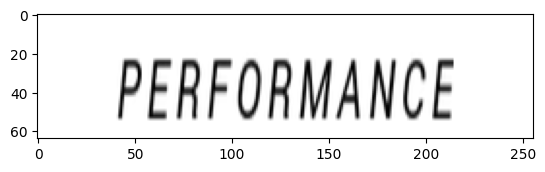

ANALYSIS
модель ANLLYSIS


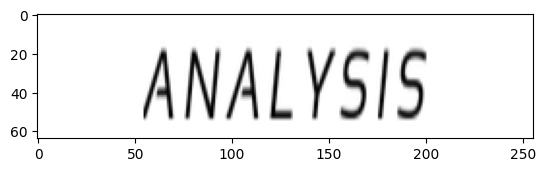

ARCHITECTURE
модель ARCHITECTURE


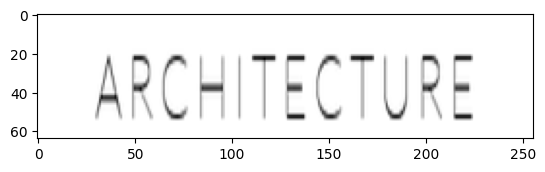

DEVELOPMENT
модель DEVELOPMENT


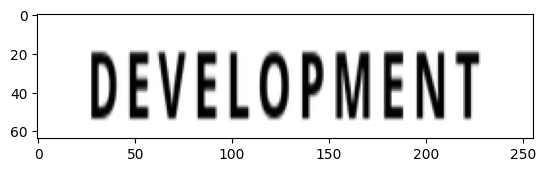

AUTOMATION
модель AUTOMATION


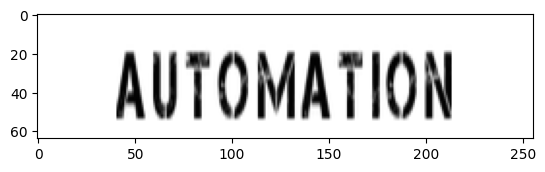

OPTIMIZATION
модель OPTIMIZATION


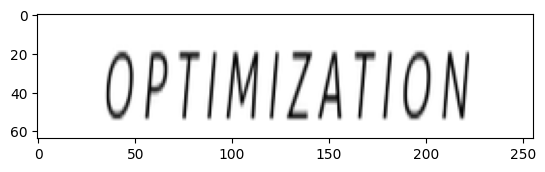

ANALYTICS
модель ANLLYTICS


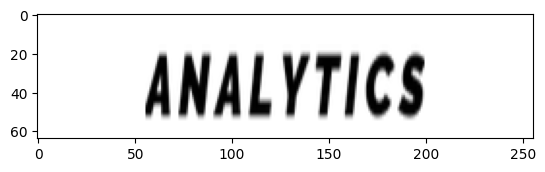

RESEARCH
модель RESEARCH


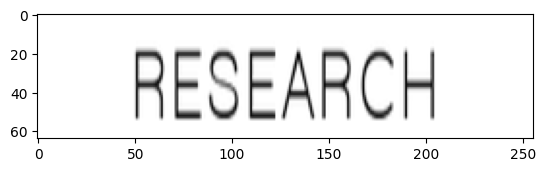

TRENDING
модель TRENDING


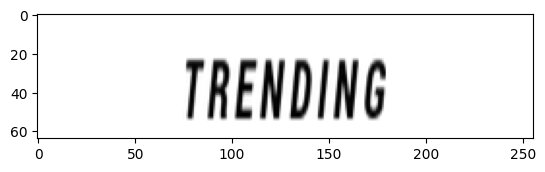

STRATEGY
модель STRATEGY


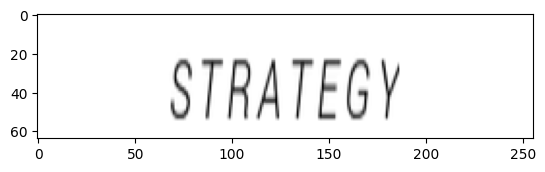

CONSULTING
модель CONSULTING


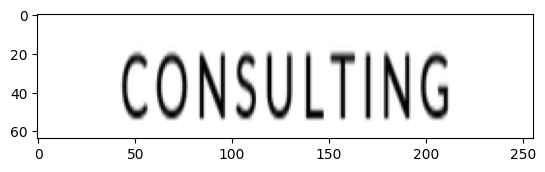

LEADERSHIP
модель LEADERSHIP


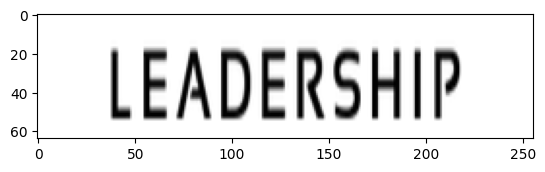

MANAGEMENT
модель MANAGEMENT


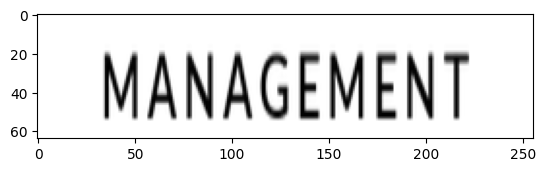

TEAMWORK
модель TEAMWORK


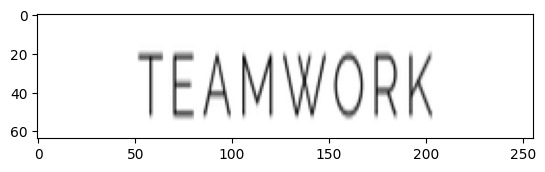

PROJECT
модель DROIECT


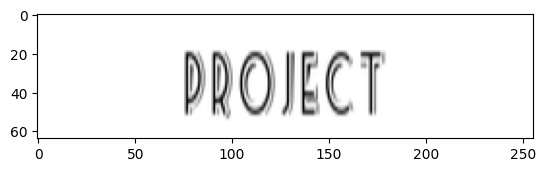

PLANNING
модель PLANNING


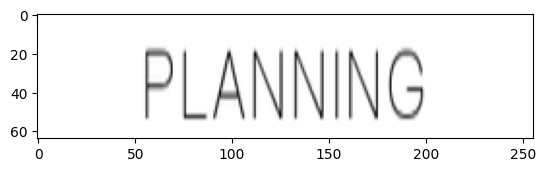

EXECUTION
модель EXECUTION


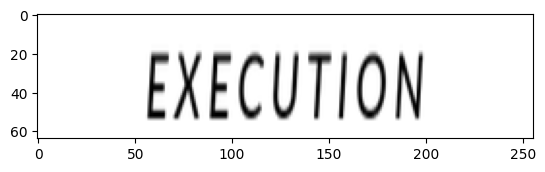

GOALS
модель GOALS


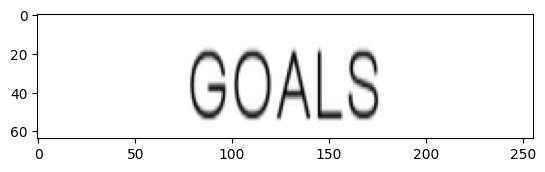

OBJECTIVES
модель 0BJECTIVES


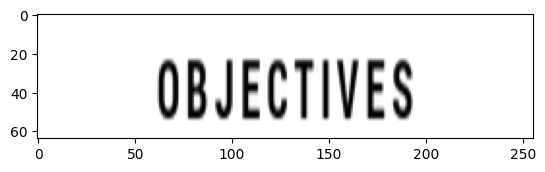

FEEDBACK
модель FEEDBACK


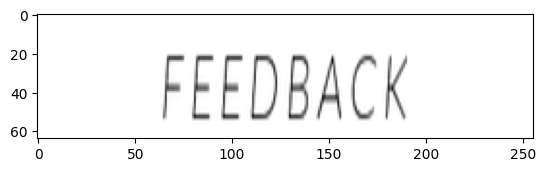

RESULTS
модель RESULTS


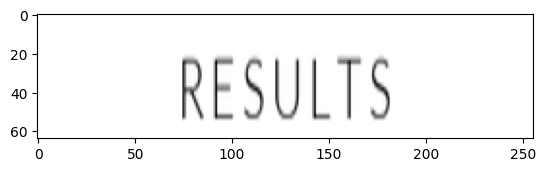

CLIENT
модель CLLEENT


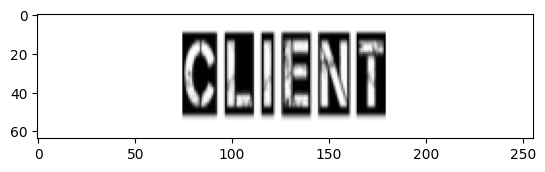

CUSTOMER
модель CUSTOMER


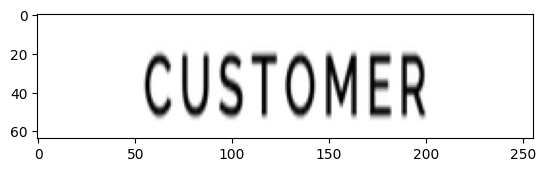

EXPERIENCE
модель EXPERIENCE


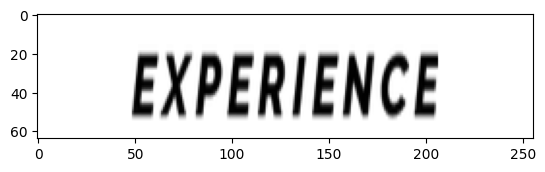

ANALYTICS
модель ANLLTICS


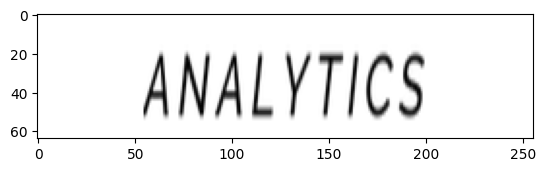

REPORTING
модель REPORTING


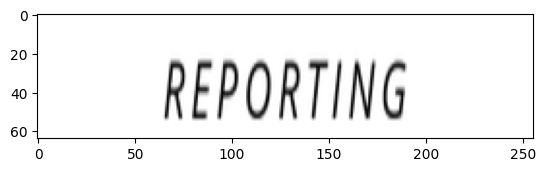

INSIGHTS
модель INSIGITS


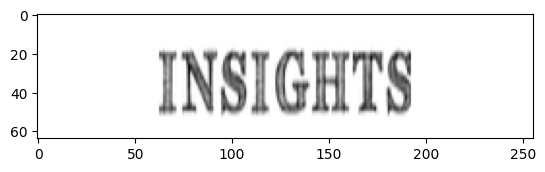

EVALUATION
модель EVALUATION


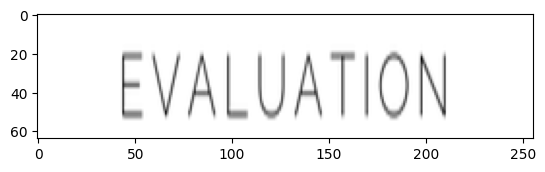

METRICS
модель METRICS


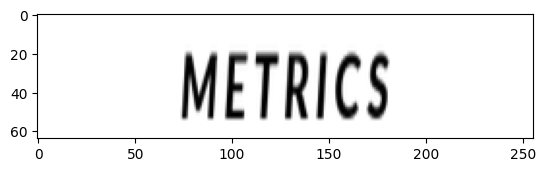

DASHBOARD
модель DASHBOARD


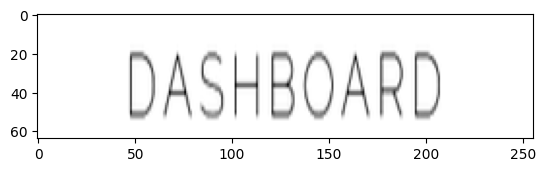

VISUALIZATION
модель VISUALIZATION


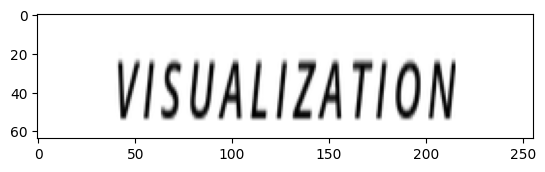

PRESENTATION
модель PRESENTATION


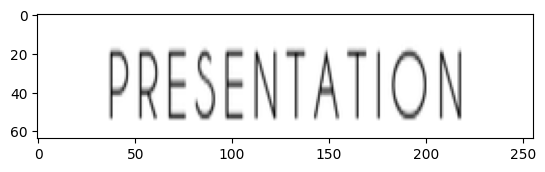

NEGOTIATION
модель NEGOTIIATION


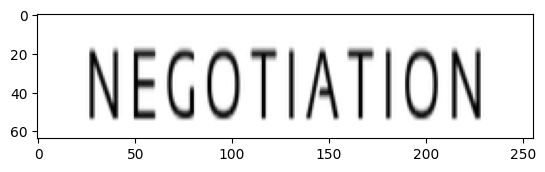

COLLABORATION
модель COLLABORATION


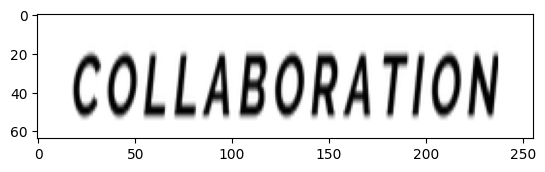

ENTREPRENEURSHIP
модель ENTREPRENEURSHIP


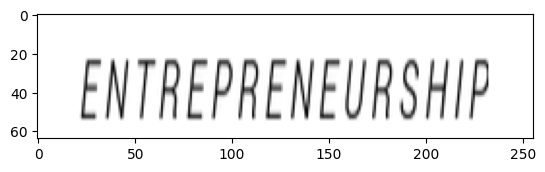

MINDSET
модель MINDSET


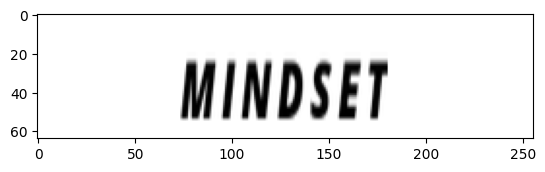

MOTIVATION
модель MOTIVATION


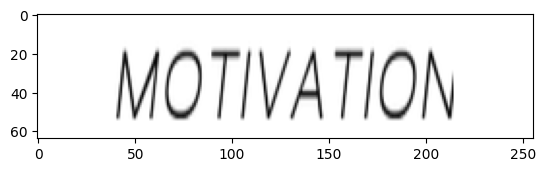

INSPIRATION
модель INSPIRATION


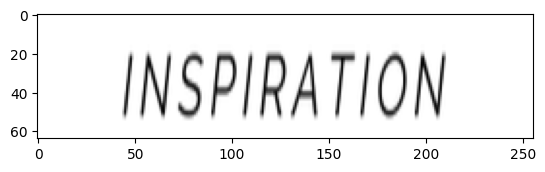

CREATIVITY
модель CREATIVITY


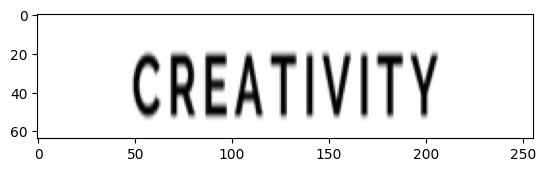

PROBLEM
модель PROBLEM


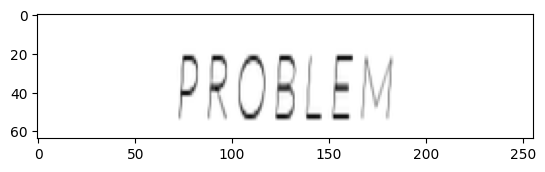

SOLUTION
модель SOLUTION


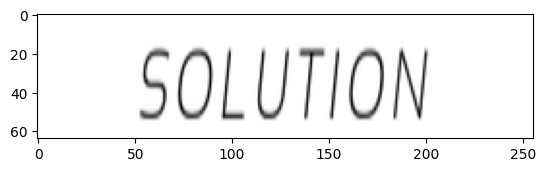

THINKING
модель THINKING


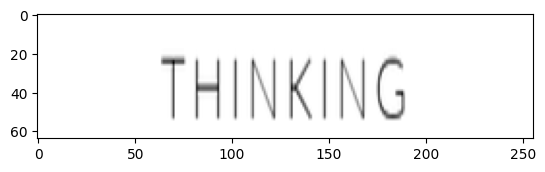

MINDFULNESS
модель MINDFULNESS


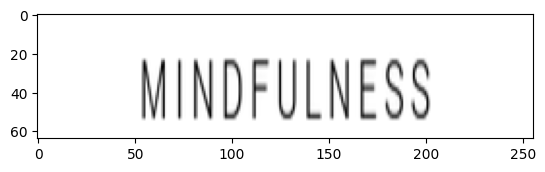

WELLNESS
модель WELLNESS


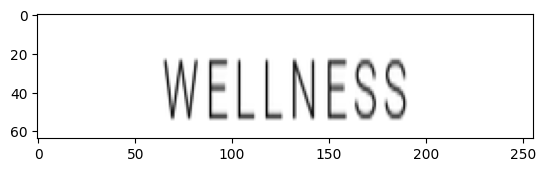

EXERCISE
модель EXERCISE


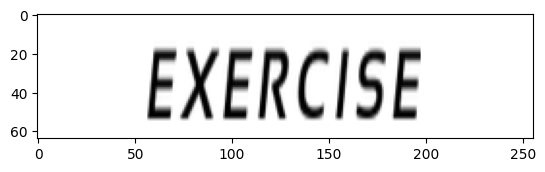

NUTRITION
модель NUTRITION


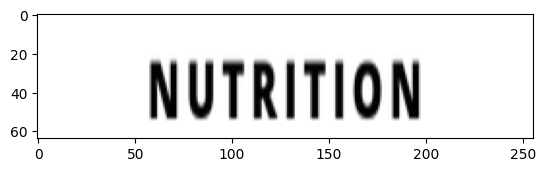

BALANCE
модель BALANCE


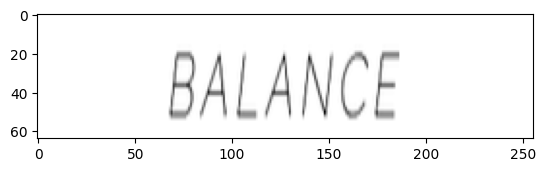

LIFESTYLE
модель WESHIE


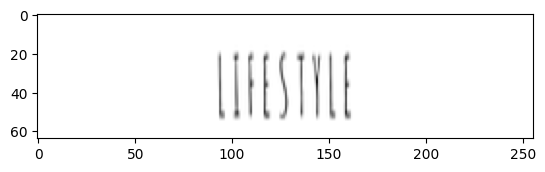

HAPPINESS
модель HAPPINESS


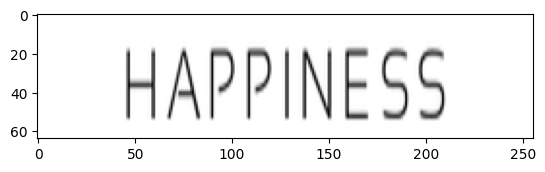

SUCCESS
модель SUCCES


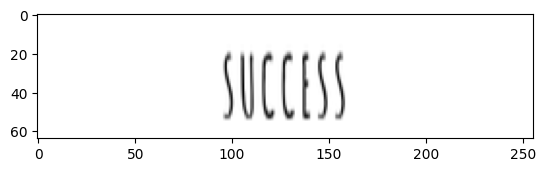

GROWTH
модель GROWTH


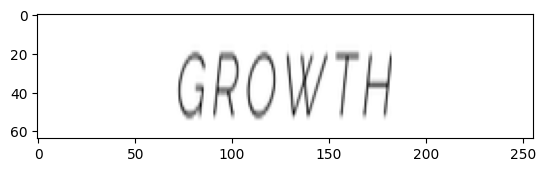

CONFIDENCE
модель CONFIDENCE


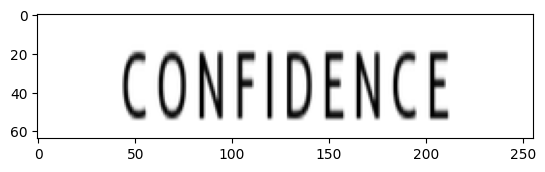

PASSION
модель PASSION


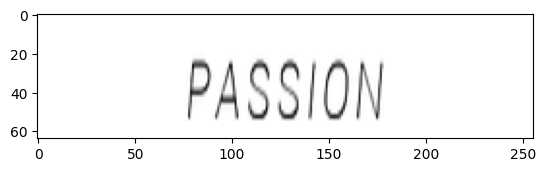

PURPOSE
модель PURPOSE


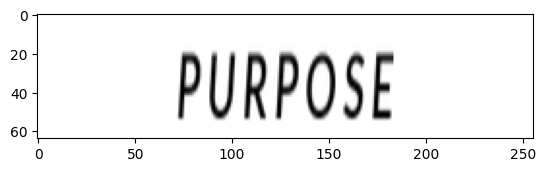

VALUES
модель VALUES


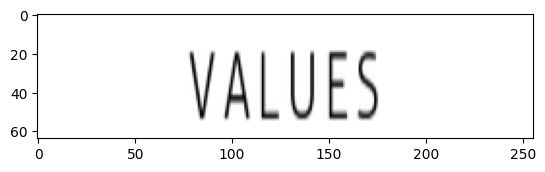

BELIEFS
модель BELIEFS


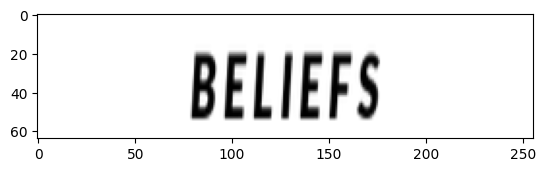

DREAM
модель DREAM


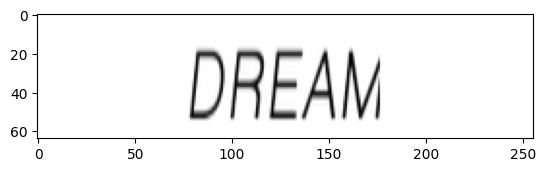

VISION
модель WiSTon


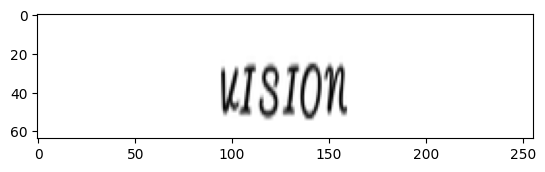

INTENTION
модель INTENTION


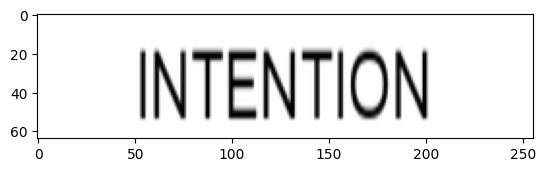

DECISION
модель DECISION


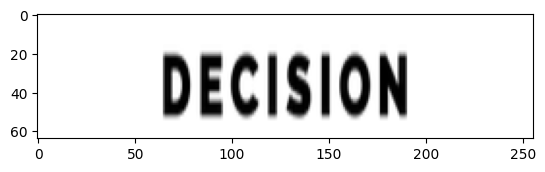

CHOICE
модель CHOICE


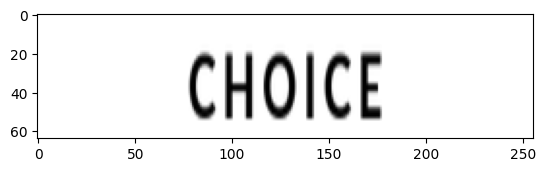

ACTION
модель ACTION


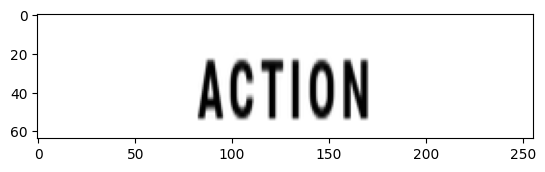

['CAT', 'DOG', 'HOUSE', 'BICYCLE', 'COMPUTER', 'TECHNOLOGY', 'INTERNET', 'BANANA', 'CHERRY', 'STRAWBERRY', 'ORANGE', 'GRAPE', 'KIWI', 'MELON', 'PEACH', 'PEAR', 'MANGO', 'APRICOT', 'WATERMELON', 'CANTALOUPE', 'DRAGONFRUIT', 'POMEGRANATE', 'BLACKBERRY', 'BLUEBERRY', 'RASPBERRY', 'CURRANT', 'FIG', 'LIME', 'LEMON', 'DATE', 'SOUR', 'SOURSOP', 'STARERUIT', 'JACKFRUIT', 'QUINCE', 'RHUBARB', 'BLOODORANGE', 'TAMARIND', 'NECTARINE', 'PERSIMMON', 'AVVOCADO', 'PAPAYA', 'CLOUDBERRY', 'MULBERRY', 'PINEAPPILE', 'COCONUT', 'ZUCCHINI', 'CARROT', 'SPINACH', 'BROCCOLI', 'LETTUCE', 'CUCUMBER', 'TOMATO', 'ONION', 'PEPPER', 'CELERY', 'RADISH', 'HERB', 'BASIL', 'PARSLEY', 'CILANTRO', 'GARLIC', 'GINGER', 'MUSTARD', 'CHILL', 'SQUASH', 'EGGPLANT', 'BAKING', 'PASTA', 'DOUGHNUT', 'COIES', 'WAFFLES', 'CURCKKE', 'BROWNIE', 'CHEESECAKE', 'TIRAMISU', 'PUDDING', 'SALSA', 'GUACAMOLE', 'SAUCE', 'SYRUG', 'CARAMEL', 'CHOCOLATE', 'VANILLA', 'PEANUT', 'BUTTER', 'JELLY', 'SANDWICH', 'PANCAKE', 'OMELETTE', 'HASHBROWN', 'SMOOT

In [243]:
texts = list(map(str.upper, [
    "cat", "dog", "house", "bicycle", "computer", "technology",
    "internet", "banana", "cherry", "strawberry", "orange",
    "grape", "kiwi", "melon", "peach", "pear", "mango",
    "apricot", "watermelon", "cantaloupe", "dragonfruit",
    "pomegranate", "blackberry", "blueberry", "raspberry",
    "currant", "fig", "lime", "lemon", "date", 
    "sour", "soursop", "starfruit", "jackfruit", "quince",
    "rhubarb", "bloodorange", "tamarind", "nectarine", 
    "persimmon", "avocado", "papaya", "cloudberry", 
    "mulberry", "pineapple", "coconut", "zucchini",
    "carrot", "spinach", "broccoli", "lettuce", "cucumber",
    "tomato", "onion", "pepper", "celery", "radish", 
    "herb", "basil", "parsley", "cilantro", "garlic", 
    "ginger", "mustard", "chili", "squash", "eggplant",
    "baking", "pasta", "doughnut", "cookies", "waffles",
    "cupcake", "brownie", "cheesecake", "tiramisu", "pudding",
    "salsa", "guacamole", "sauce", "syrup", "caramel",
    "chocolate", "vanilla", "peanut", "butter", "jelly",
    "sandwich", "pancake", "omelette", "hashbrown",
    "smoothie", "gelato", "frozen", "sundae", "whipped",
    "cream", "milkshake", "cereal", "oatmeal", "granola",
    "business", "marketing", "finance", "economy",
    "education", "technology", "innovation", "software",
    "hardware", "networking", "programming", "developer", 
    "database", "security", "cryptography", "algorithm",
    "robotics", "simulation", "interface", "network", 
    "application", "framework", "performance", "analysis",
    "architecture", "development", "automation", "optimization",
    "analytics", "research", "trending", "strategy", 
    "consulting", "leadership", "management", "teamwork",
    "project", "planning", "execution", "goals", "objectives",
    "feedback", "results", "client", "customer", "experience",
    "analytics", "reporting", "insights", "evaluation",
    "metrics", "dashboard", "visualization", "presentation",
    "negotiation", "collaboration", "entrepreneurship",
    "mindset", "motivation", "inspiration", "creativity",
    "problem", "solution", "thinking", "mindfulness", "wellness",
    "exercise", "nutrition", "balance", "lifestyle", 
    "happiness", "success", "growth", "confidence",
    "passion", "purpose", "values", "beliefs", "dream",
    "vision", "intention", "decision", "choice", "action",
]))

img_text_generator = GeneratorFromStrings(
    texts,
    blur=0,
    background_type=1,
    random_blur=False, 
    character_spacing=5,
    count=len(texts),
    width=256,
    margins=(5, 5, 5, 5),
)

width = 256
height = 64

symbols = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz!?"\',.-='
blank_symbol = len(symbols)
num_classes = len(symbols) + 1

transform = transforms.Compose([
                        transforms.ToTensor(),
                        ResizePadding(width, centered=True, mode='width'),
                        ResizePadding(height, centered=True, mode='height'),
                        RotateTransform(angle=-90, expand=True),
                        transforms.Resize((width, height))  
                    ])

output_sequences = []



for input, target in img_text_generator:
    print(target)
    array = np.array(input)

    img = cv2.cvtColor(array, cv2.COLOR_BGR2GRAY)

    img = transform(img)

    output = pretrained_model(img.to(device).unsqueeze(0))
    predicted_classes = torch.argmax(output, dim=2)

    decoded_sequence = decode_sequence_with_blank(predicted_classes[0], symbols, blank_symbol)

    output_sequences.append(decoded_sequence)

    print("модель", decoded_sequence)


    plt.imshow(np.rot90(img.permute(1, 2, 0)), cmap='gray')
    plt.show()

print(output_sequences)



In [244]:
cer = jiwer.cer(texts, output_sequences) 
wer = jiwer.wer(texts, output_sequences) 

print("CER:", cer)
print("Точность распознования символа:", 1-cer)
print("WER:", wer)
print("Точность распознования слова:", 1-wer)


CER: 0.02229965156794425
Точность распознования символа: 0.9777003484320558
WER: 0.0972972972972973
Точность распознования слова: 0.9027027027027027


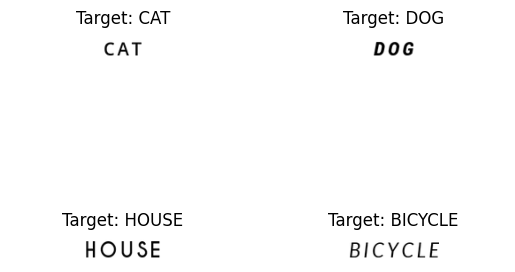

In [173]:
fig, axs = plt.subplots(2, 2)

for ax, img, target in zip(axs.flatten(), imgs, targets):
    ax.imshow(img, cmap='grey')
    ax.set_title(f"Target: {target}")
    ax.axis('off')
plt.show()
